# Data Analysis 3 - Home Assignment 2
## Data preparation script
## Author: Márton Nagy

**For a better understanding on the technical execution of the tasks and for some further explanation on certain visualizations, please refer to the technical report.**

In [1]:
import dill
import warnings

import numpy as np
import pandas as pd
from plotnine import *
import patchworklib as pw
%matplotlib inline

warnings.filterwarnings("ignore")
#from utils.py_helper_functions import *
from IPython.display import display

In [2]:
color = ["#DB5461", "#080357", "#3B8EA5", "#3B8EA5", "#3B8EA5"]

Raw data file from OSF (`cs_bisnode_panel.csv`).

In [ ]:
#data = pd.read_csv("https://osf.io/download/3qyut/")
data = pd.read_csv('cs_bisnode_panel.zip')

Filtering to have a panel from 2010 until 2015.

In [4]:
data = data[(data['year'] >= 2010) & (data['year'] <= 2015)]

Percentage of missing values per feature.

In [5]:
missing_pct = (data.isna().sum() / data.shape[0]) * 100
print(missing_pct[missing_pct > 90])

COGS              94.600432
finished_prod     94.778827
net_dom_sales     94.600432
net_exp_sales     94.600432
wages             94.690524
D                100.000000
dtype: float64


Dropping columns with too many missing values (above 90%).

In [6]:
data = data.drop(columns = list(missing_pct[missing_pct > 90].index))

Adding missing country-year observations.

In [7]:
data = (
    data.set_index(['year', 'comp_id'])
    .unstack(fill_value='toReplace')
    .stack()
    .reset_index()
)
data = data.replace('toReplace', np.nan)

In [8]:
print(f'T:N = {len(data.year.unique())}:{len(data.comp_id.unique())}')

T:N = 6:39375


Defining the target variable, `fast_growth` binary indicator. This is set to 1 if the company's sales CAGR is above the yearly sample mean CAGR in a two-year period. Also, this indicator can only be 1 for those firms that were *alive* both at the beginning and at the end of the two-year period.

In [9]:
data['status_alive'] = (data['sales'] > 0 & (False == data['sales'].isna())).astype(int)

In [10]:
data = data.sort_values(by = ['comp_id', 'year'])

In [11]:
data['cagr_2y'] = np.where(
    (data['status_alive'] == 1) & (data.groupby('comp_id')['status_alive'].shift(-2) == 1),
    (data.groupby('comp_id')['sales'].shift(-2) / data['sales']) ** (1/2) - 1,
    np.nan
)

cagr_stats = (
    data.dropna(subset=['cagr_2y'])  # Exclude invalid cases
    .groupby('year')['cagr_2y']
    .agg(['mean', 'std'])
    .rename(columns={'mean': 'cagr_mean', 'std': 'cagr_std'})
)

data = data.merge(cagr_stats, on='year', how='left')

In [12]:
data['b_fast_growth'] = ((data['cagr_2y'] > (data['cagr_mean']))).astype(int)

In [13]:
cagr_stats['cagr_mean']

year
2010    0.326111
2011    0.331114
2012    0.403879
2013    0.401411
Name: cagr_mean, dtype: float64

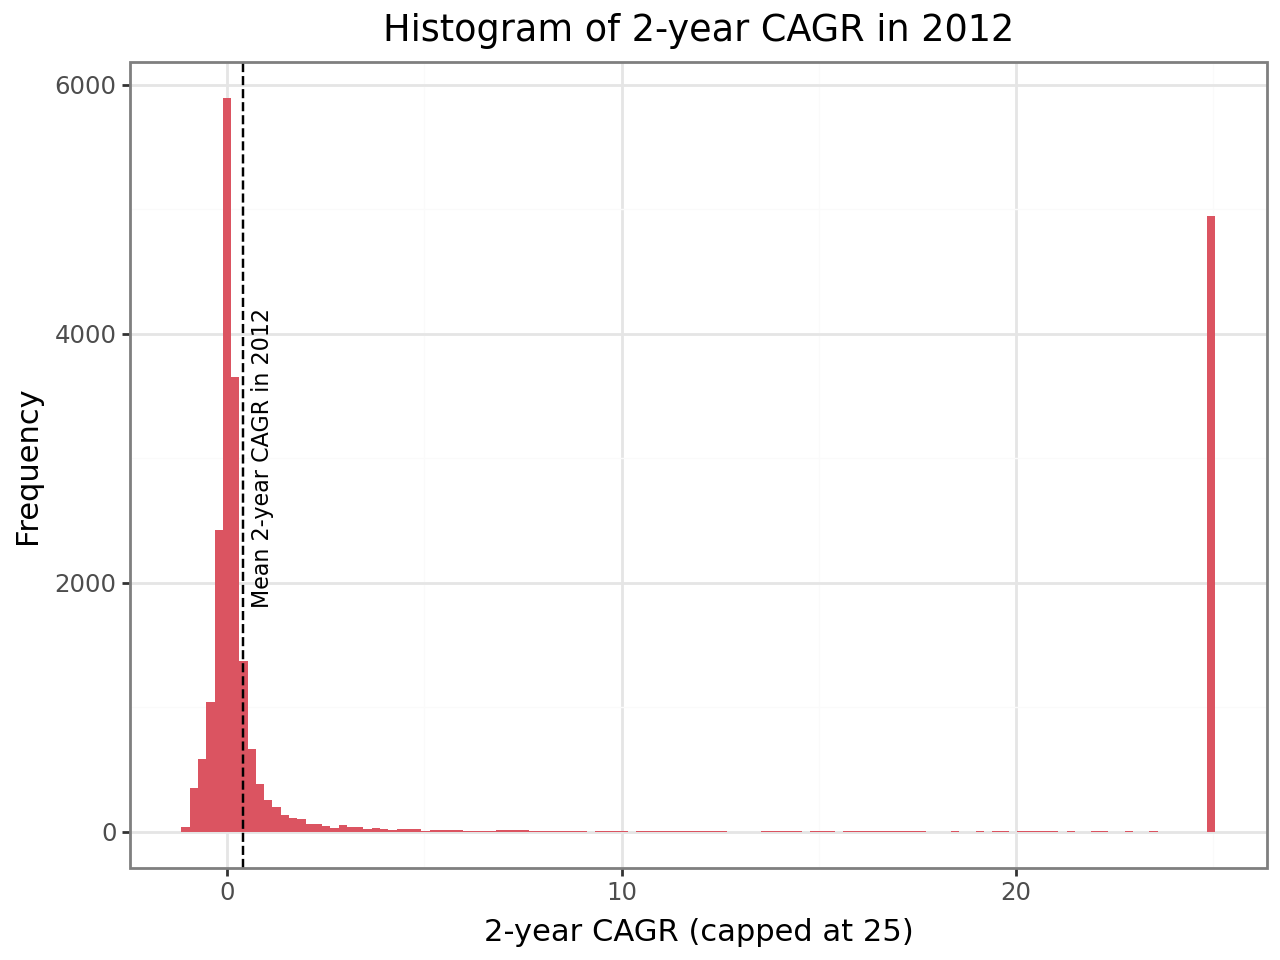

In [14]:
data['cagr_2y_capped'] = data['cagr_2y'].apply(lambda x: x if x < 25 else 25)
(
    ggplot(data[(data['year'] == 2012) & (data['status_alive'] == 1)], aes(x='cagr_2y_capped'))
    + geom_histogram(bins=125, fill=color[0], color=None)
    + geom_vline(xintercept=data[data['year'] == 2012].cagr_mean.unique(), linetype='dashed', color='black', size = 0.5)
    + labs(title='Histogram of 2-year CAGR in 2012', x='2-year CAGR (capped at 25)', y='Frequency')
    + annotate('text', x=data[data['year'] == 2012].cagr_mean.unique()+0.5, y=3000, label='Mean 2-year CAGR in 2012', color='black', size=8, angle=90)
    + theme_bw()
)

In [15]:
data.drop(columns=['cagr_2y_capped'], inplace=True)

In [16]:
data[(data['year'] == 2012) & (data['status_alive'] == 1)].b_fast_growth.describe()

count    22845.000000
mean         0.140687
std          0.347706
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: b_fast_growth, dtype: float64

Rows after 2013 are not needed anymore.

In [17]:
data = data[data['year'] <= 2012]

In [18]:
data.sales.describe()

count    8.031100e+04
mean     4.456497e+05
std      3.740593e+06
min     -2.553889e+05
25%      3.977778e+03
50%      2.652593e+04
75%      9.701481e+04
max      1.110294e+08
Name: sales, dtype: float64

Cleaning the sales variable:

- negative sales are set to 1, to take logs;
- simple log sales is calculated;
- sales in million EUR;
- log sales in million EUR;
- sales YoY log difference (growt rate) for last year and the year before.

In [19]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    ln_sales_mil=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [20]:
data["d1_ln_sales_mil"] = data["ln_sales_mil"] - data.groupby("comp_id")["ln_sales_mil"].shift(1)

In [21]:
data["d2_ln_sales_mil"] = data.groupby("comp_id")["ln_sales_mil"].shift(1) - data.groupby("comp_id")["ln_sales_mil"].shift(2)

Calculate firm age, add dummy for new firms. Replace sales growth with 0 for new firms.

In [22]:
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["b_new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_ln_sales_mil"] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data["d1_ln_sales_mil"]))
data["d2_ln_sales_mil"] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data["d2_ln_sales_mil"]))
data["b_new"] = np.where(data["d1_ln_sales_mil"].isna(), 1, data["b_new"])
data["d1_ln_sales_mil"] = np.where(data["d1_ln_sales_mil"].isna(), 0, data["d1_ln_sales_mil"])
data["d2_ln_sales_mil"] = np.where(data["d2_ln_sales_mil"].isna(), 0, data["d2_ln_sales_mil"])

Clean up 2-digit industry code.

In [23]:
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where((data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

Add foreign and female management dummy (as there is no point in keeping these continous, given their distributions - alternatively, this may be better captured by the gender and origin categorical variables - I will decide on this during the analysis), factorize categorical variables.

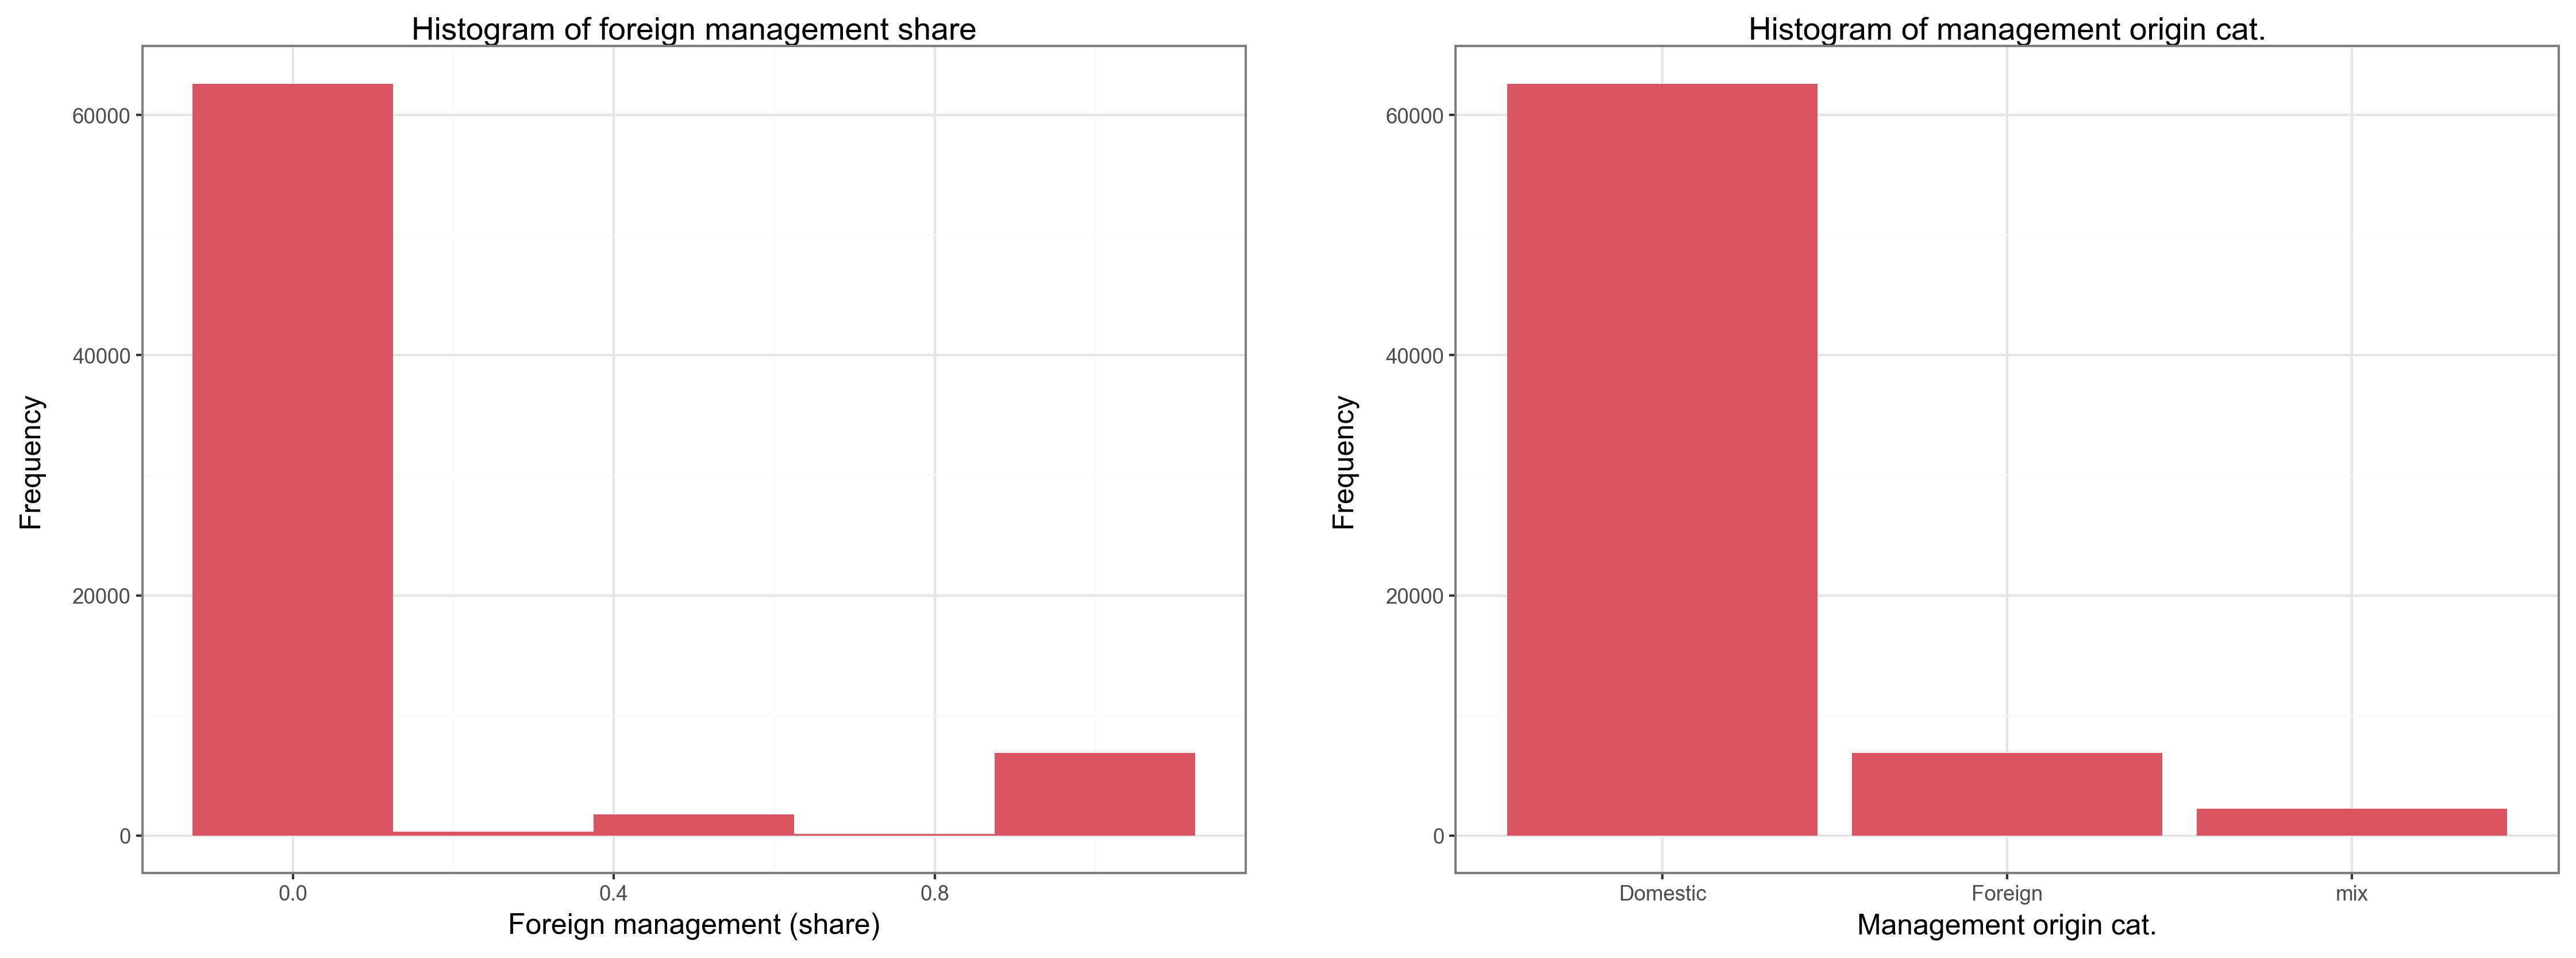

In [24]:
pw.basefigure.clear()
p1 = (
    ggplot(data, aes(x="foreign"))
    + geom_histogram(bins = 5, fill=color[0])
    + labs(title="Histogram of foreign management share", x="Foreign management (share)", y="Frequency")
    + theme_bw()
)

p2 = (
    ggplot(data[data['origin'].notna()], aes(x="origin"))
    + geom_bar(fill=color[0])
    + labs(title="Histogram of management origin cat.", x="Management origin cat.", y="Frequency")
    + theme_bw()
)

display(pw.load_ggplot(p1) | pw.load_ggplot(p2))

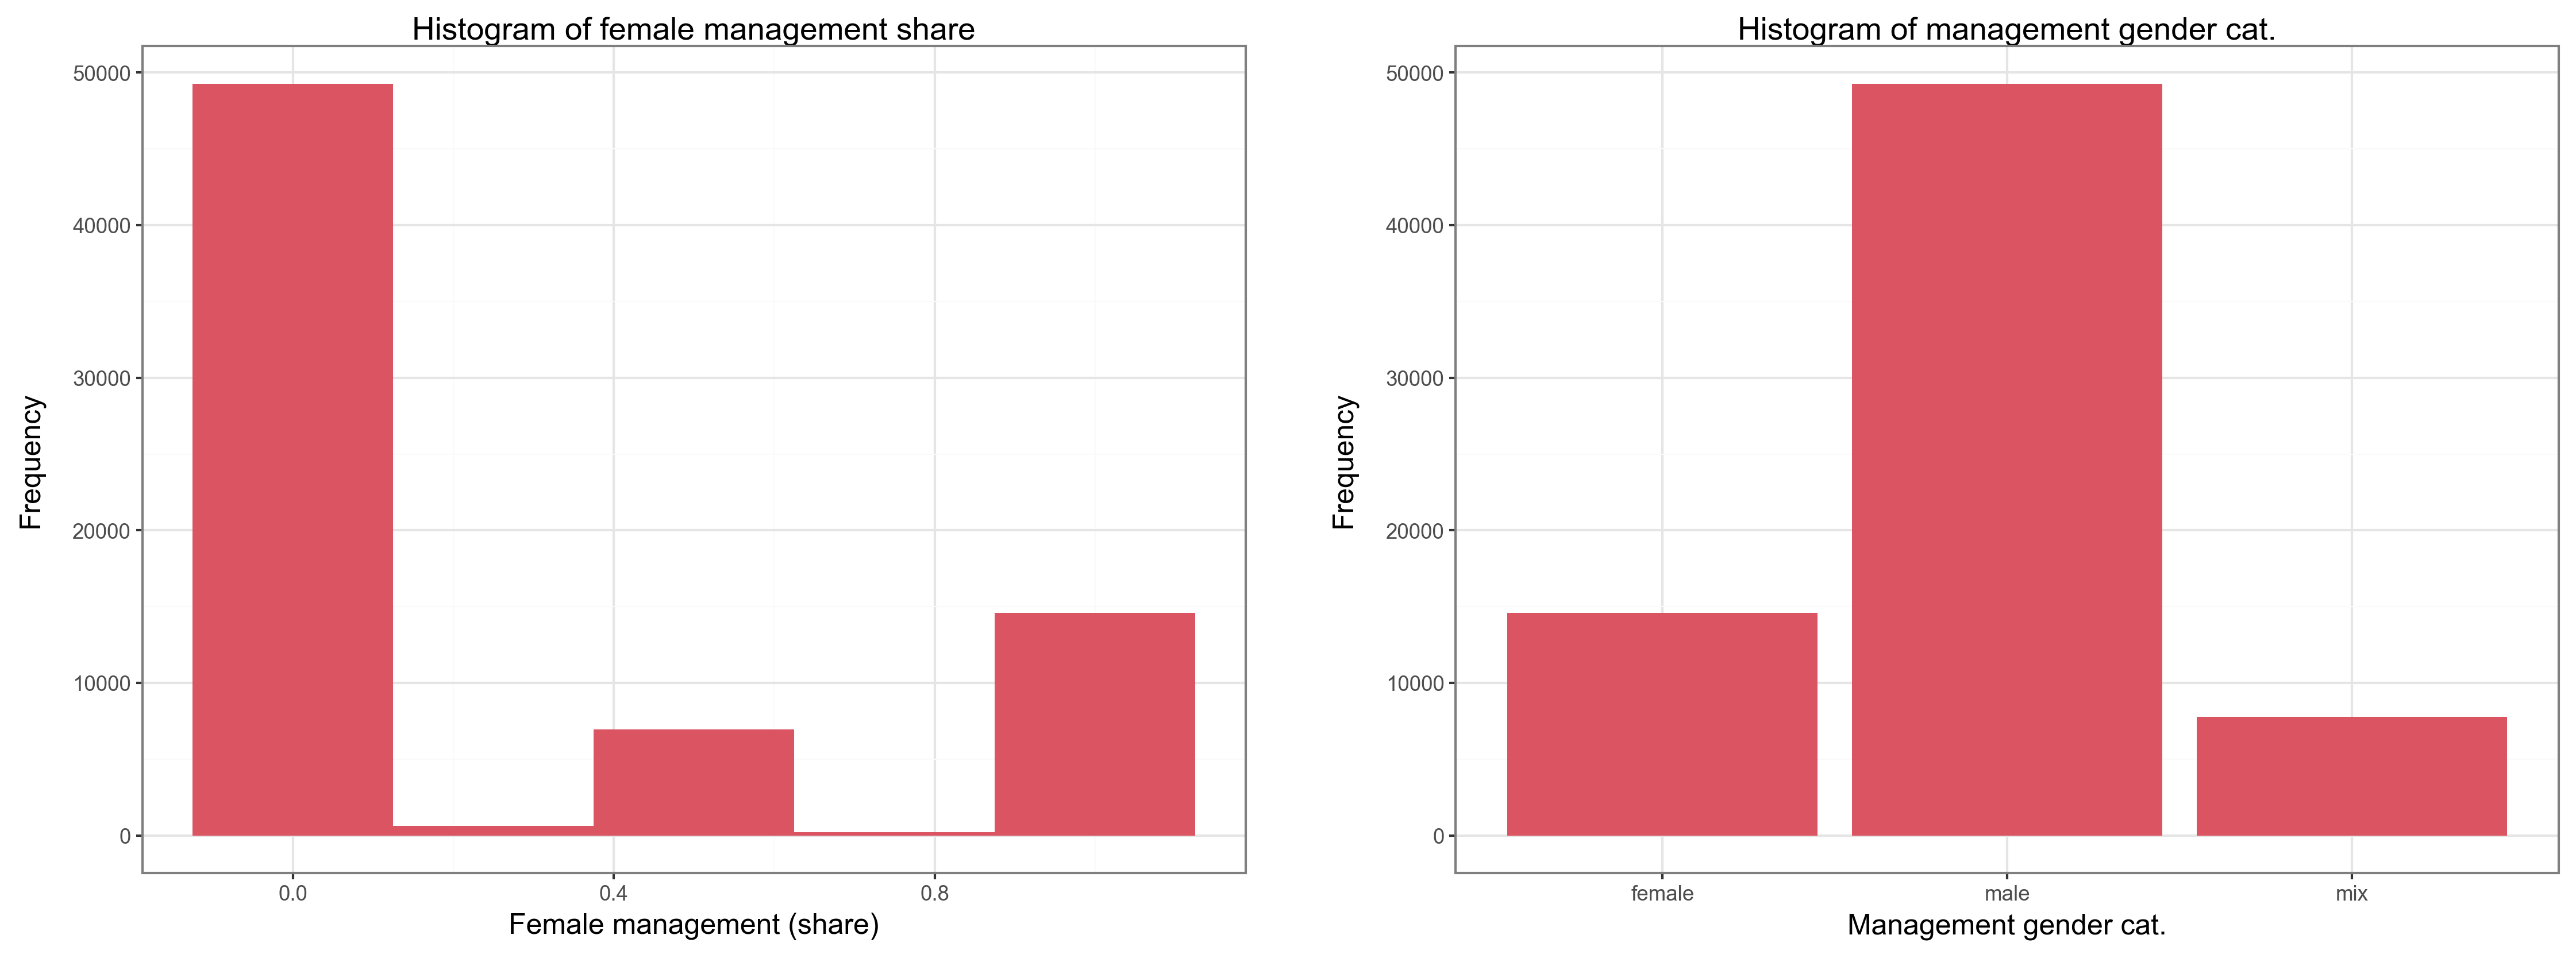

In [25]:
pw.basefigure.clear()
p1 = (
    ggplot(data, aes(x="female"))
    + geom_histogram(bins = 5, fill=color[0])
    + labs(title="Histogram of female management share", x="Female management (share)", y="Frequency")
    + theme_bw()
)

p2 = (
    ggplot(data[data['gender'].notna()], aes(x="gender"))
    + geom_bar(fill=color[0])
    + labs(title="Histogram of management gender cat.", x="Management gender cat.", y="Frequency")
    + theme_bw()
)

display(pw.load_ggplot(p1) | pw.load_ggplot(p2))

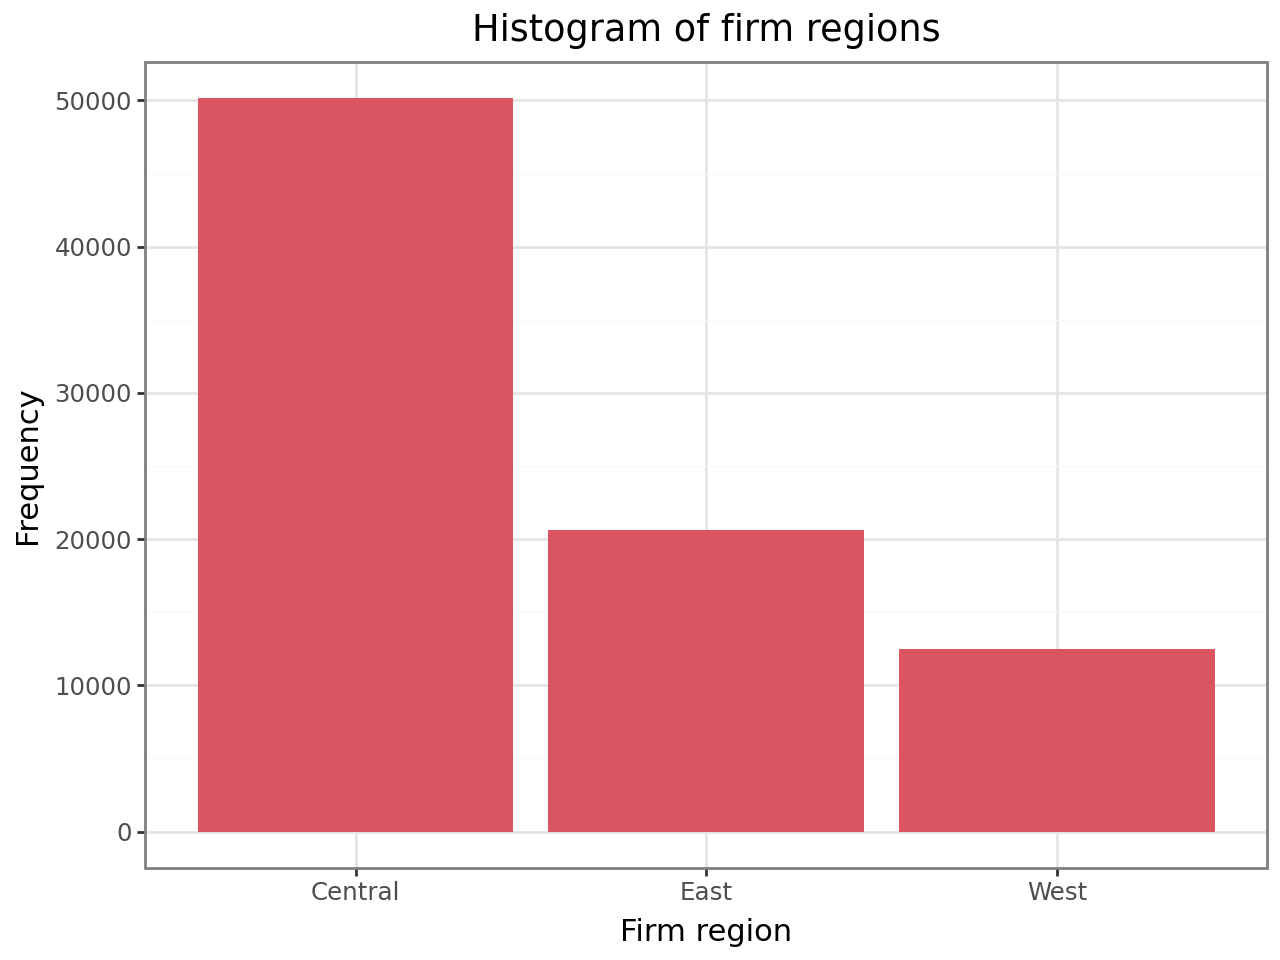

In [26]:
(
    ggplot(data[data['region_m'].notna()], aes(x="region_m"))
    + geom_bar(fill=color[0])
    + labs(title="Histogram of firm regions", x="Firm region", y="Frequency")
    + theme_bw()
)

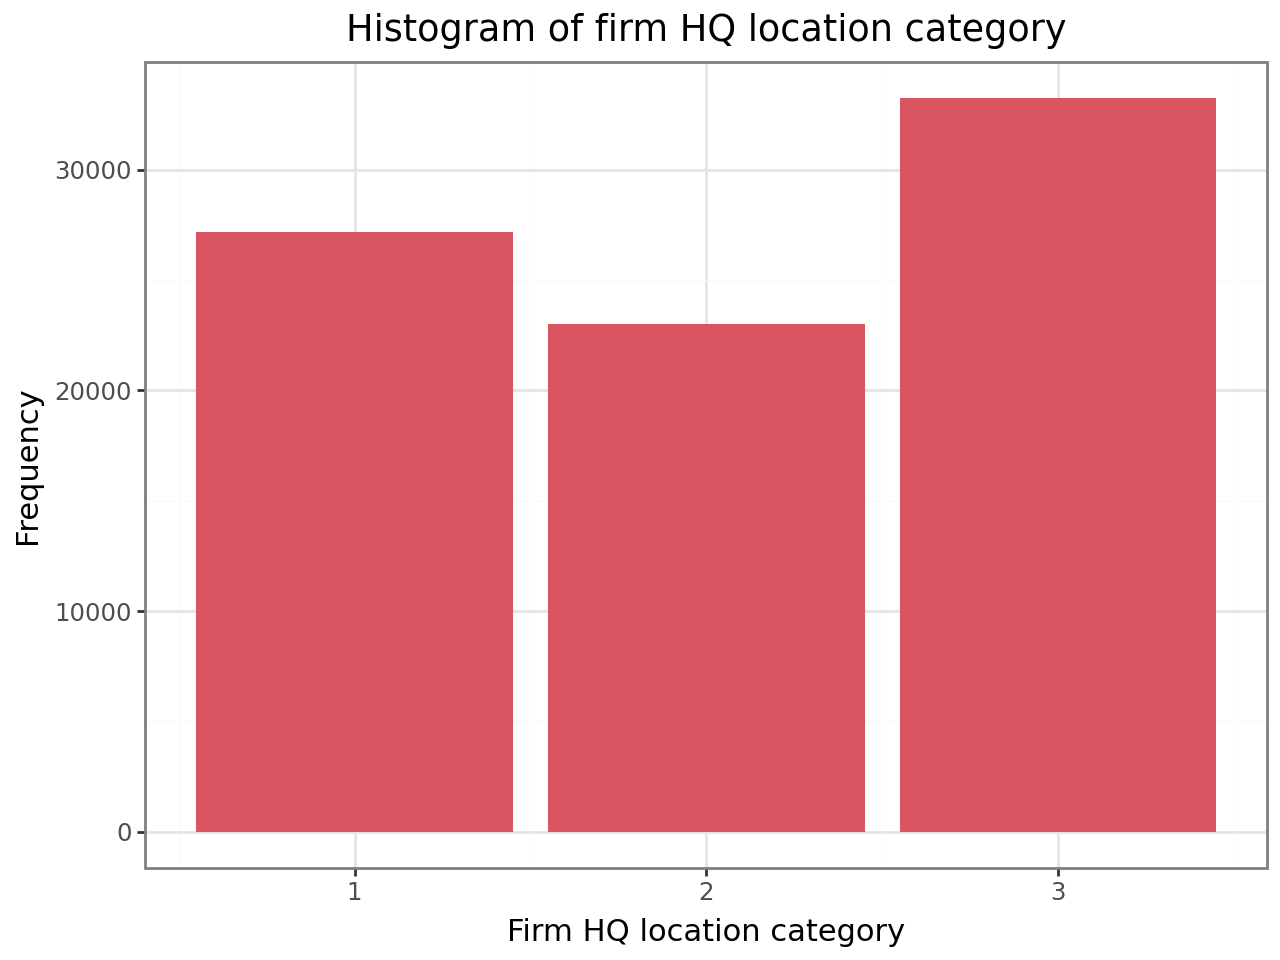

In [27]:
(
    ggplot(data[data['urban_m'].notna()], aes(x="urban_m"))
    + geom_bar(fill=color[0])
    + labs(title="Histogram of firm HQ location category", x="Firm HQ location category", y="Frequency")
    + theme_bw()
)

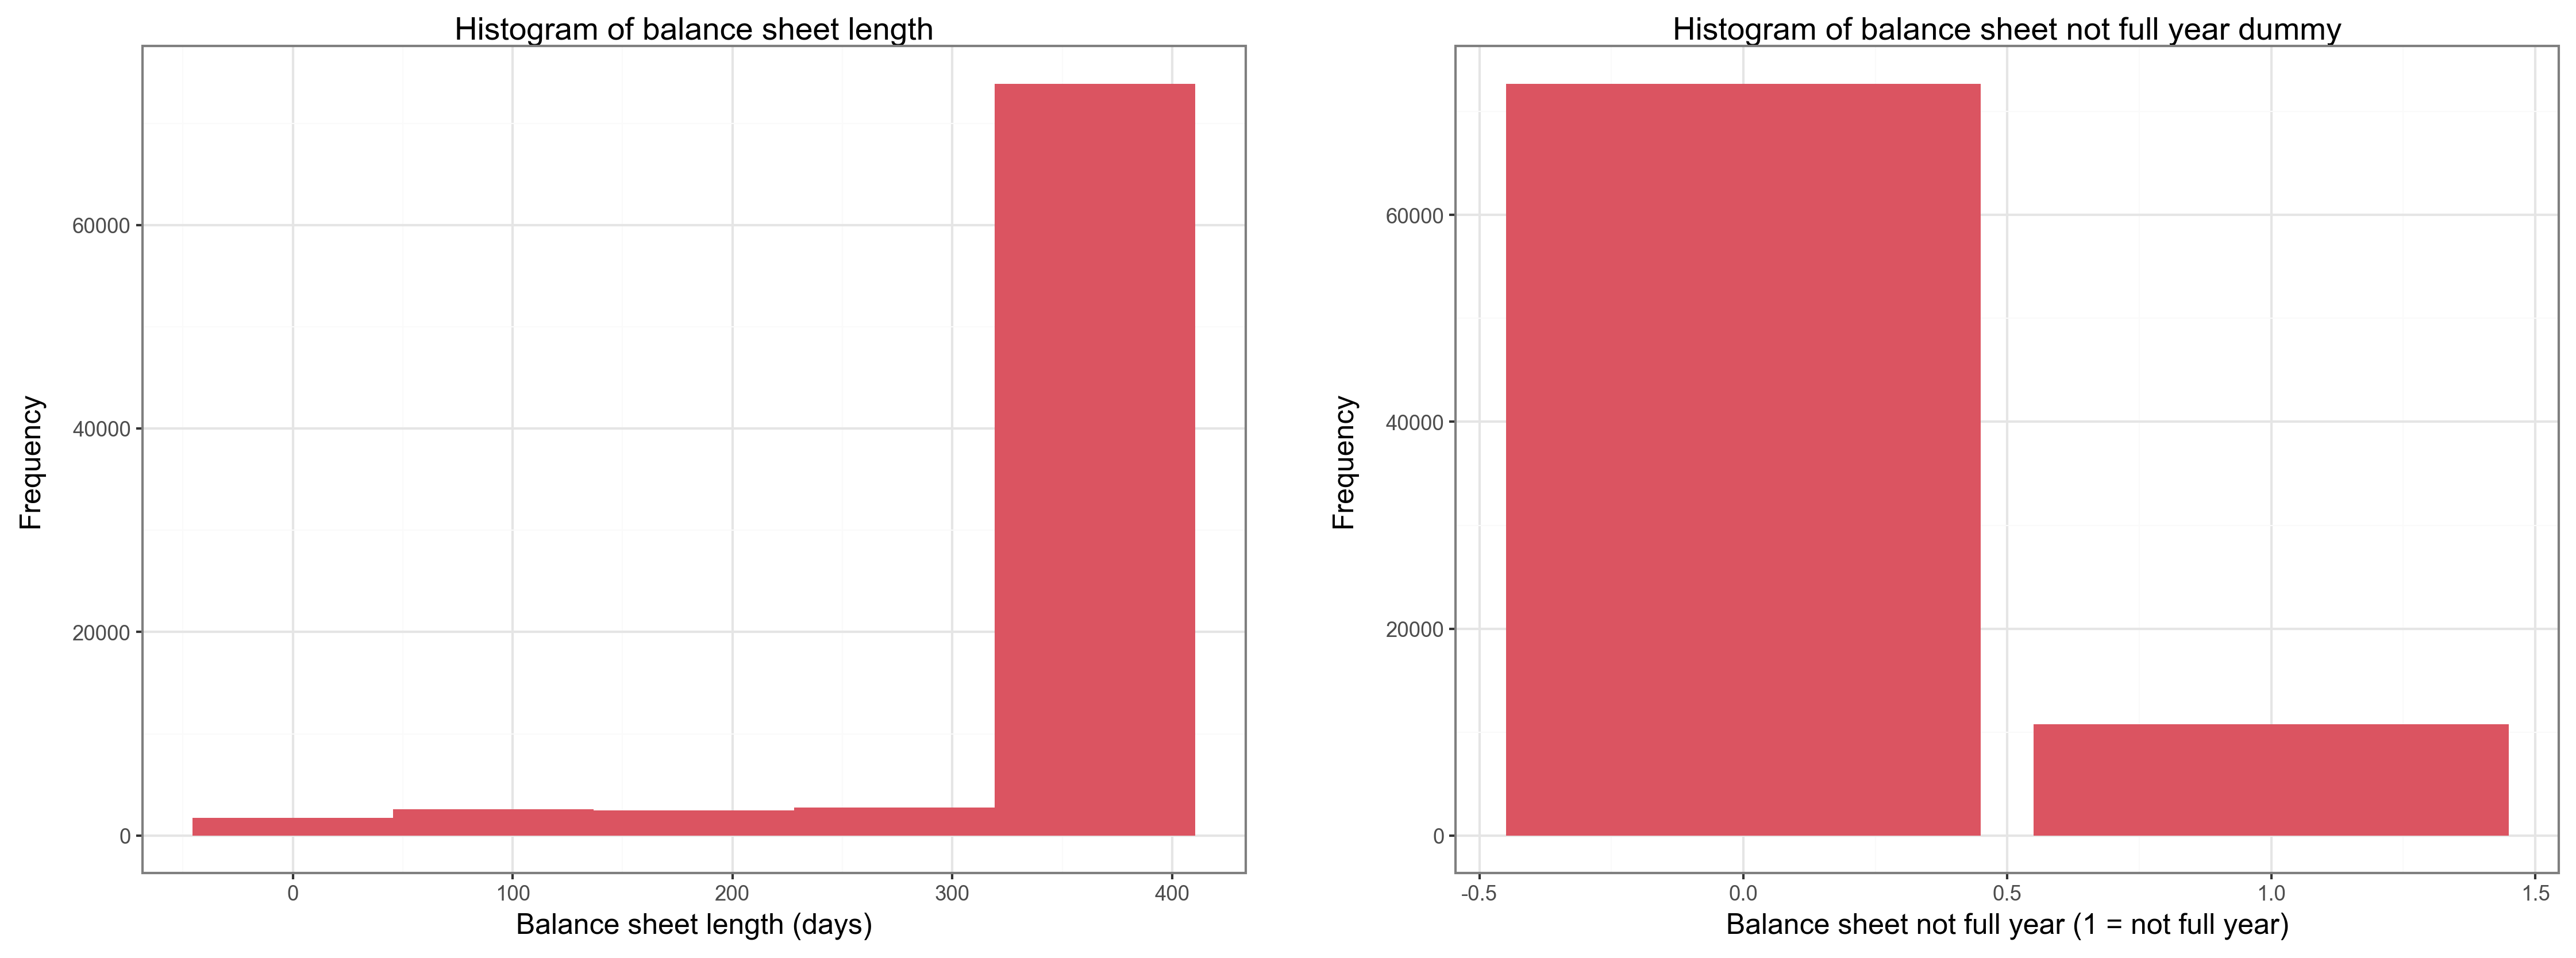

In [28]:
pw.basefigure.clear()
p1 = (
    ggplot(data, aes(x="balsheet_length"))
    + geom_histogram(bins = 5, fill=color[0])
    + labs(title="Histogram of balance sheet length", x="Balance sheet length (days)", y="Frequency")
    + theme_bw()
)

p2 = (
    ggplot(data, aes(x="balsheet_notfullyear"))
    + geom_bar(fill=color[0])
    + labs(title="Histogram of balance sheet not full year dummy", x="Balance sheet not full year (1 = not full year)", y="Frequency")
    + theme_bw()
)

display(pw.load_ggplot(p1) | pw.load_ggplot(p2))

In [29]:
data["b_foreign_management"] = np.where(data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0))
data["b_female_management"] = np.where(data["female"] >= 0.5, 1, np.where(data["female"].isna(), np.nan, 0))
data["f_gender"] = data["gender"].astype("category")
data["f_region_m"] = data["region_m"].astype("category")
data["f_urban_m"] = data["urban_m"].astype("category")
data["f_ind2_cat"] = data["ind2_cat"].astype("category")
data['f_origin'] = data['origin'].astype('category')
data['f_ind'] = data['ind'].astype('category')
data["f_fast_growth"] = data["b_fast_growth"].astype("category")
data["f_fast_growth"] = data["f_fast_growth"].cat.rename_categories(["slow_growth", "fast_growth"])
data.rename(columns = {'balsheet_notfullyear' : 'flag_balsheet_notfullyear'}, inplace = True)

Add flags for negative asset values.

In [30]:
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)

Set negative asset values to 1 to take logs.

In [31]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 1, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 1, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 1, data["fixed_assets"])

Calculate total assets.

In [32]:
data["total_assets_bs"] = (data["intang_assets"] + data["curr_assets"] + data["fixed_assets"])

Add logs of key asset variables. Define log changes in the past two years.

In [33]:
data = data.assign(
    ln_intang_assets=np.where(
        data["intang_assets"] > 0,
        np.log(data["intang_assets"]),
        (np.where(data["intang_assets"].isna(), np.nan, 0)),
    ),
    ln_curr_assets=np.where(
        data["curr_assets"] > 0,
        np.log(data["curr_assets"]),
        (np.where(data["curr_assets"].isna(), np.nan, 0)),
    ),
    ln_fixed_assets=np.where(
        data["fixed_assets"] > 0,
        np.log(data["fixed_assets"]),
        (np.where(data["fixed_assets"].isna(), np.nan, 0)),
    ),
    ln_total_assets=np.where(
        data["total_assets_bs"] > 0,
        np.log(data["total_assets_bs"]),
        (np.where(data["total_assets_bs"].isna(), np.nan, 0)),
    ),
)

asset_vars = ['ln_intang_assets', 'ln_curr_assets', 'ln_fixed_assets', 'ln_total_assets']

for v in asset_vars:
    data[f'd1_{v}'] = data[v] - data.groupby("comp_id")[v].shift(1)
    data[f'd2_{v}'] = data.groupby("comp_id")[v].shift(1) - data.groupby("comp_id")[v].shift(2)
    data[f'd1_{v}'] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data[f'd1_{v}']))
    data[f'd2_{v}'] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data[f'd2_{v}']))
    data[f'd1_{v}'] = np.where(data[f'd1_{v}'].isna(), 0, data[f'd1_{v}'])
    data[f'd2_{v}'] = np.where(data[f'd2_{v}'].isna(), 0, data[f'd2_{v}'])

Add changes for key P&L variables (simple changes as log changes is not possible due to negative values).

In [34]:
pl_vars = ["inc_bef_tax", "inventories", "material_exp", "profit_loss_year", "personnel_exp",]
for v in pl_vars:
    data[f'd1_{v}'] = data[v] - data.groupby("comp_id")[v].shift(1)
    data[f'd2_{v}'] = data.groupby("comp_id")[v].shift(1) - data.groupby("comp_id")[v].shift(2)
    data[f'd1_{v}'] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data[f'd1_{v}']))
    data[f'd2_{v}'] = np.where(data["b_new"] == 1, 0, np.where(data["b_new"].isna(), np.nan, data[f'd2_{v}']))
    data[f'd1_{v}'] = np.where(data[f'd1_{v}'].isna(), 0, data[f'd1_{v}'])
    data[f'd2_{v}'] = np.where(data[f'd2_{v}'].isna(), 0, data[f'd2_{v}'])

Calculate financial ratio variables:

- divide P&L columns with sales;
- divide BS columns with total assets.

In [35]:
pl_names = ["extra_exp","extra_inc","extra_profit_loss","inc_bef_tax","inventories","material_exp","profit_loss_year","personnel_exp"]
bs_names = ["intang_assets","curr_liab","fixed_assets","liq_assets","curr_assets","share_eq","subscribed_cap","tang_assets"]

In [36]:
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [37]:
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

For columns with theoretical 0-1 range:

- create flag for above 1 values, and cap these at 1;
- create flag for negative values, and assign 0.

In [38]:
zero = ["extra_exp_pl","extra_inc_pl","inventories_pl","material_exp_pl","personnel_exp_pl","curr_liab_bs","fixed_assets_bs","liq_assets_bs",
        "curr_assets_bs","subscribed_cap_bs","intang_assets_bs"]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

For columns with theoretical -1 - 1 range:

- create flag for lower than -1 values and assign -1;
- create flag for higher than 1 values and assign 1;
- create flag for 0 values;
- add quadratic values.

In [39]:
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)

Filter dataset for cross-section:

- in year 2012,
- alive firms only,
- sales is between 1000 EUR and 10 M EUR.

In [40]:
data = data[(data['year'] == 2012) & (data['status_alive'] == 1)]
data = data[(data['sales_mil'] <= 10) & (data['sales_mil'] >= 0.001)]

Create CEO age variable, create dummies for low, high and missing values. Floor CEO age at 25 for lower values, cap CEU age at 75 for higher values. Impute missing values with sample mean. Create CEO young dummy for CEO age under 40.

In [41]:
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["b_ceo_young"] = (data["ceo_age"] < 40).astype(int)

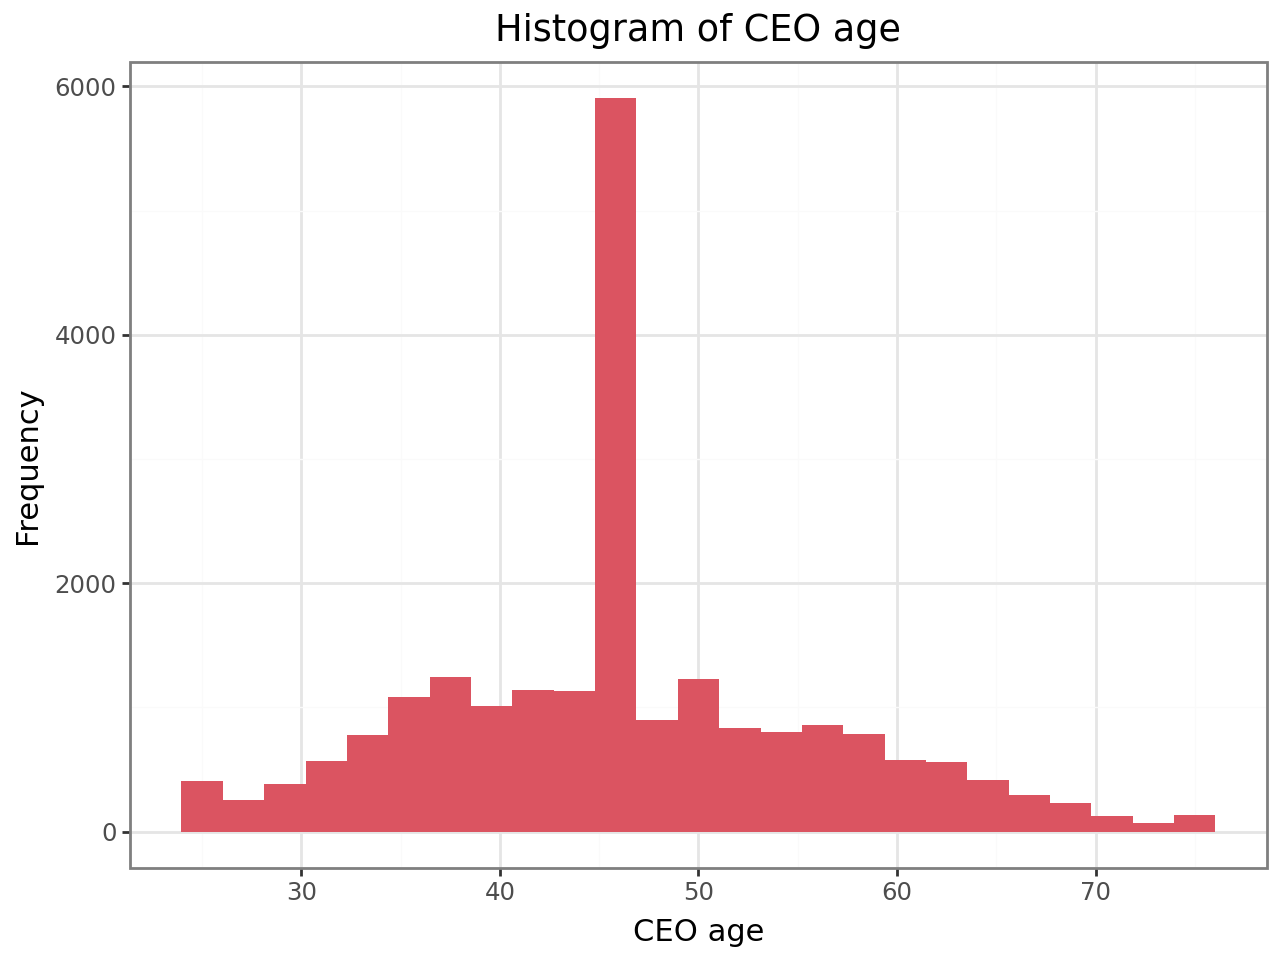

In [42]:
(
    ggplot(data, aes(x="ceo_age"))
    + geom_histogram(bins = 25, fill=color[0])
    + labs(title="Histogram of CEO age", x="CEO age", y="Frequency")
    + theme_bw()
)

Impute yearly average number of employees with mean and add flag for this.

In [43]:
data["labor_avg_mod"] = np.where(data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"])
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [44]:
data = data.drop(["labor_avg"], axis=1)

Drop missing observations which could not be imputed.

In [45]:
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

In [46]:
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "f_region_m"])

Categorize CEO count.

In [47]:
data.ceo_count.value_counts()

ceo_count
1.0     14297
2.0      4189
3.0       470
4.0        65
5.0        10
6.0         4
15.0        1
Name: count, dtype: int64

In [48]:
f_ceo = pd.cut(data['ceo_count'].to_list(),
   pd.IntervalIndex.from_tuples([(0, 2), (2, 3), (3, max(data.ceo_count)+1)], closed="left"),
   labels=['1', '2', '2+'])
f_ceo = f_ceo.rename_categories([0, 1, 2])
data['f_ceo_count'] = f_ceo

Remove unused categories.

In [49]:
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

Remove flags with no variation.

In [50]:
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

Balance sheet length could be dropped, as it is well captured by the balance sheet not full year dummy.

In [51]:
data.drop(columns = ['begin', 'end', 'founded_year', 'founded_date', 'exit_year', 'exit_date', 'birth_year',
                     'cagr_2y', 'cagr_mean', 'cagr_std', 'status_alive', 'ind', 'ind2', 'ind2_cat', 'nace_main',
                     'origin', 'urban_m', 'region_m', 'ceo_count', 'foreign', 'female', 'gender', 'balsheet_length'], inplace = True)

In [52]:
pd.set_option('display.max_rows', None)
data.describe().T

count          mean           std  \
year                            19036.0  2.012000e+03  0.000000e+00   
comp_id                         19036.0  1.529275e+11  1.377319e+11   
amort                           19036.0  9.274374e+03  4.975021e+04   
curr_assets                     19036.0  9.914862e+04  4.377075e+05   
curr_liab                       19036.0  8.567028e+04  4.202974e+05   
extra_exp                       19036.0  4.180172e+02  7.141930e+03   
extra_inc                       19036.0  1.641894e+03  3.283540e+04   
extra_profit_loss               19036.0  1.220200e+03  3.212567e+04   
fixed_assets                    19036.0  1.451590e+05  1.105861e+06   
inc_bef_tax                     19036.0  5.869079e+03  1.305634e+05   
intang_assets                   19036.0  3.365268e+03  5.193336e+04   
inventories                     19036.0  2.568260e+04  2.042495e+05   
liq_assets                      19036.0  2.458475e+04  1.507502e+05   
material_exp                    19036.0  1.676940e+05  5.583467e+05   
personnel_exp                   19036.0  5.353874e+04  2.108434e+05   
profit_loss_year                19036.0  5.230908e+02  1.152969e+05   
sales                           19036.0  2.357734e+05  7.704825e+05   
share_eq                        19036.0  9.144960e+04  5.644930e+05   
subscribed_cap                  19036.0  3.030463e+04  2.609142e+05   
tang_assets                     19036.0  1.334858e+05  1.059669e+06   
balsheet_flag                   19036.0  2.048750e-03  4.521791e-02   
flag_balsheet_notfullyear       19036.0  5.242698e-02  2.228924e-01   
inoffice_days                   19036.0  3.010447e+03  1.719525e+03   
b_fast_growth                   19036.0  1.248161e-01  3.305190e-01   
ln_sales                        19036.0  1.075797e+01  1.705081e+00   
sales_mil                       19036.0  2.357734e-01  7.704825e-01   
ln_sales_mil                    19036.0 -3.057544e+00  1.705081e+00   
d1_ln_sales_mil                 19036.0 -8.498686e-02  8.764572e-01   
d2_ln_sales_mil                 19036.0  3.042702e-02  1.121916e+00   
age                             19036.0  8.701828e+00  6.924531e+00   
b_new                           19036.0  1.858584e-01  3.890026e-01   
b_foreign_management            19036.0  1.057995e-01  3.075890e-01   
b_female_management             19036.0  3.109372e-01  4.628893e-01   
flag_asset_problem              19036.0  6.829166e-04  2.612443e-02   
total_assets_bs                 19036.0  2.476728e+05  1.315972e+06   
ln_intang_assets                19036.0  1.053811e+00  2.687378e+00   
ln_curr_assets                  19036.0  9.345988e+00  2.131539e+00   
ln_fixed_assets                 19036.0  7.213787e+00  4.544758e+00   
ln_total_assets                 19036.0  1.013877e+01  2.189317e+00   
d1_ln_intang_assets             19036.0 -2.019808e-02  1.332856e+00   
d2_ln_intang_assets             19036.0  1.028033e-02  1.357538e+00   
d1_ln_curr_assets               19036.0  7.390210e-04  1.027706e+00   
d2_ln_curr_assets               19036.0  8.064654e-02  9.539927e-01   
d1_ln_fixed_assets              19036.0 -1.645084e-02  1.698985e+00   
d2_ln_fixed_assets              19036.0  1.980435e-01  1.875217e+00   
d1_ln_total_assets              19036.0  3.177958e-03  8.093391e-01   
d2_ln_total_assets              19036.0  9.316131e-02  7.685200e-01   
d1_inc_bef_tax                  19036.0  1.068172e+03  1.321162e+05   
d2_inc_bef_tax                  19036.0  4.724430e+02  1.024338e+05   
d1_inventories                  19036.0  1.803186e+03  8.478519e+04   
d2_inventories                  19036.0  2.609082e+03  7.831966e+04   
d1_material_exp                 19036.0  2.031560e+03  2.148597e+05   
d2_material_exp                 19036.0  1.354893e+04  2.514655e+05   
d1_profit_loss_year             19036.0  1.607936e+03  1.269006e+05   
d2_profit_loss_year             19036.0 -7.490160e+02  9.816039e+04   
d1_personnel_exp                19036.0  1.661174e+03  4.6

In [53]:
pd.reset_option('display.max_rows')

Let's create winsorized variables now. As I have 66 variables, I resort to the simpler approach: the winsorization frame is defined by the 5th and 95th percentiles. Unwinsorized LOWESS estimates are not included as they took up a lot of space, but they validated the need for winsorization.

In [54]:
num_cols = []
for c in data.columns:
    if 'flag' not in c and c[0:2] != 'b_' and c[0:2] != 'f_' and c not in ['year', 'comp_id']:
        num_cols.append(c)

In [55]:
len(num_cols)

66

I only winsorize variables for which I did not set upper and lower bounds before. For those that have a 0 minimum, I only winsorize on the higher end.

In [56]:
hl_winsor = list(set(num_cols) - set(anyof) - set(['ceo_age']) - set(zero))
h_winsor = [c for c in hl_winsor if data[c].min() == 0]
hl_winsor = list(set(hl_winsor) - set(h_winsor))

In [57]:
toplot = []
for v in hl_winsor:
    low = np.quantile(data[v], 0.05)
    high = np.quantile(data[v], 0.95)
    data[f'flag_low_{v}'] = np.where(data[v] < low, 1, 0)
    data[f'flag_high_{v}'] = np.where(data[v] > high, 1, 0)
    data[f'{v}_wins']= np.where(
        data[v] < low,
        low,
        np.where(
            data[v] > high,
            high,
            data[v])
    )
    toplot.append(f'{v}_wins')

for v in h_winsor:
    high = np.quantile(data[v], 0.95)
    data[f'flag_high_{v}'] = np.where(data[v] > high, 1, 0)
    data[f'{v}_wins']= np.where(
            data[v] > high,
            high,
            data[v])
    toplot.append(f'{v}_wins')

toplot = toplot + zero + anyof + ['ceo_age']

In [58]:
toplot.sort()

Let's look at LOWESS plots now for quantitative columns (winsorized if applicable).

age_wins


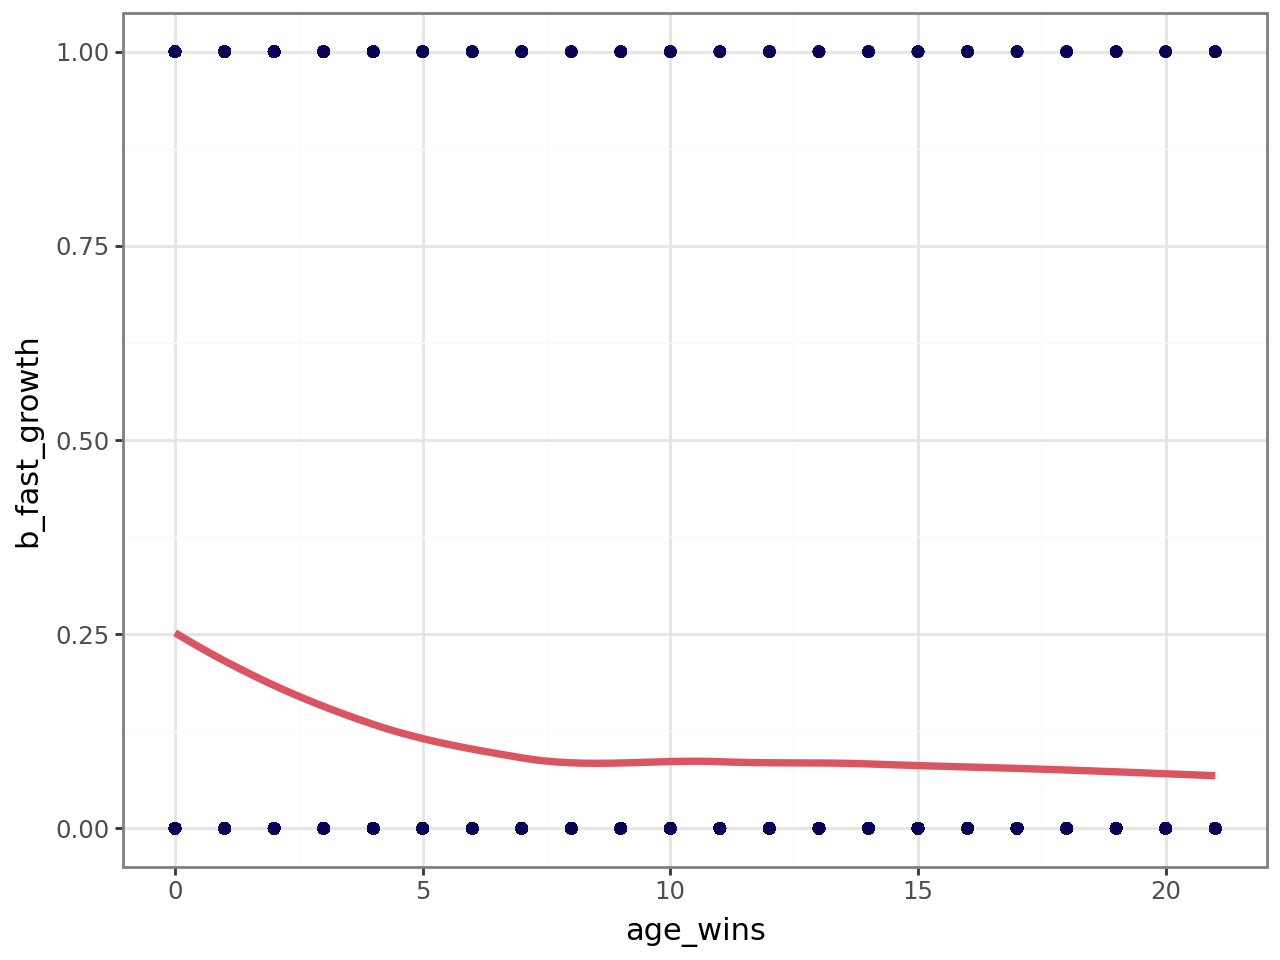

amort_wins


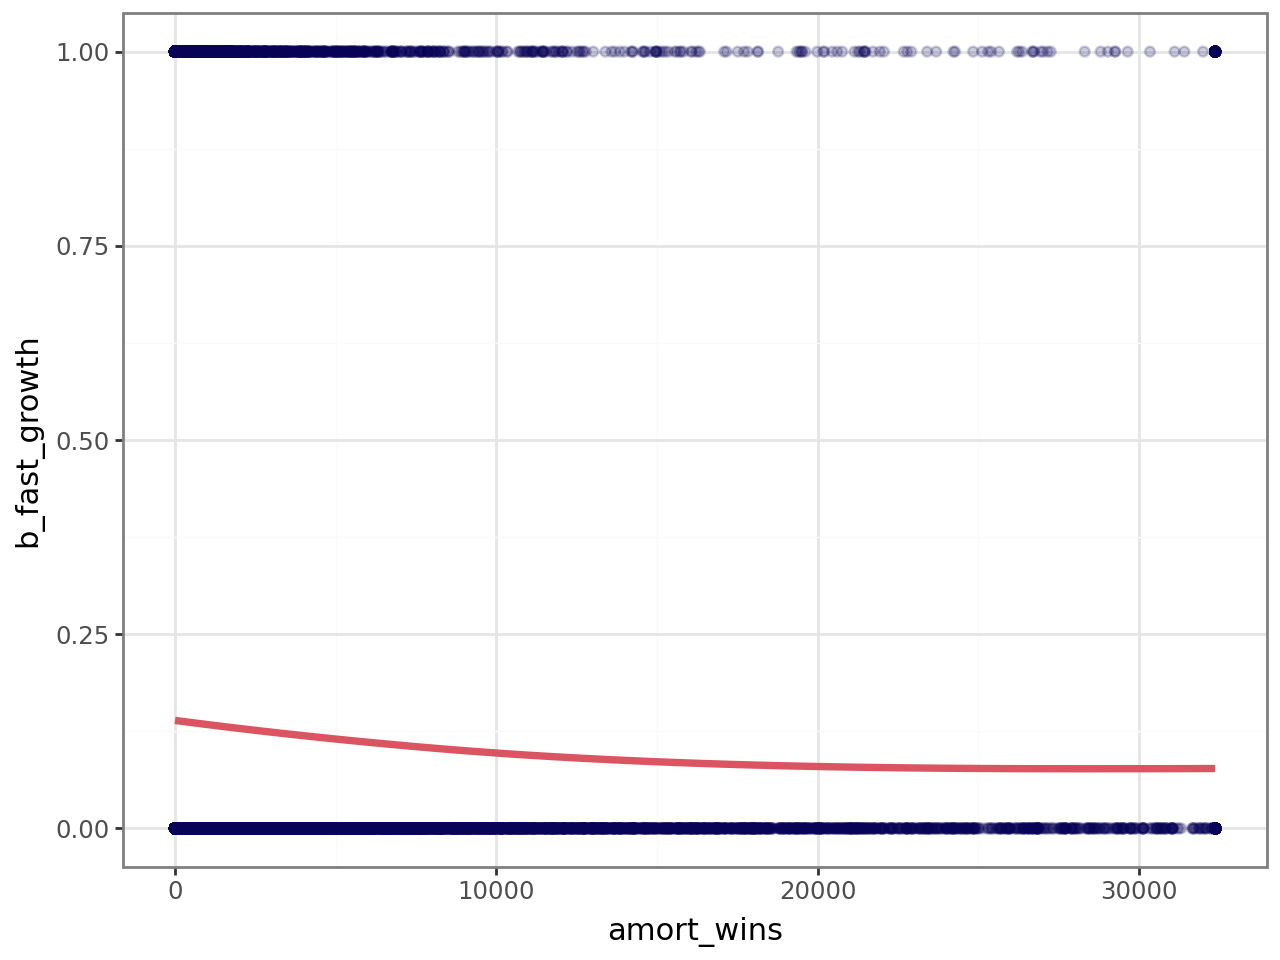

ceo_age


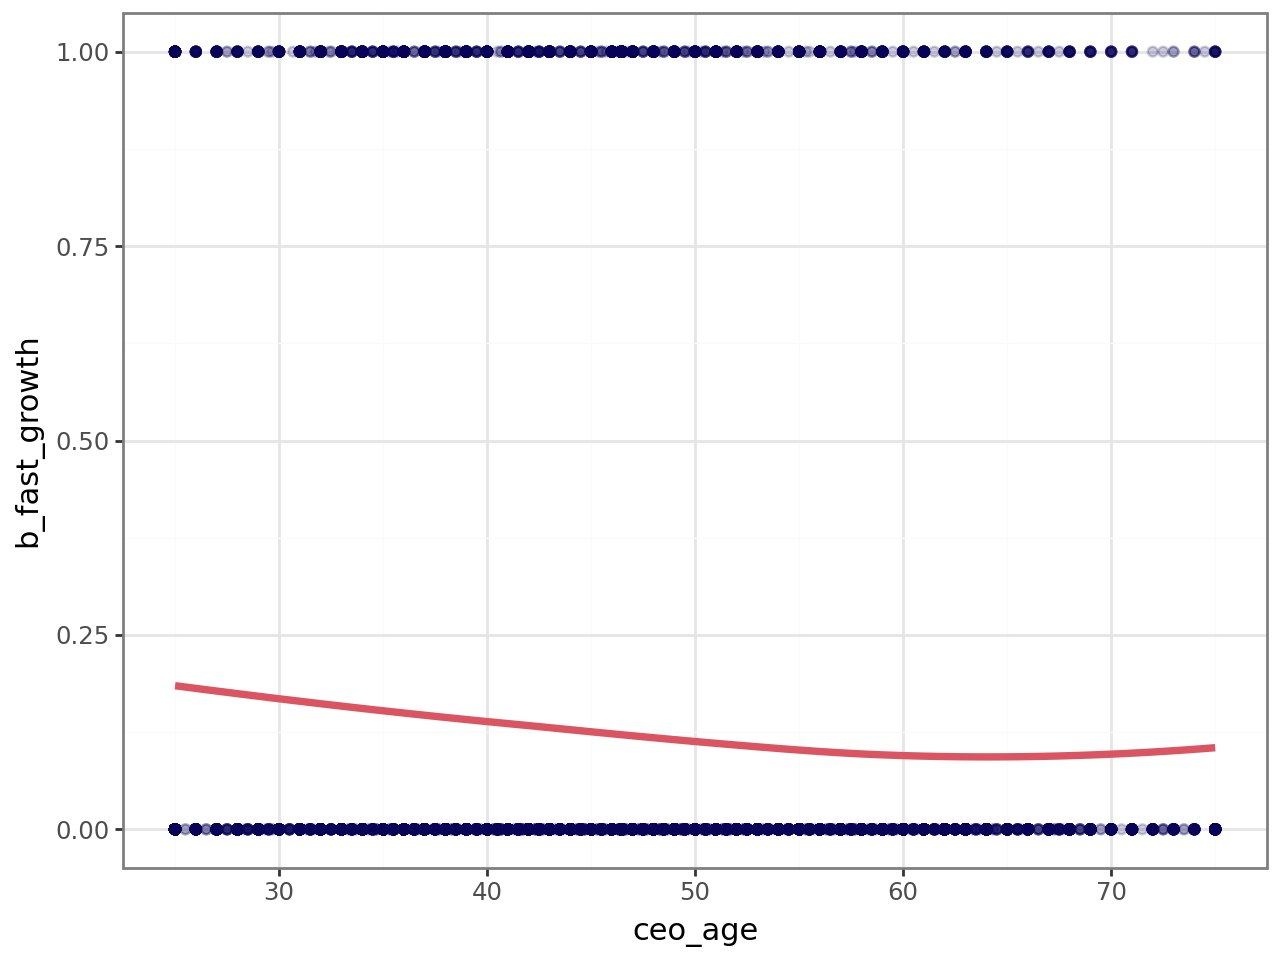

curr_assets_bs


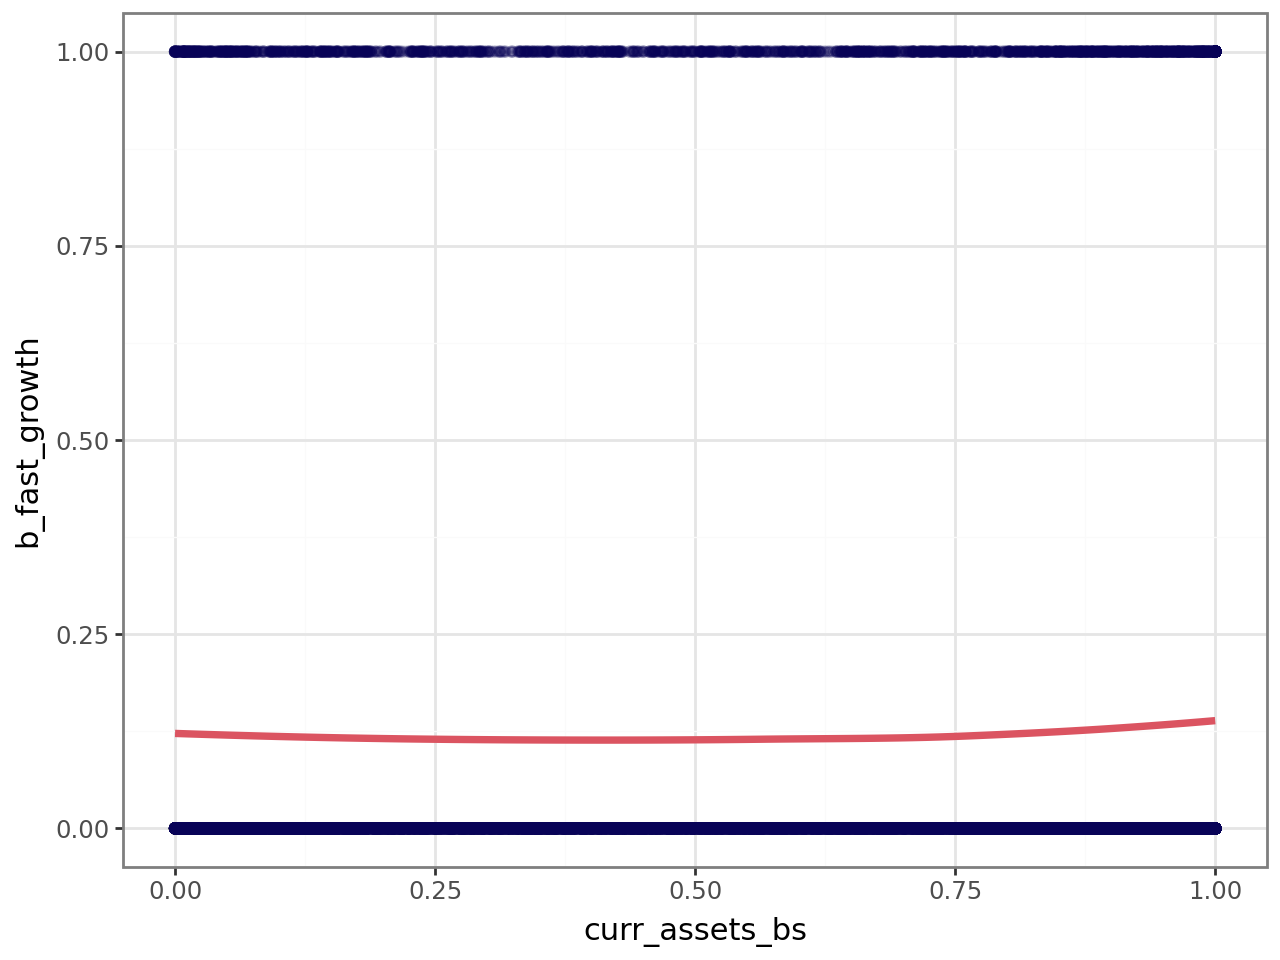

curr_assets_wins


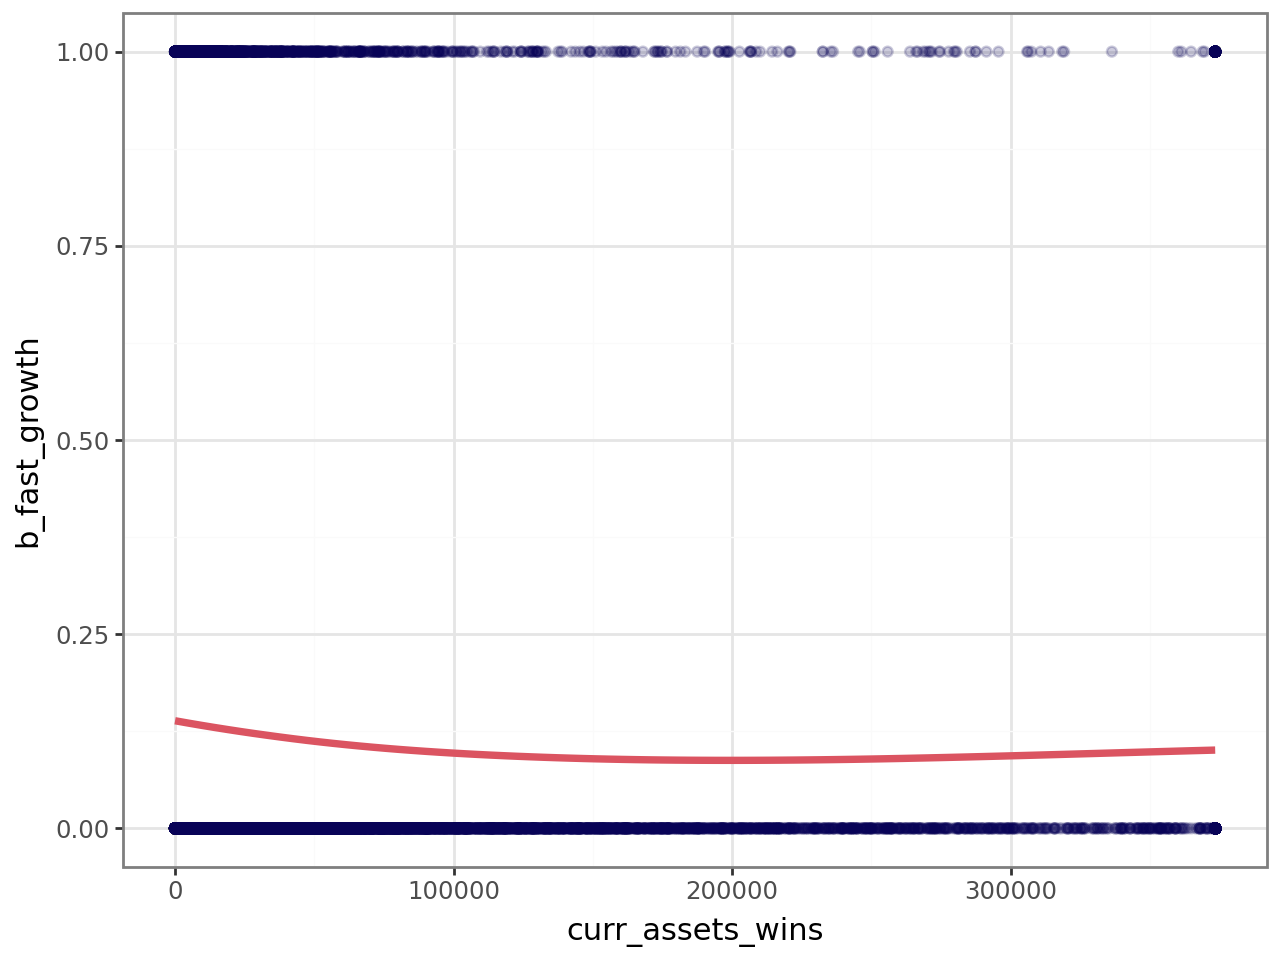

curr_liab_bs


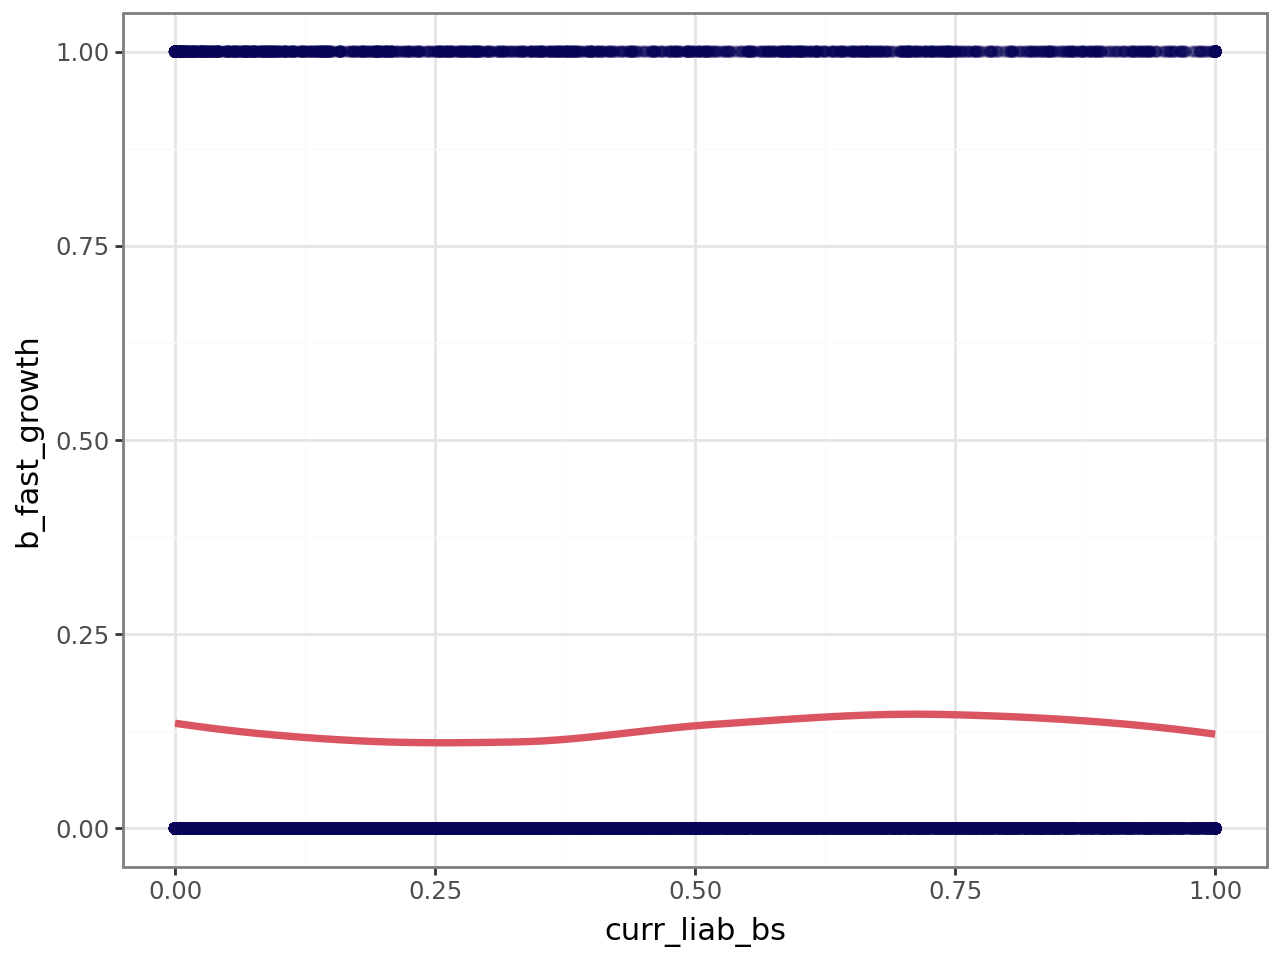

curr_liab_wins


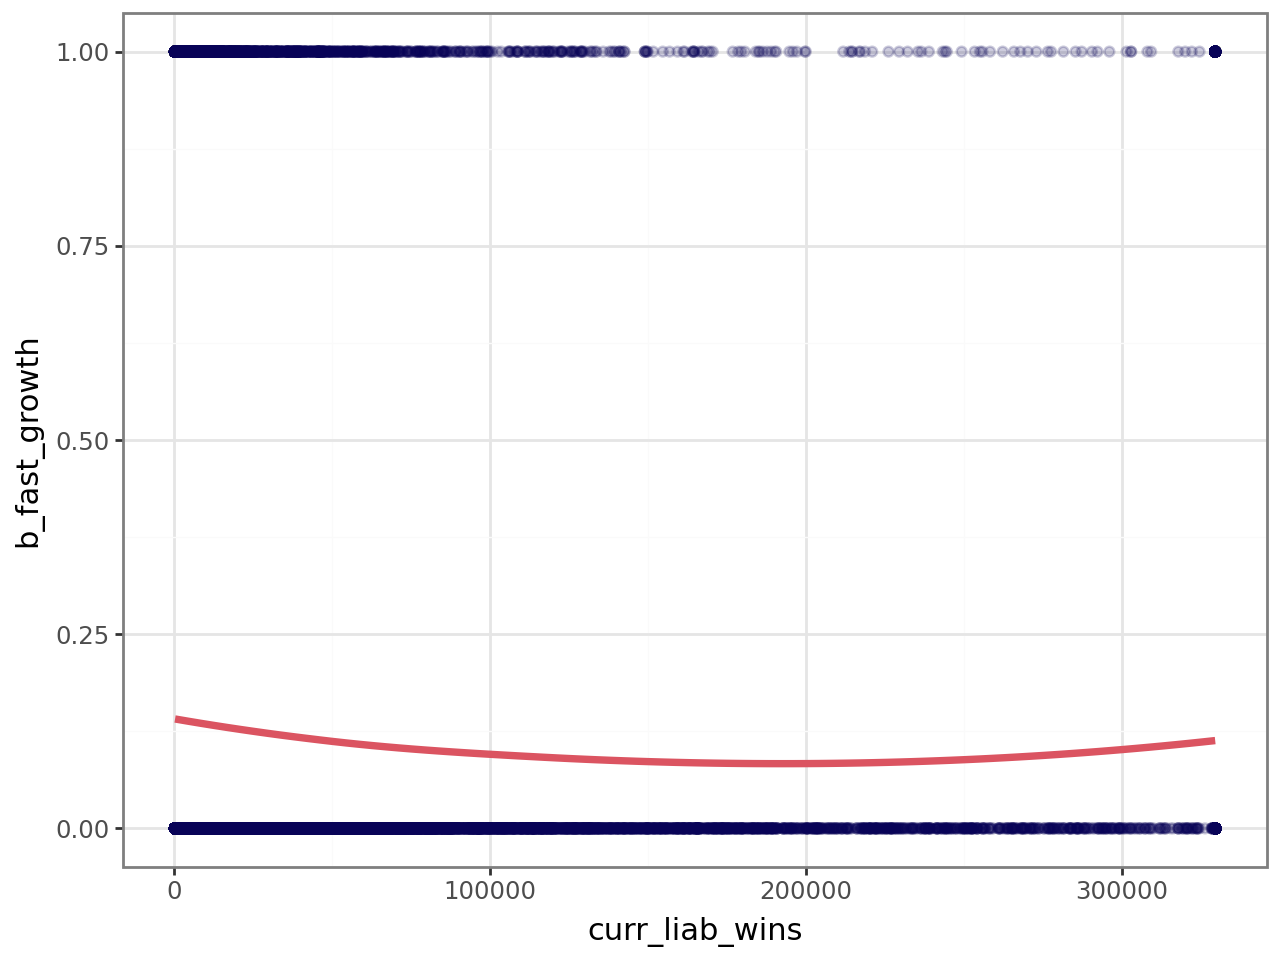

d1_inc_bef_tax_wins


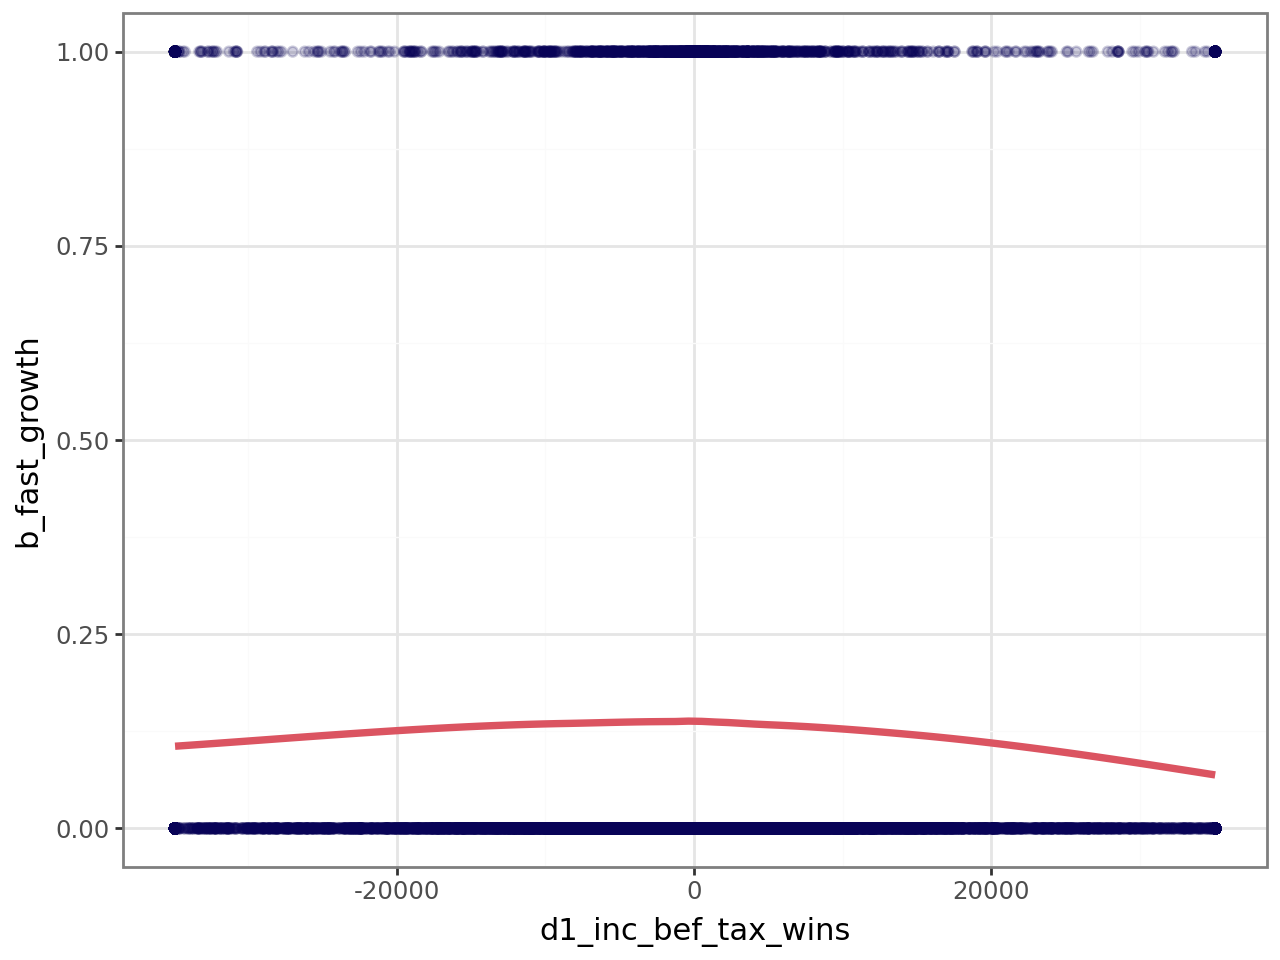

d1_inventories_wins


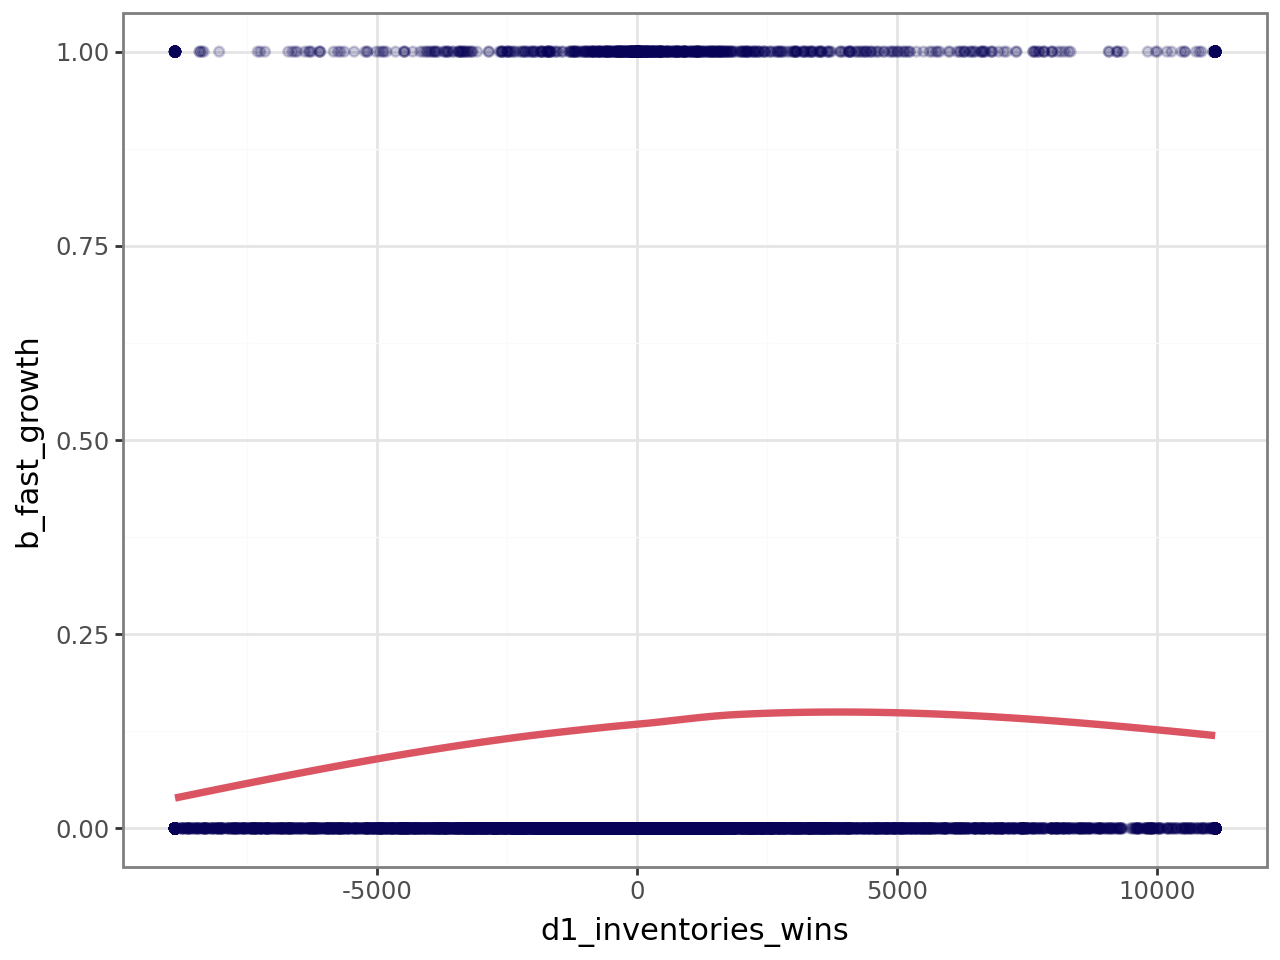

d1_ln_curr_assets_wins


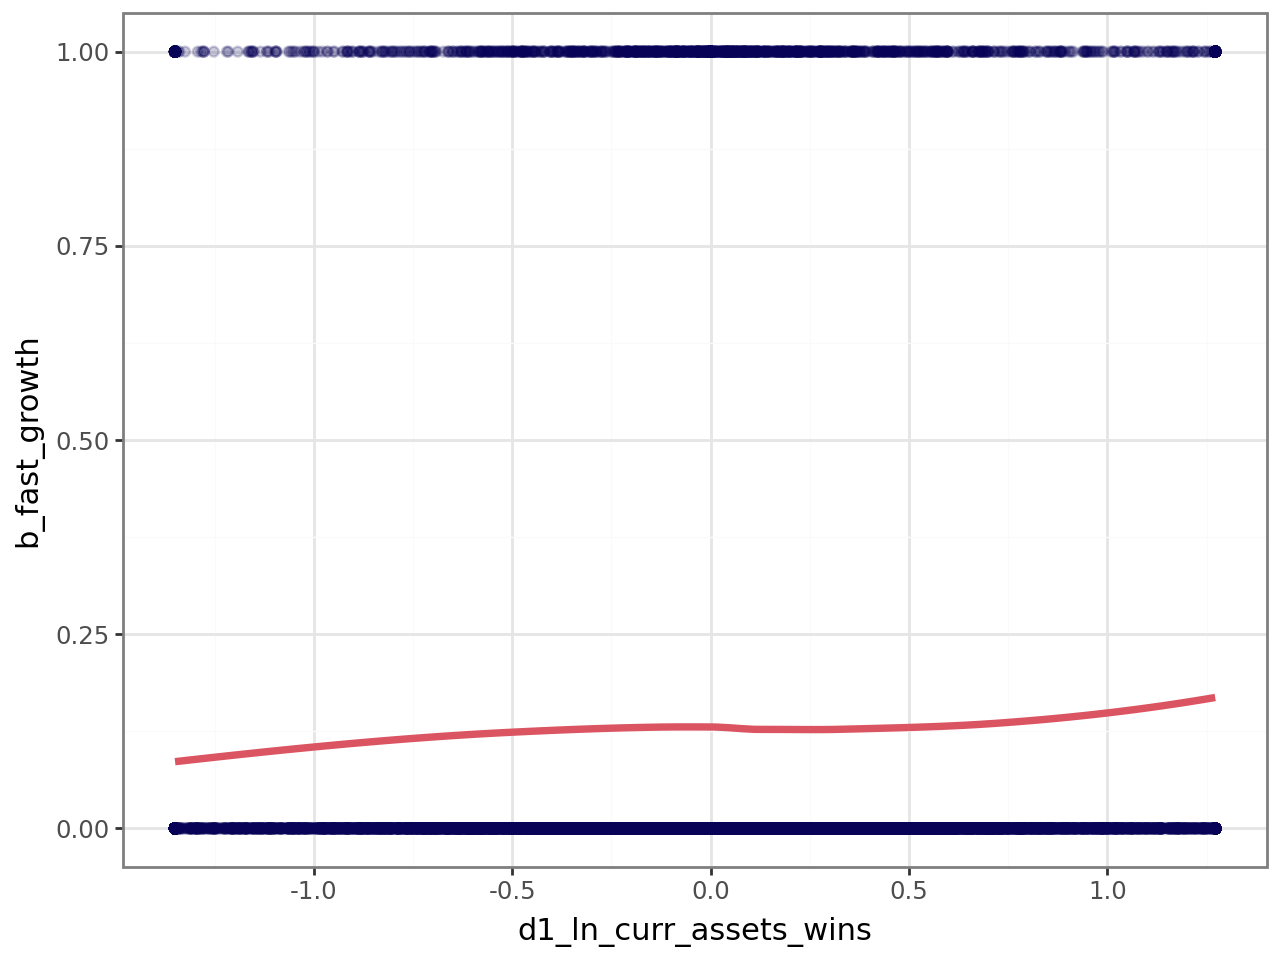

d1_ln_fixed_assets_wins


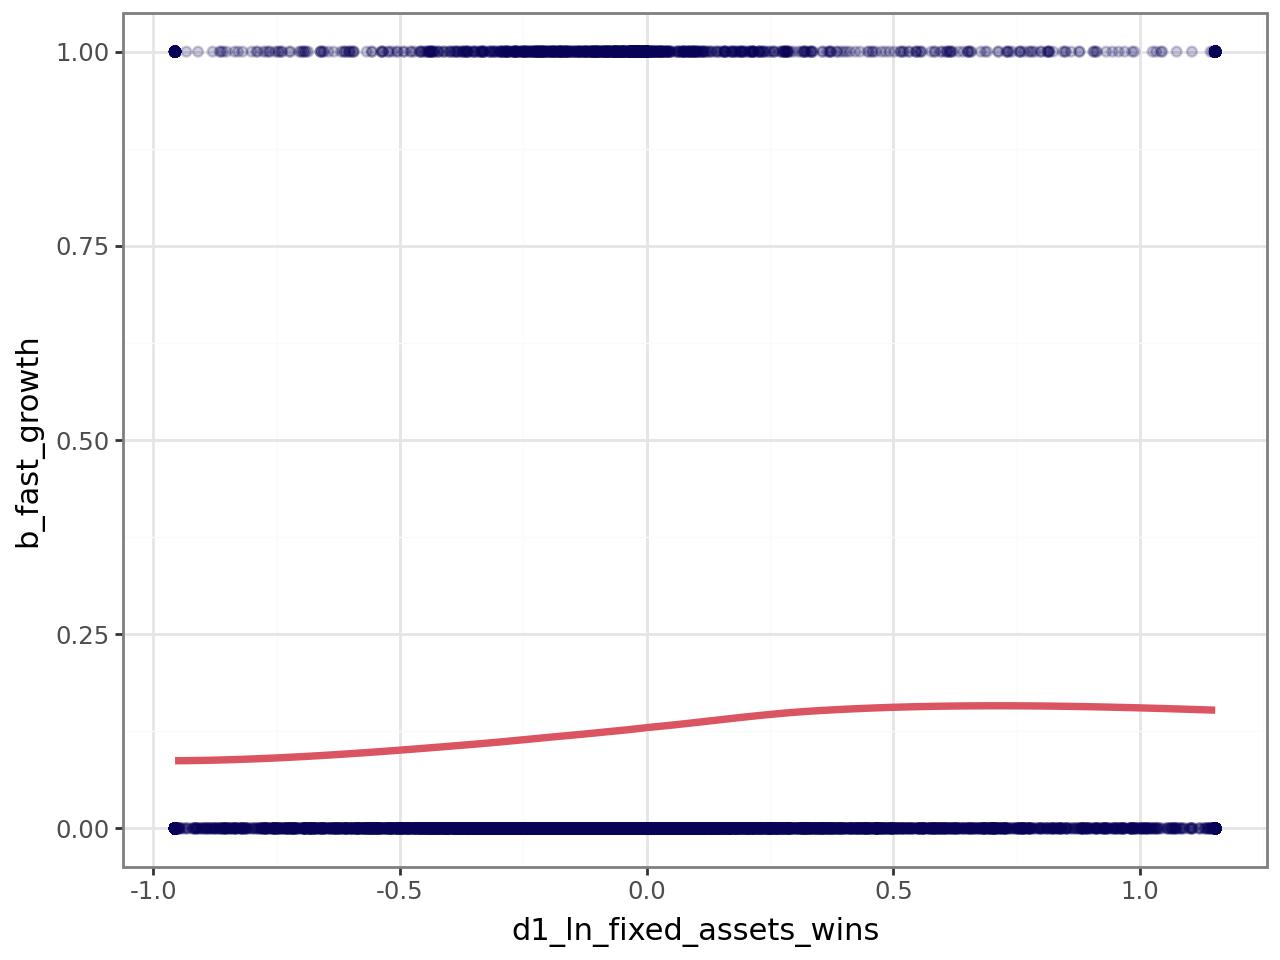

d1_ln_intang_assets_wins


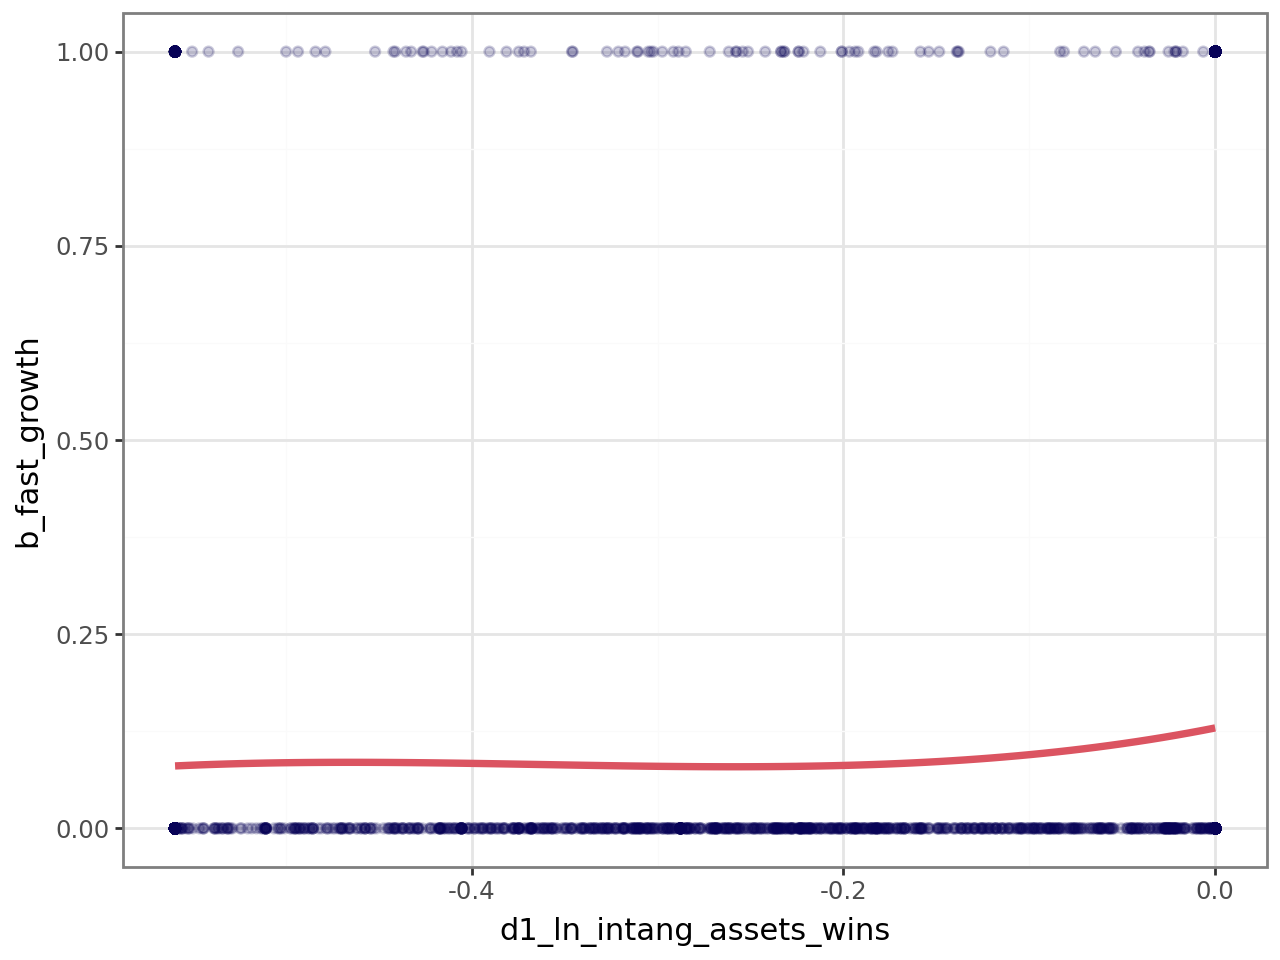

d1_ln_sales_mil_wins


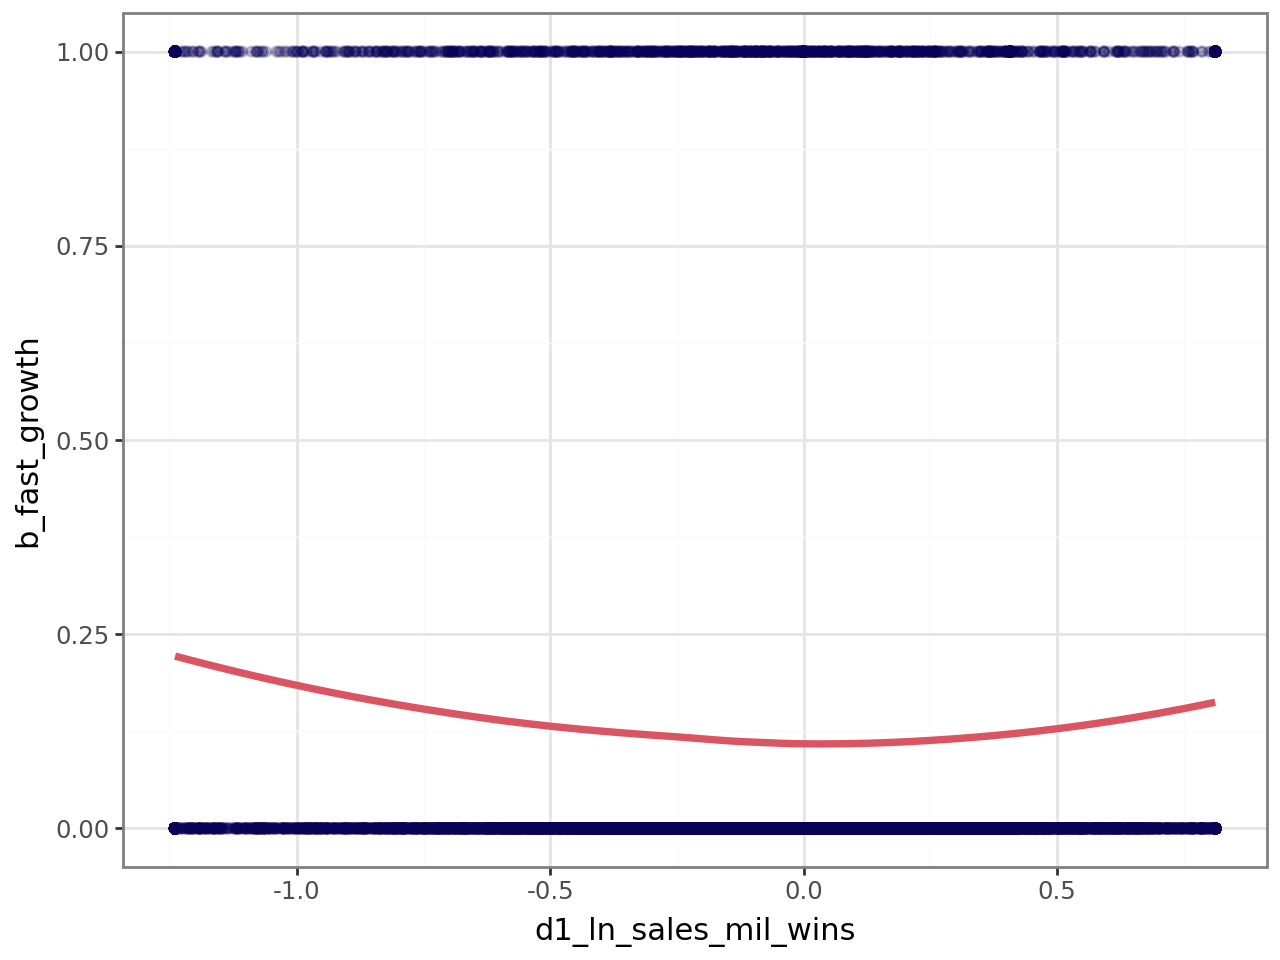

d1_ln_total_assets_wins


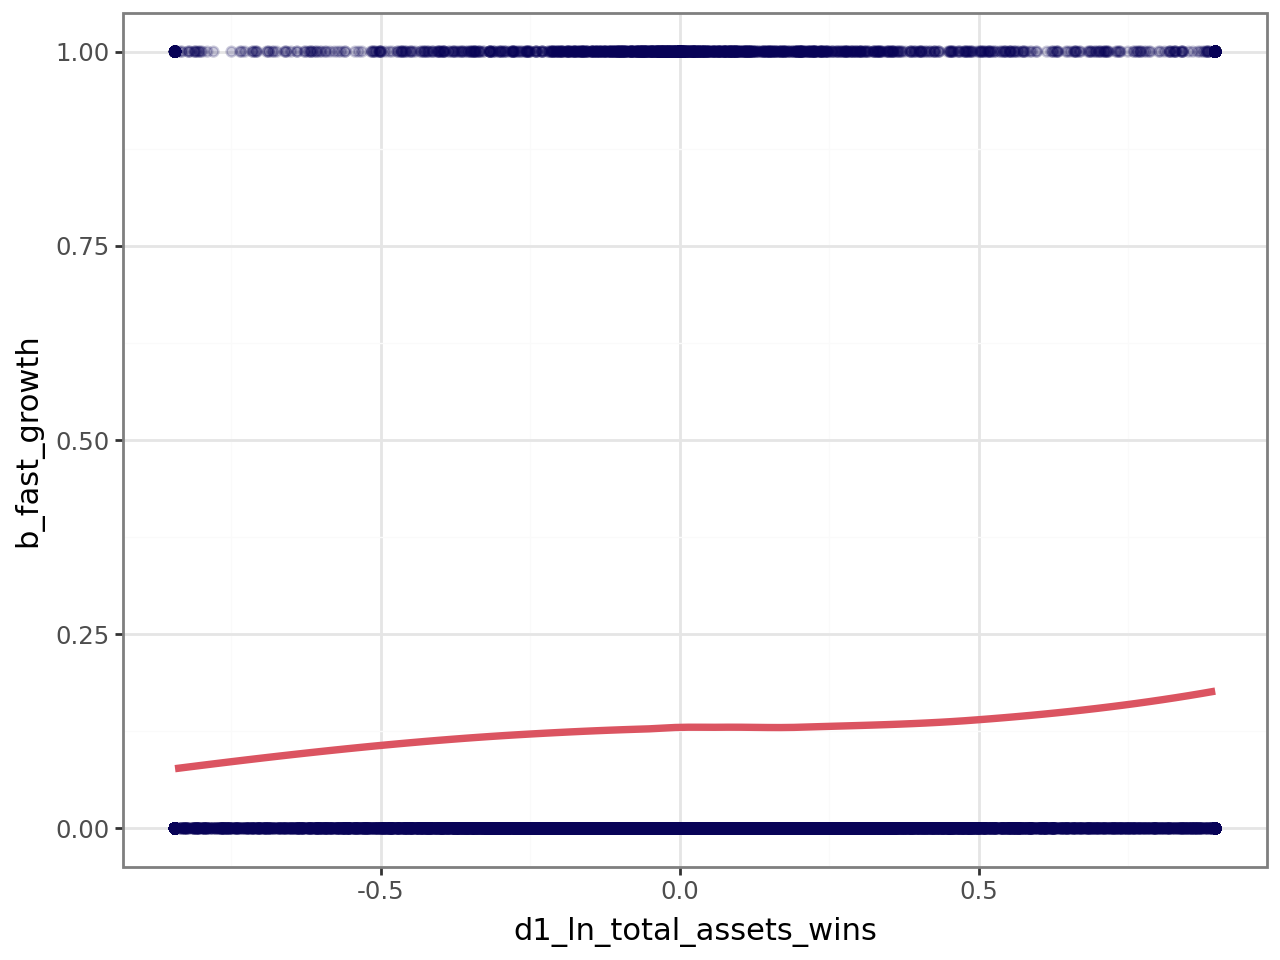

d1_material_exp_wins


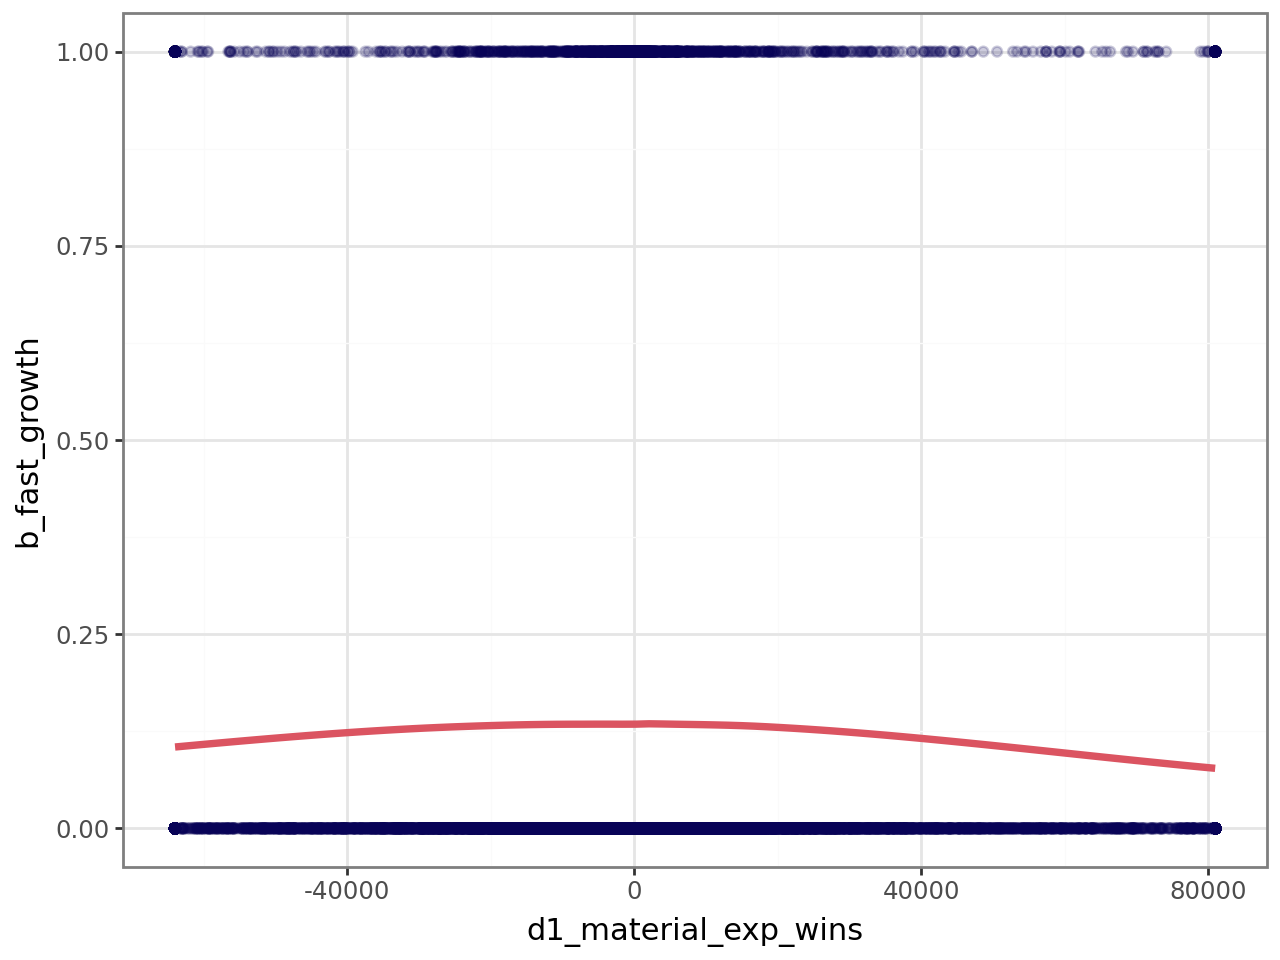

d1_personnel_exp_wins


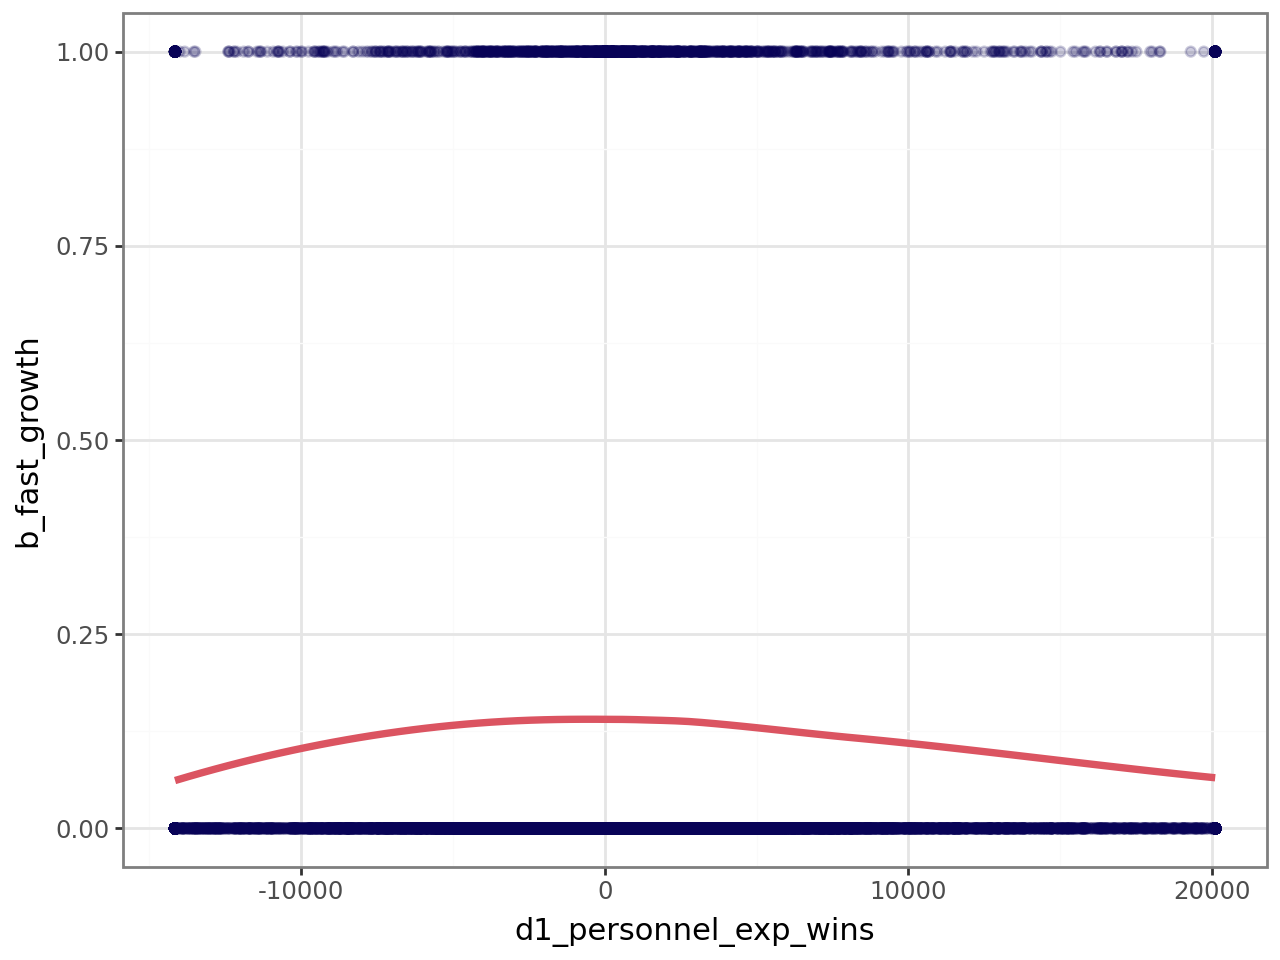

d1_profit_loss_year_wins


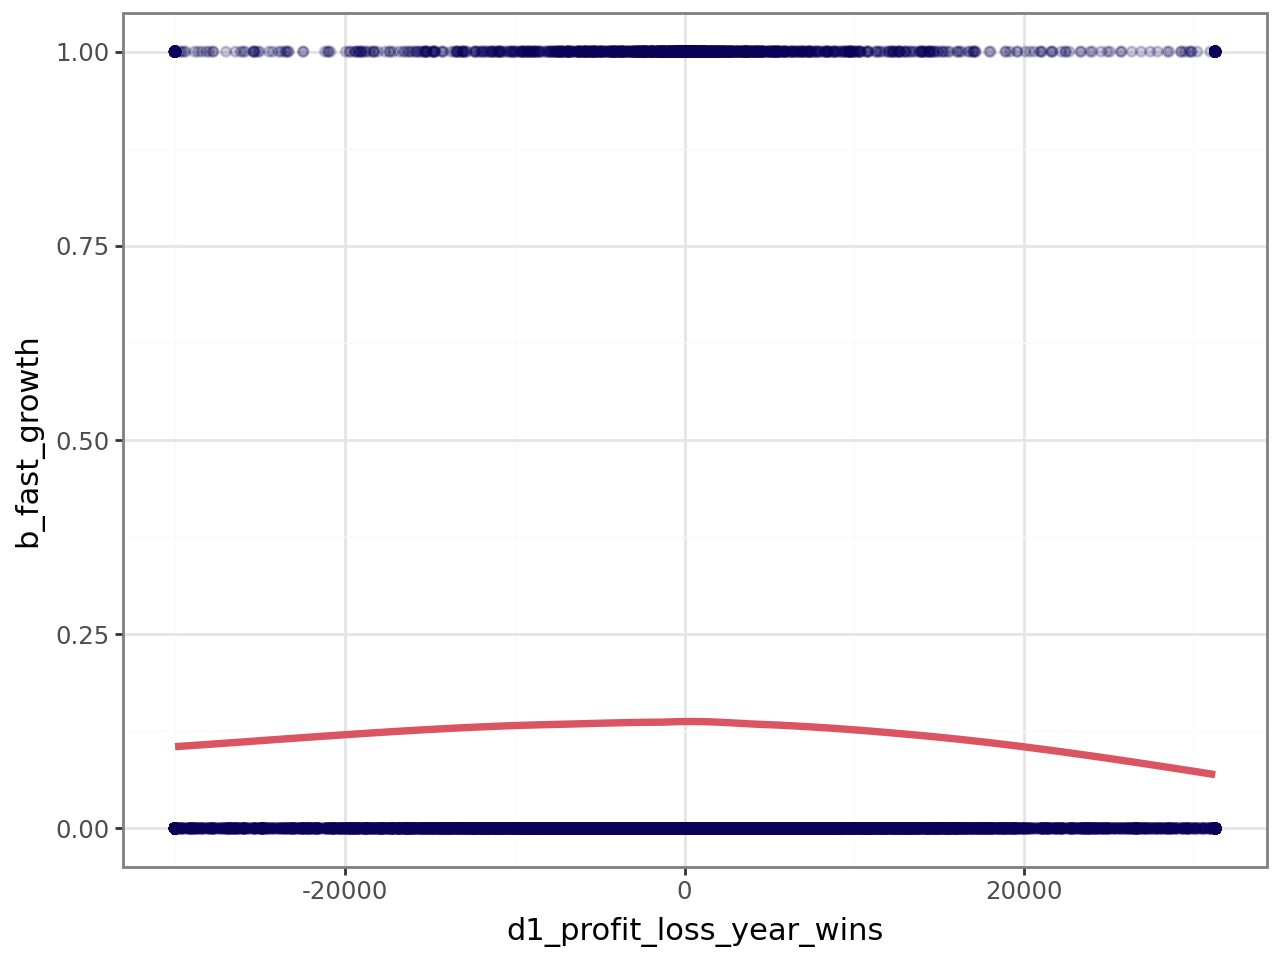

d2_inc_bef_tax_wins


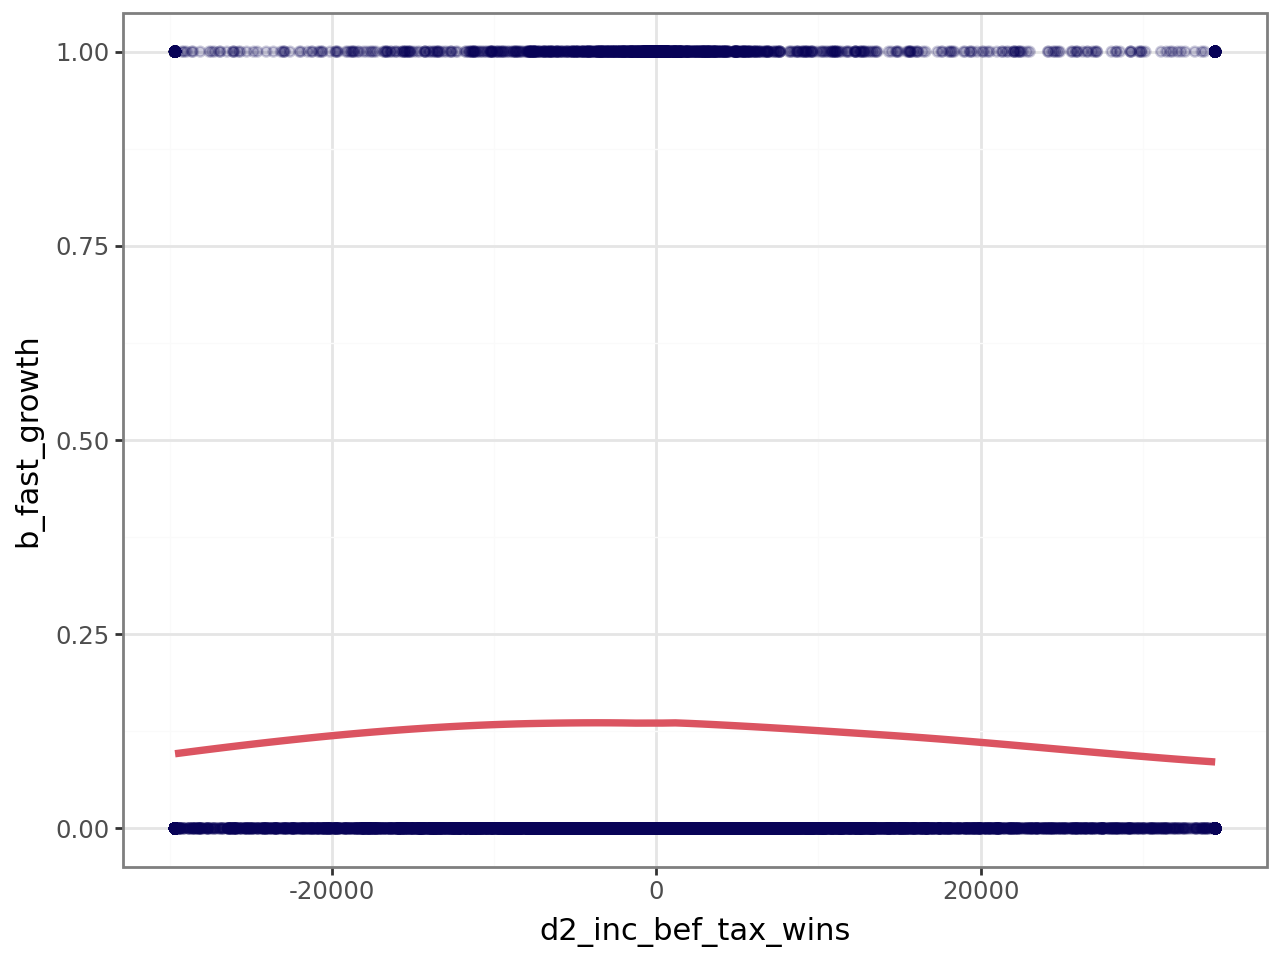

d2_inventories_wins


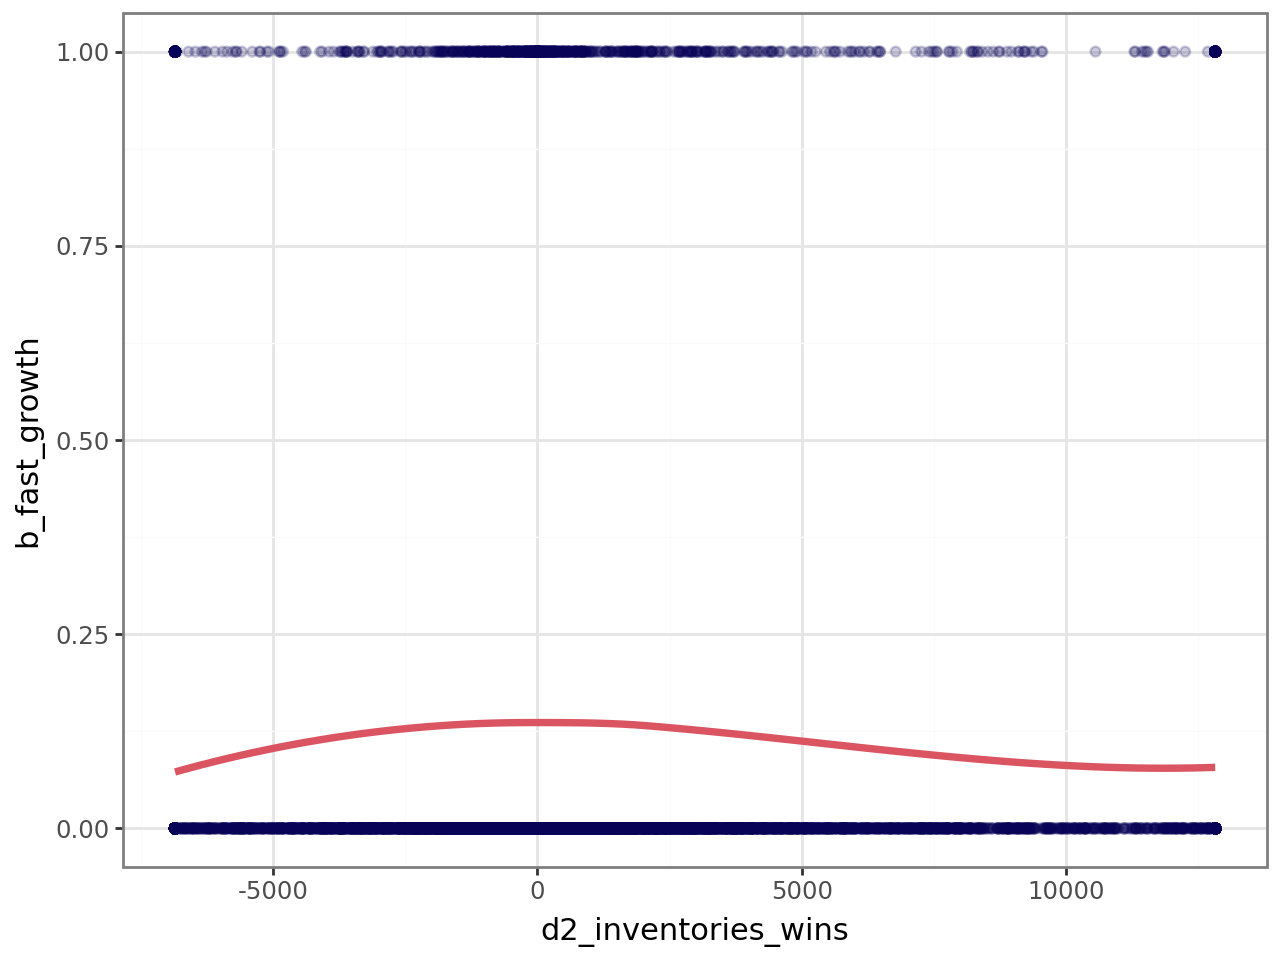

d2_ln_curr_assets_wins


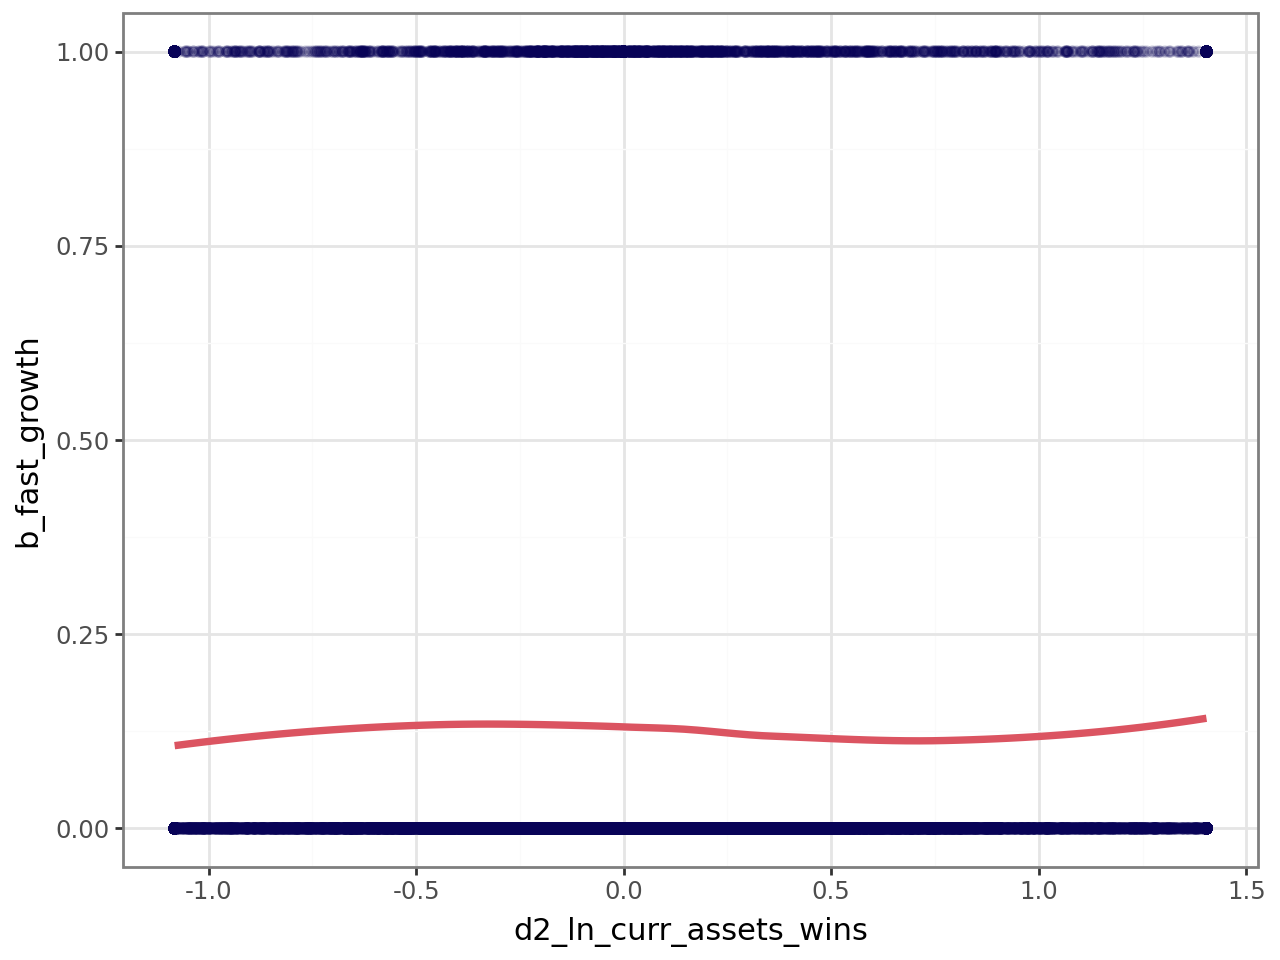

d2_ln_fixed_assets_wins


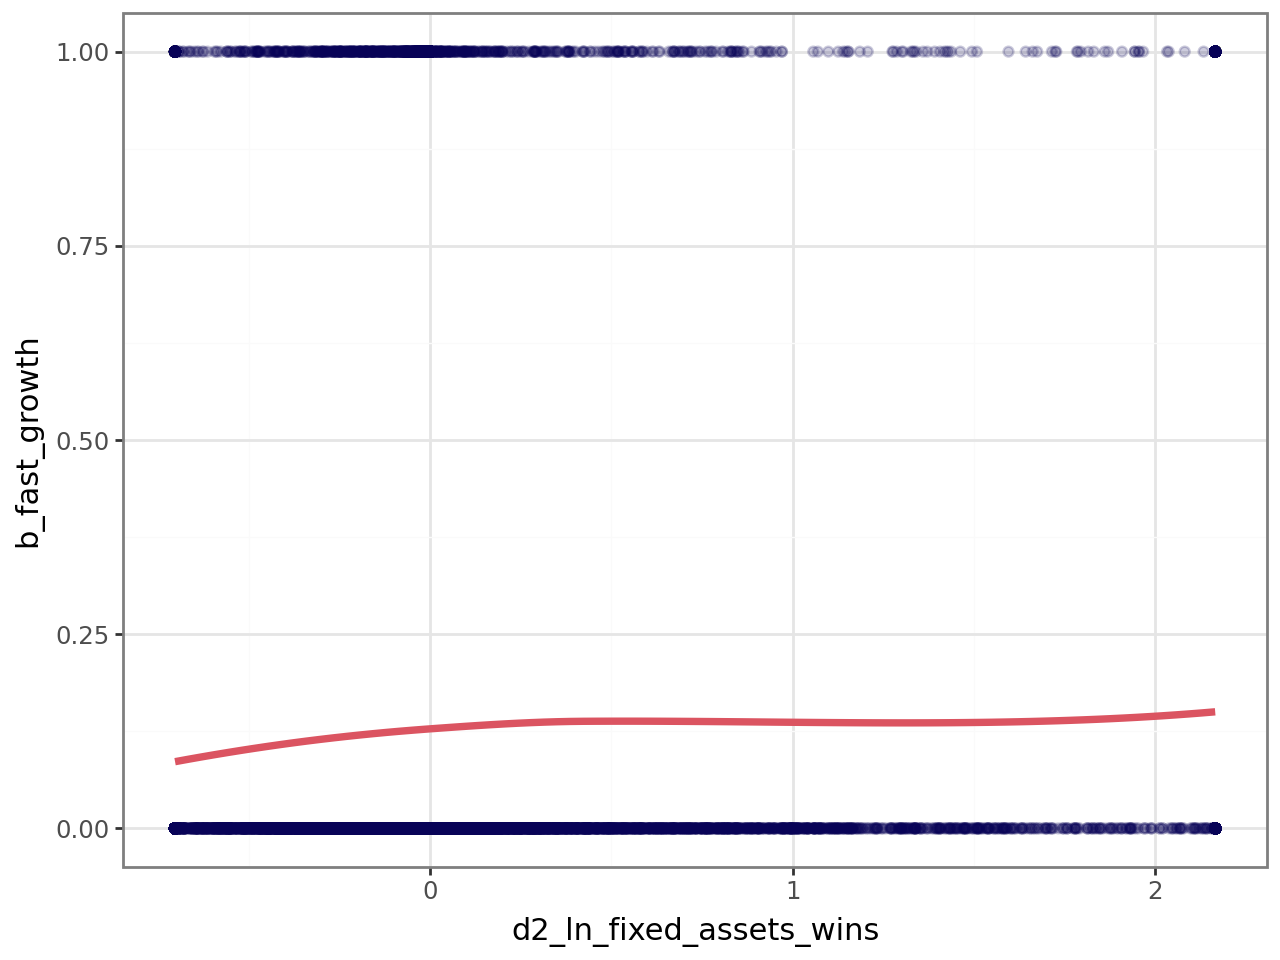

d2_ln_intang_assets_wins


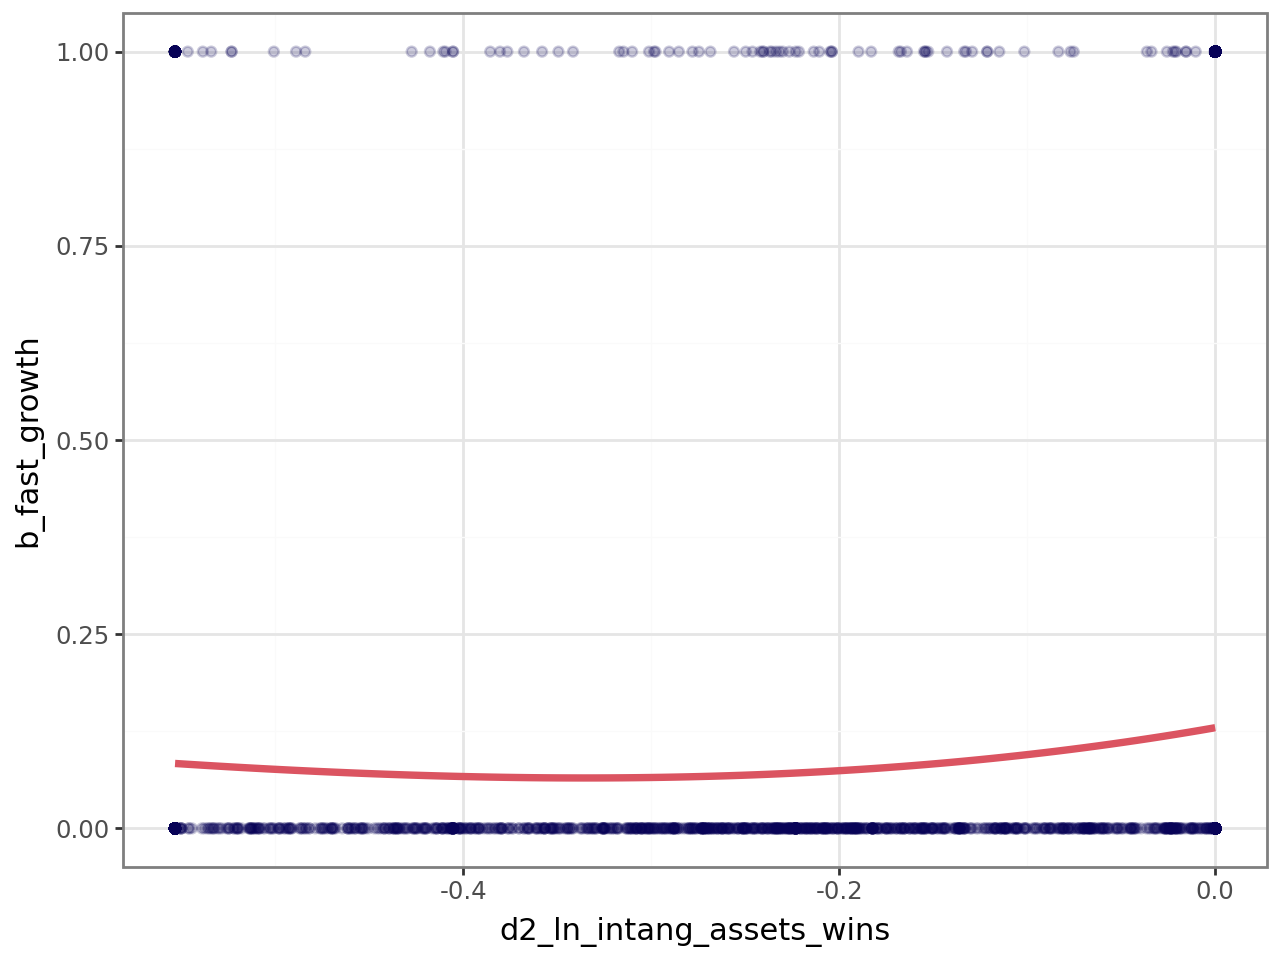

d2_ln_sales_mil_wins


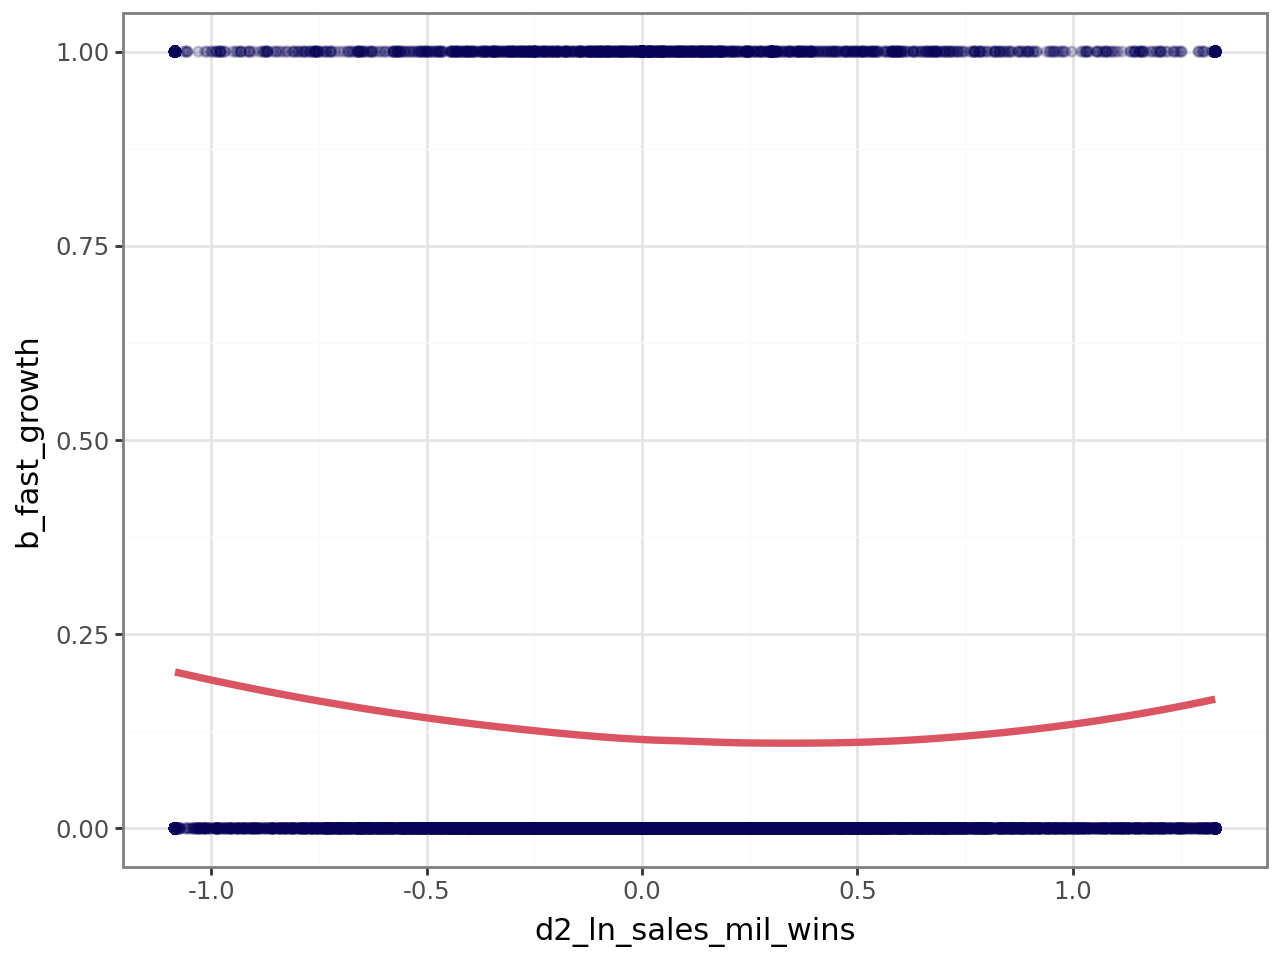

d2_ln_total_assets_wins


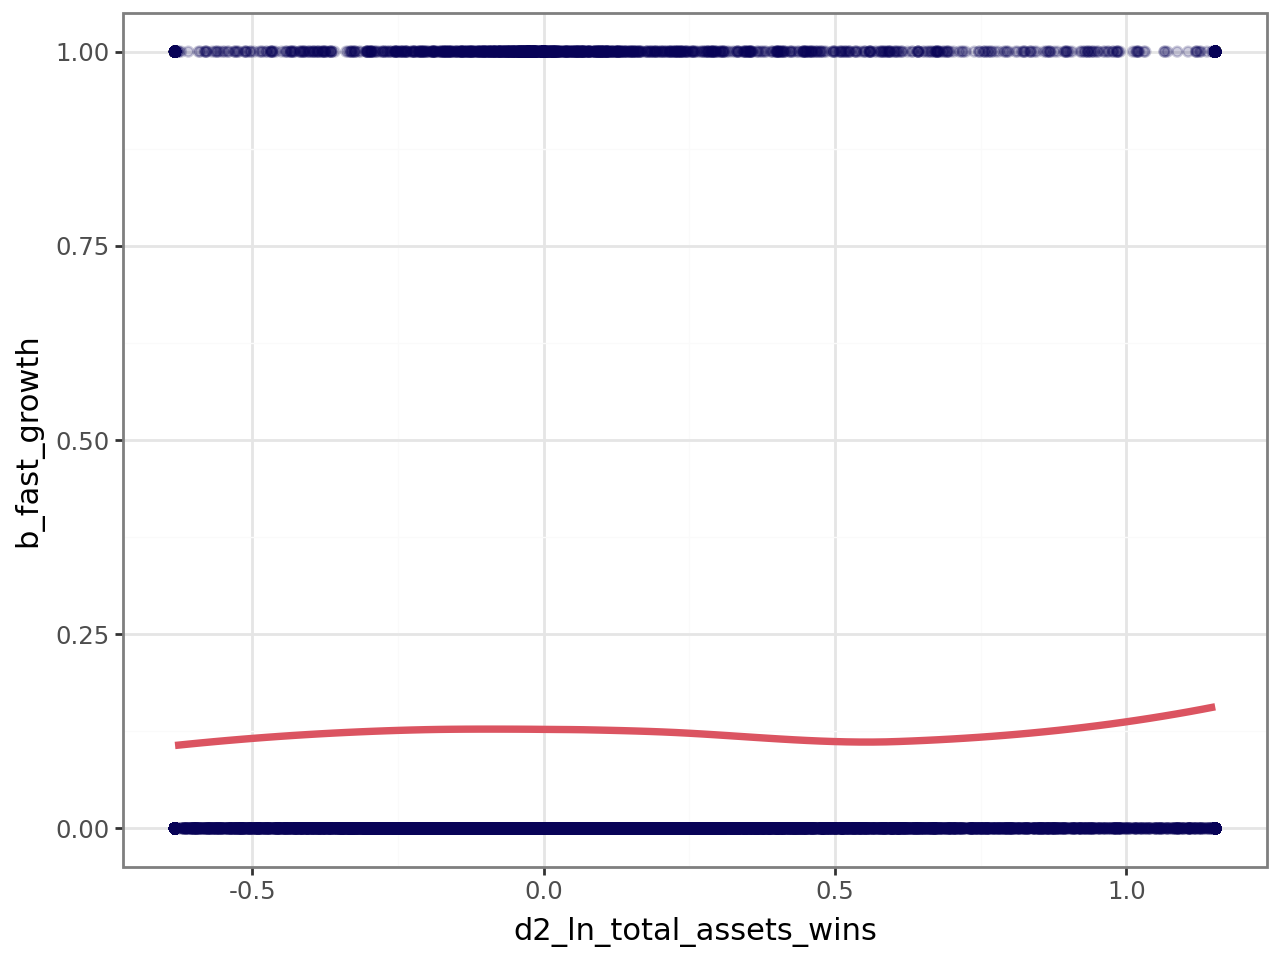

d2_material_exp_wins


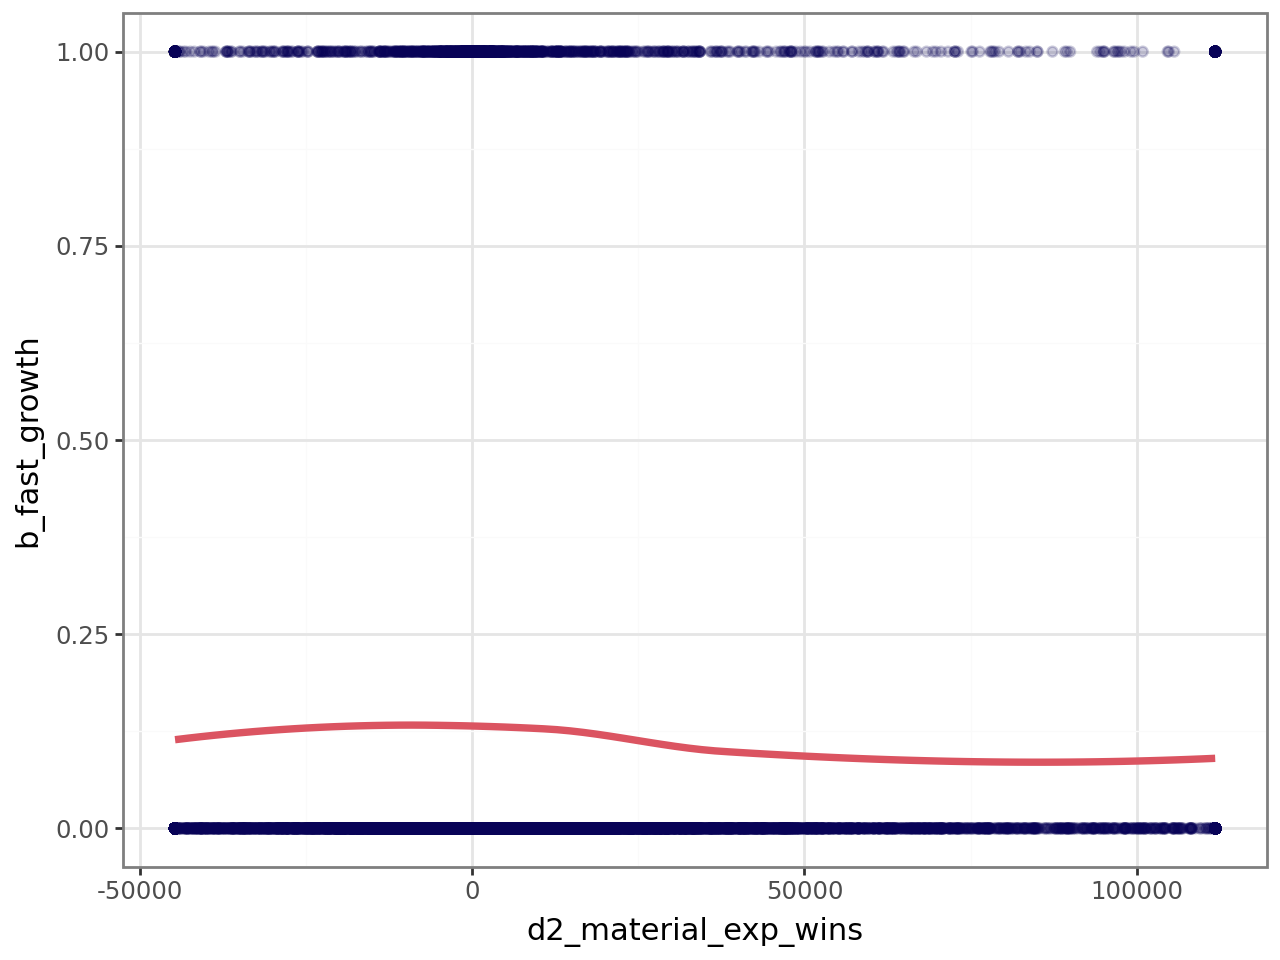

d2_personnel_exp_wins


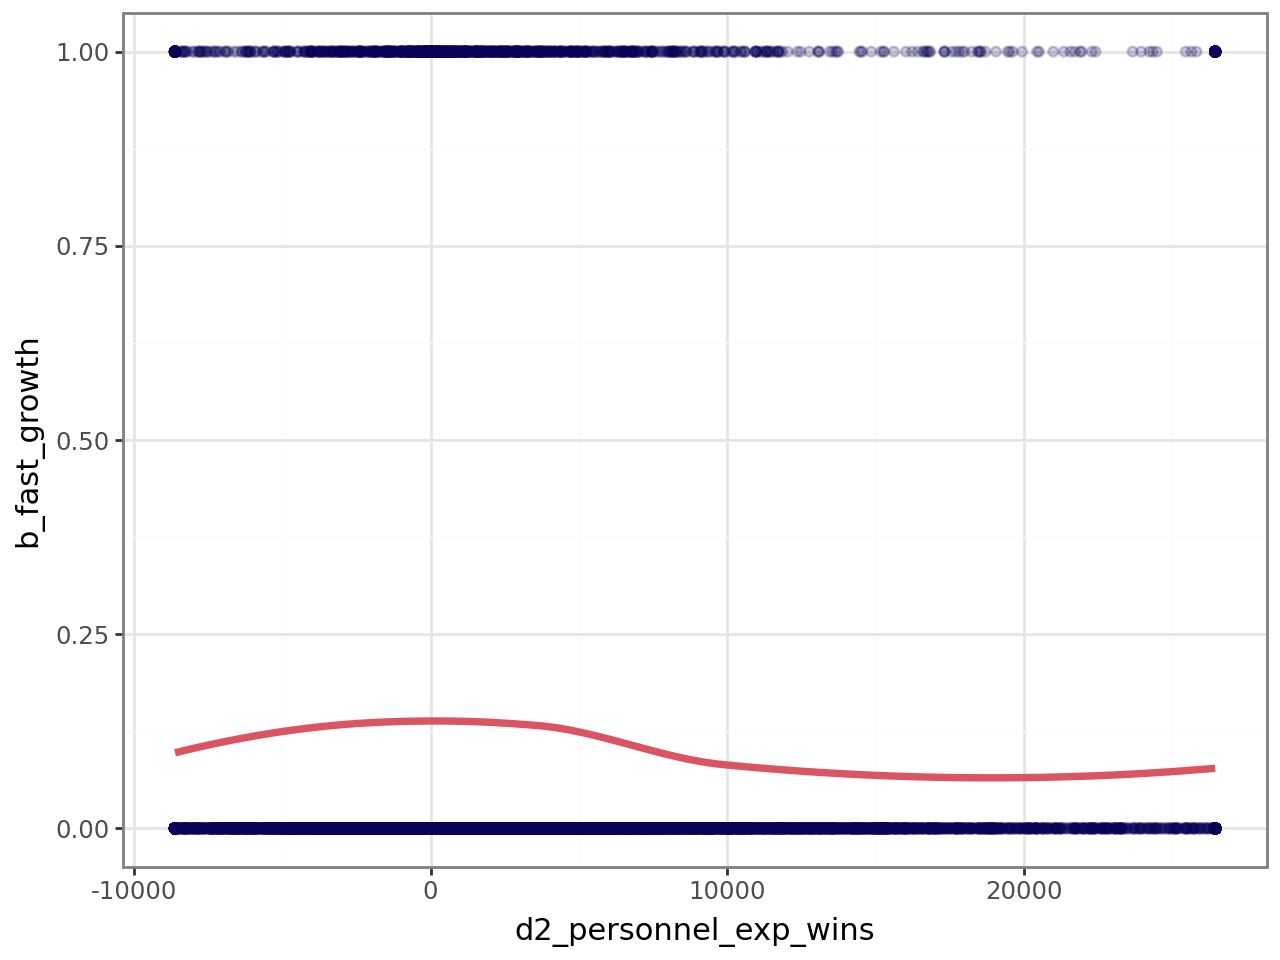

d2_profit_loss_year_wins


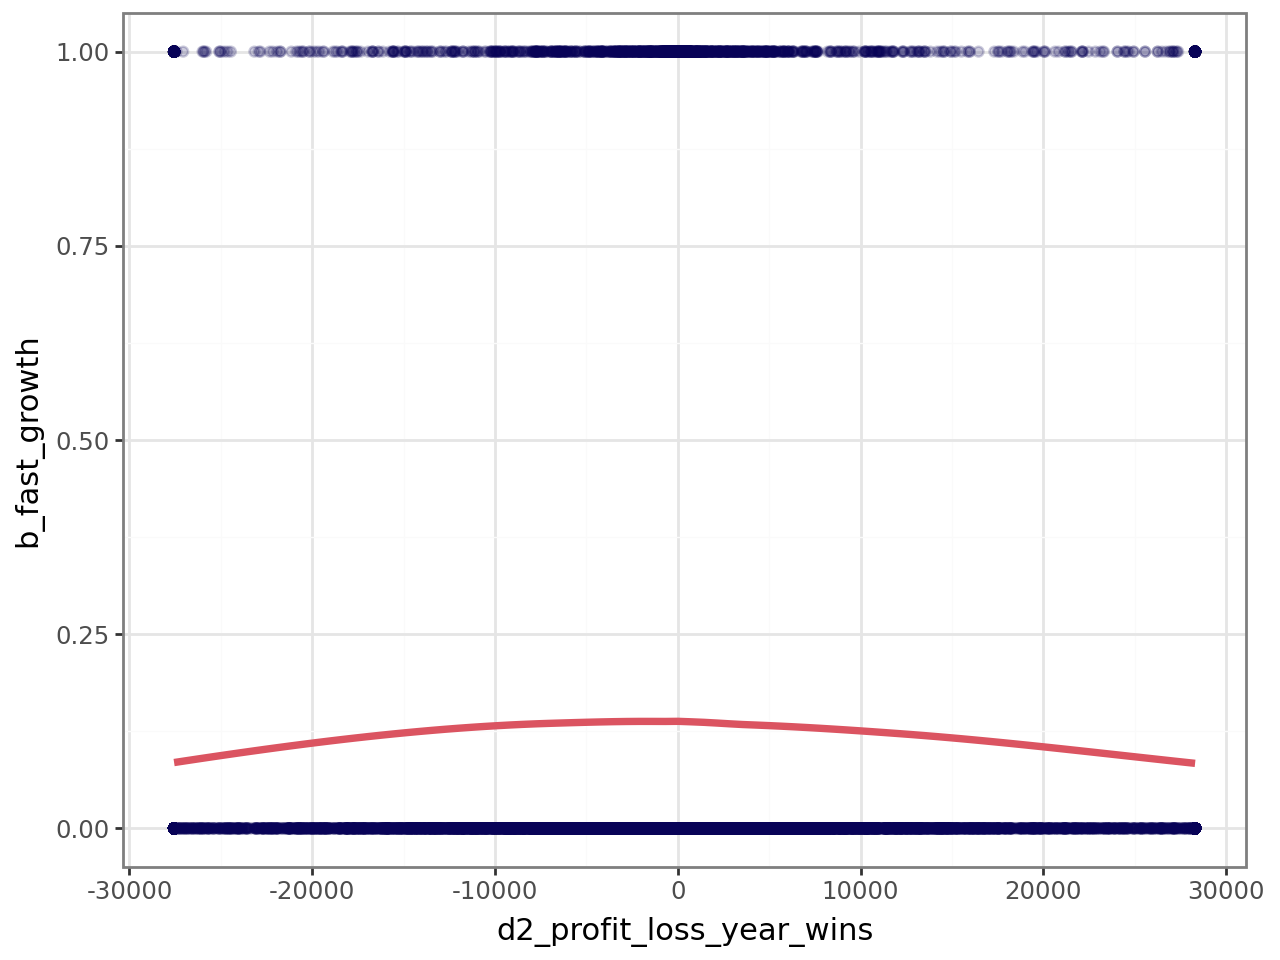

extra_exp_pl


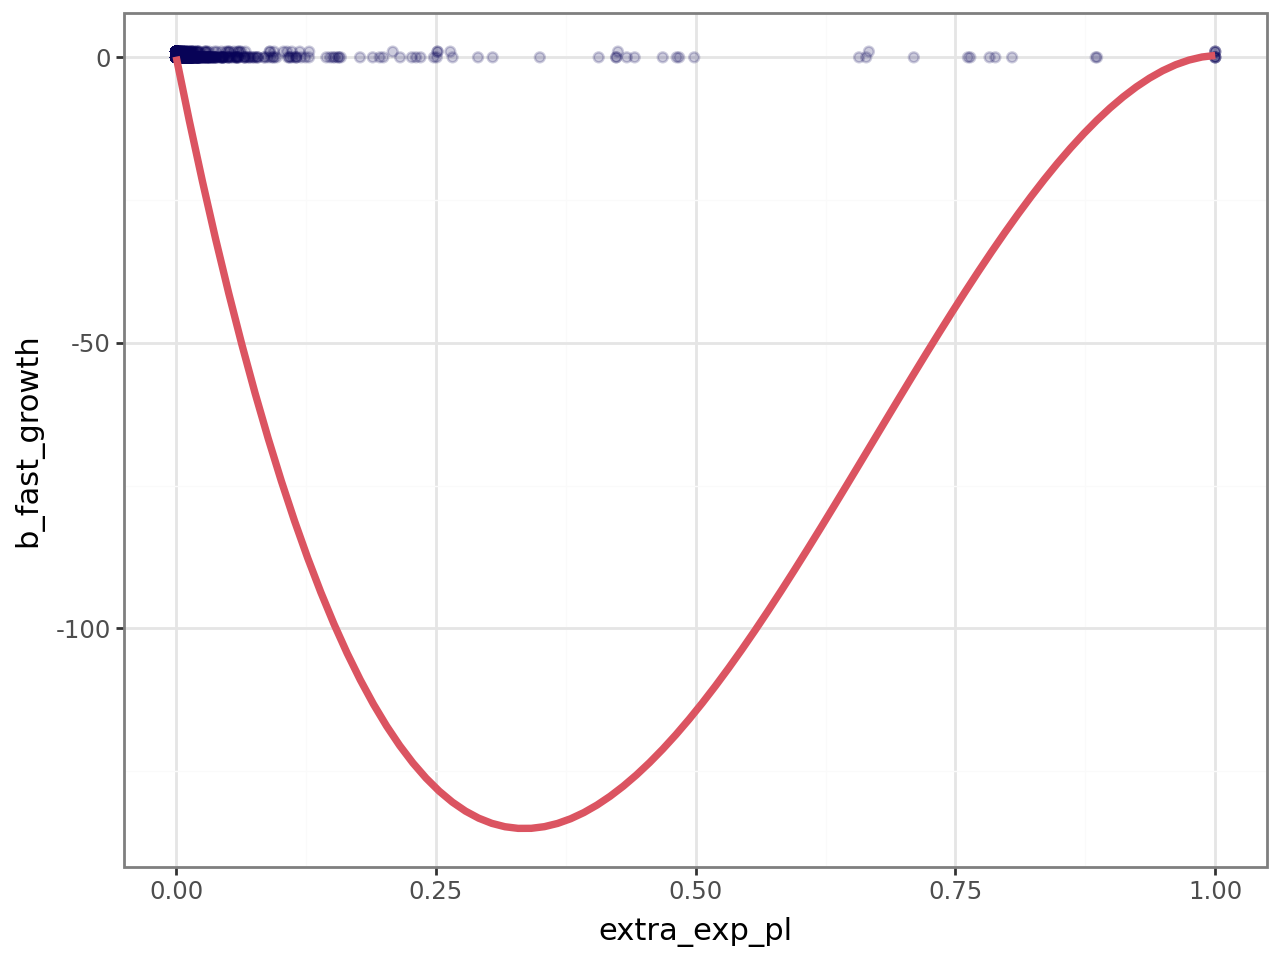

extra_exp_wins


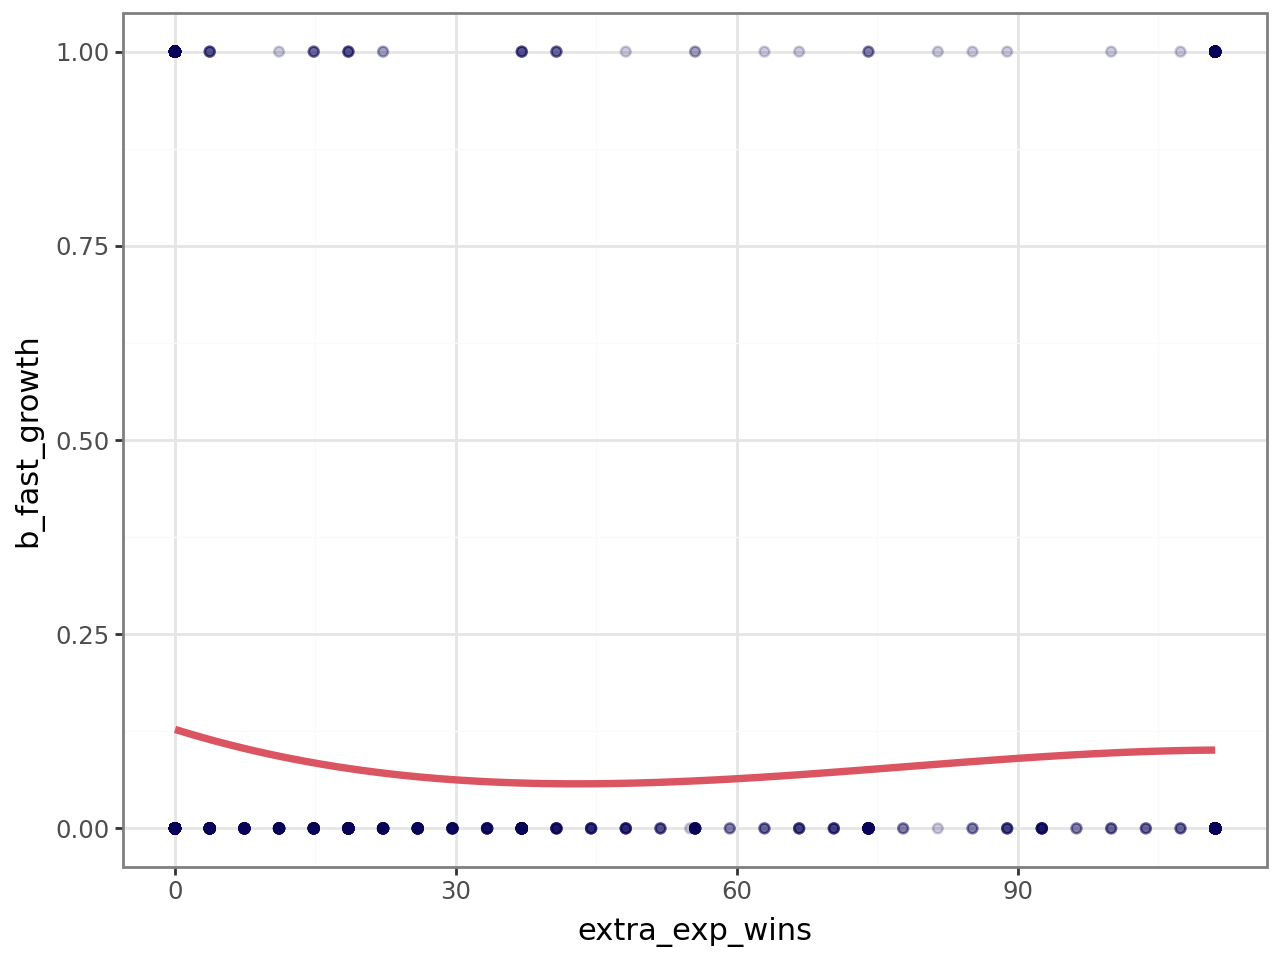

extra_inc_pl


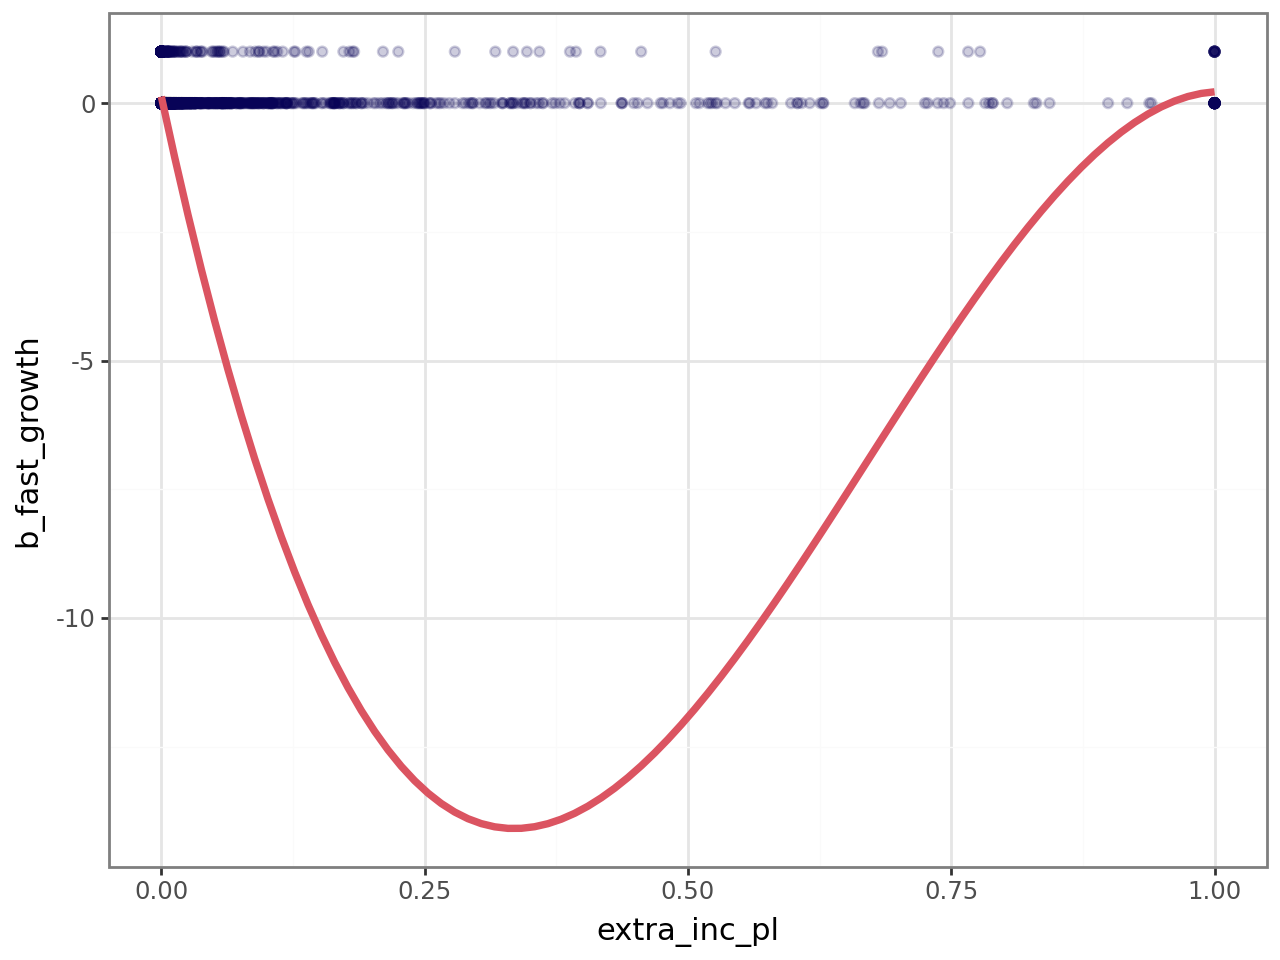

extra_inc_wins


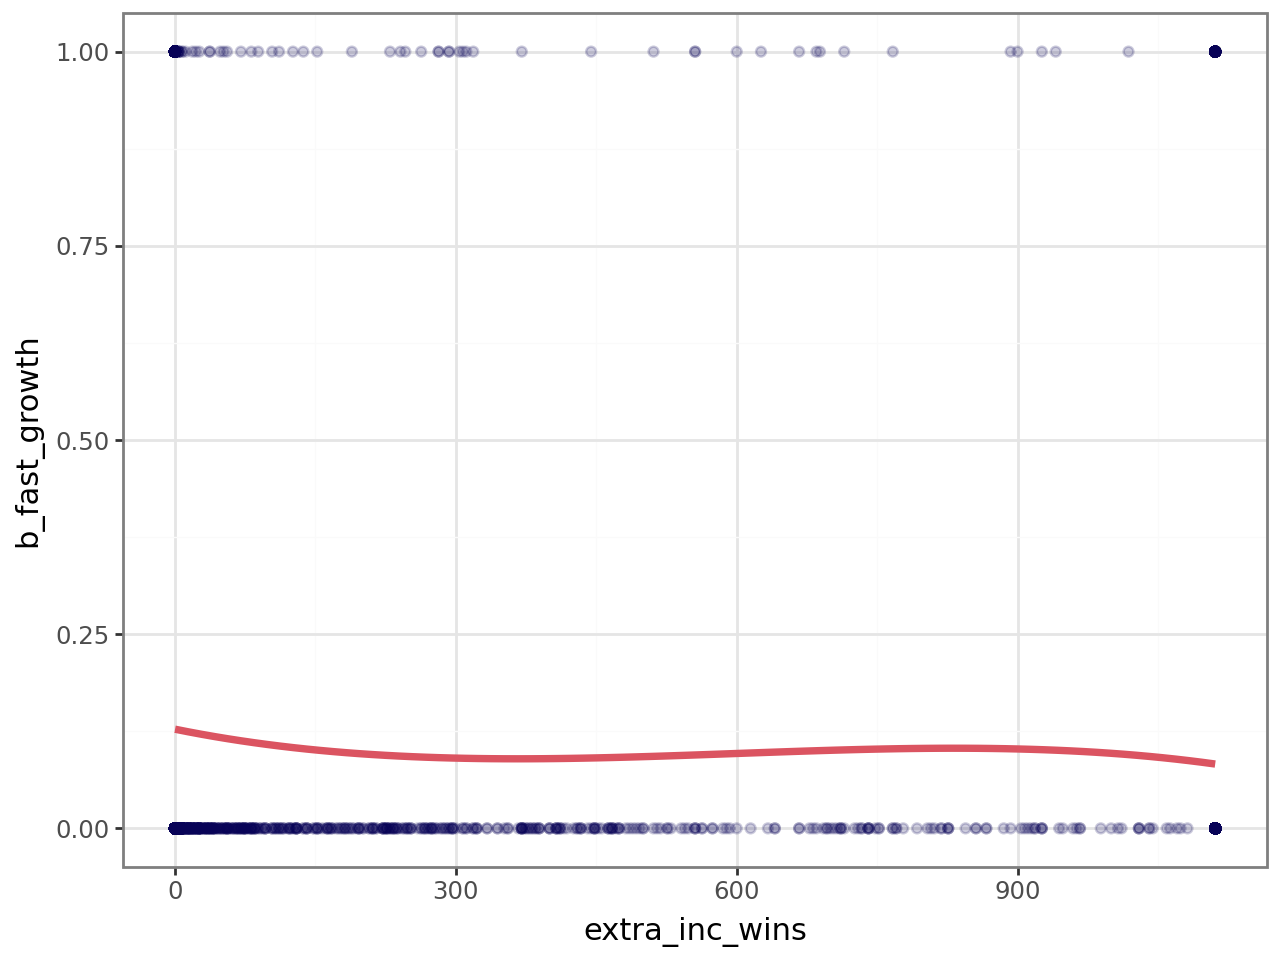

extra_profit_loss_pl


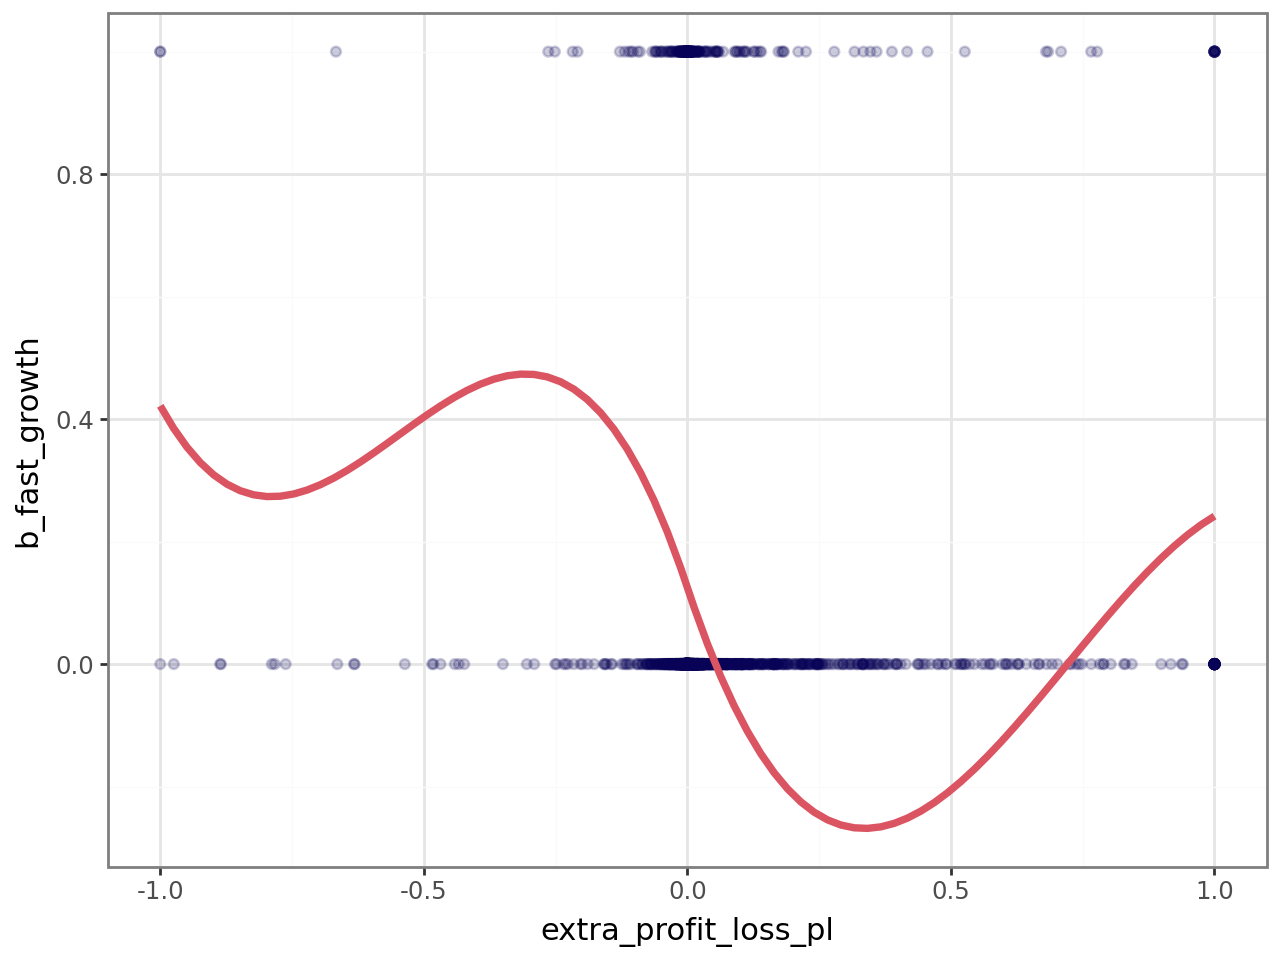

extra_profit_loss_wins


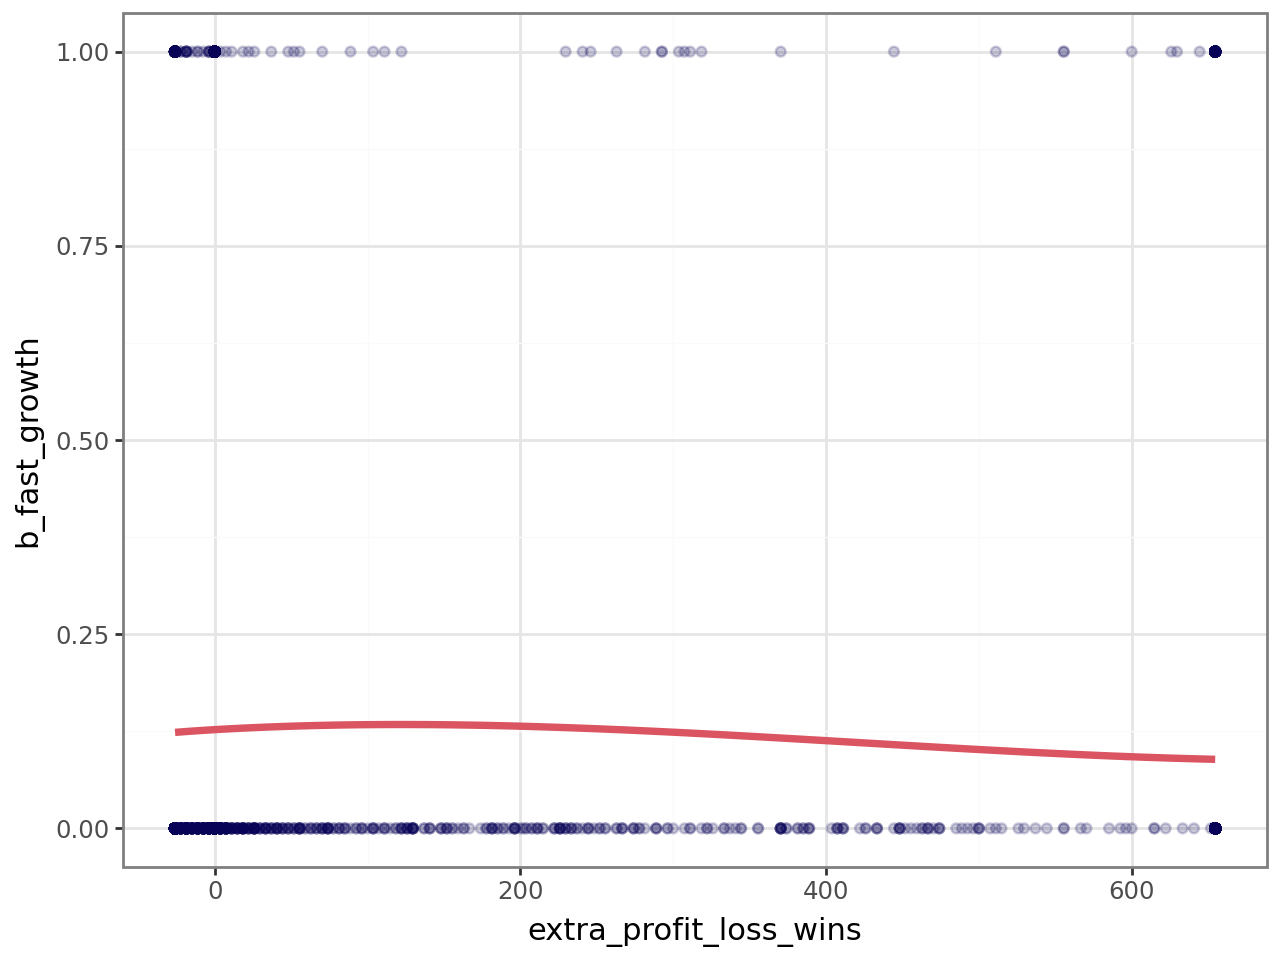

fixed_assets_bs


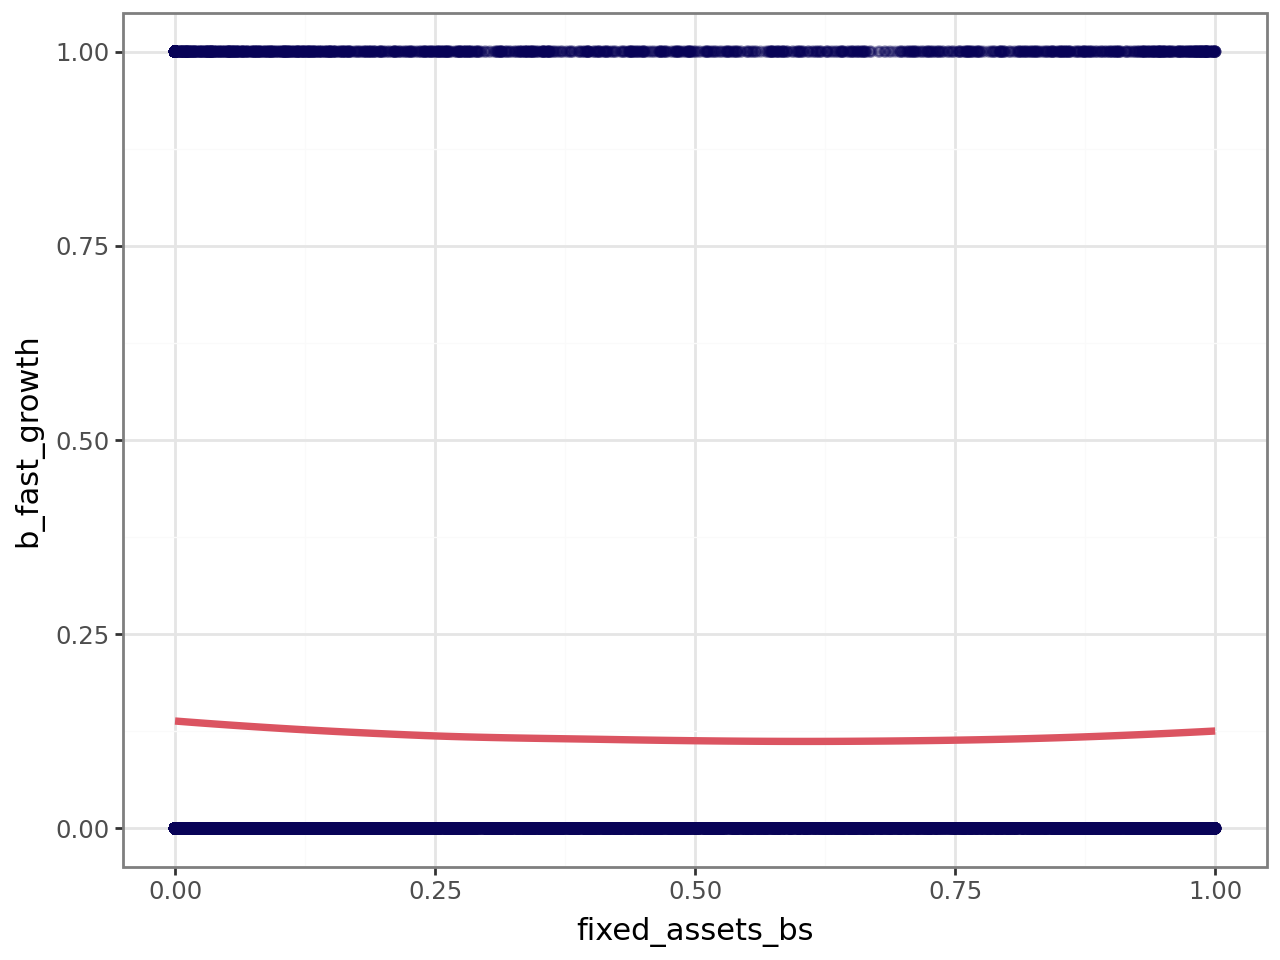

fixed_assets_wins


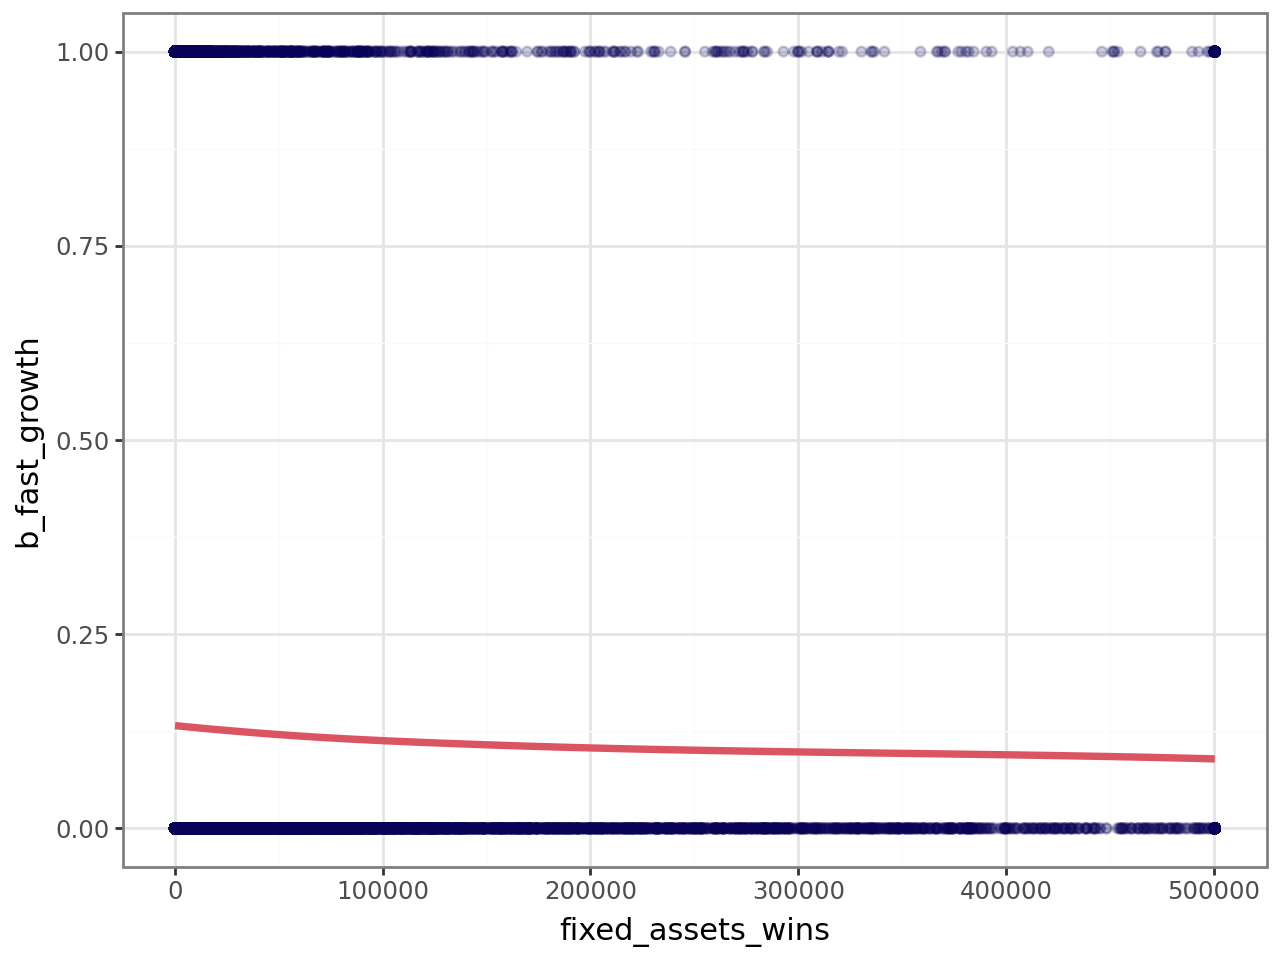

inc_bef_tax_pl


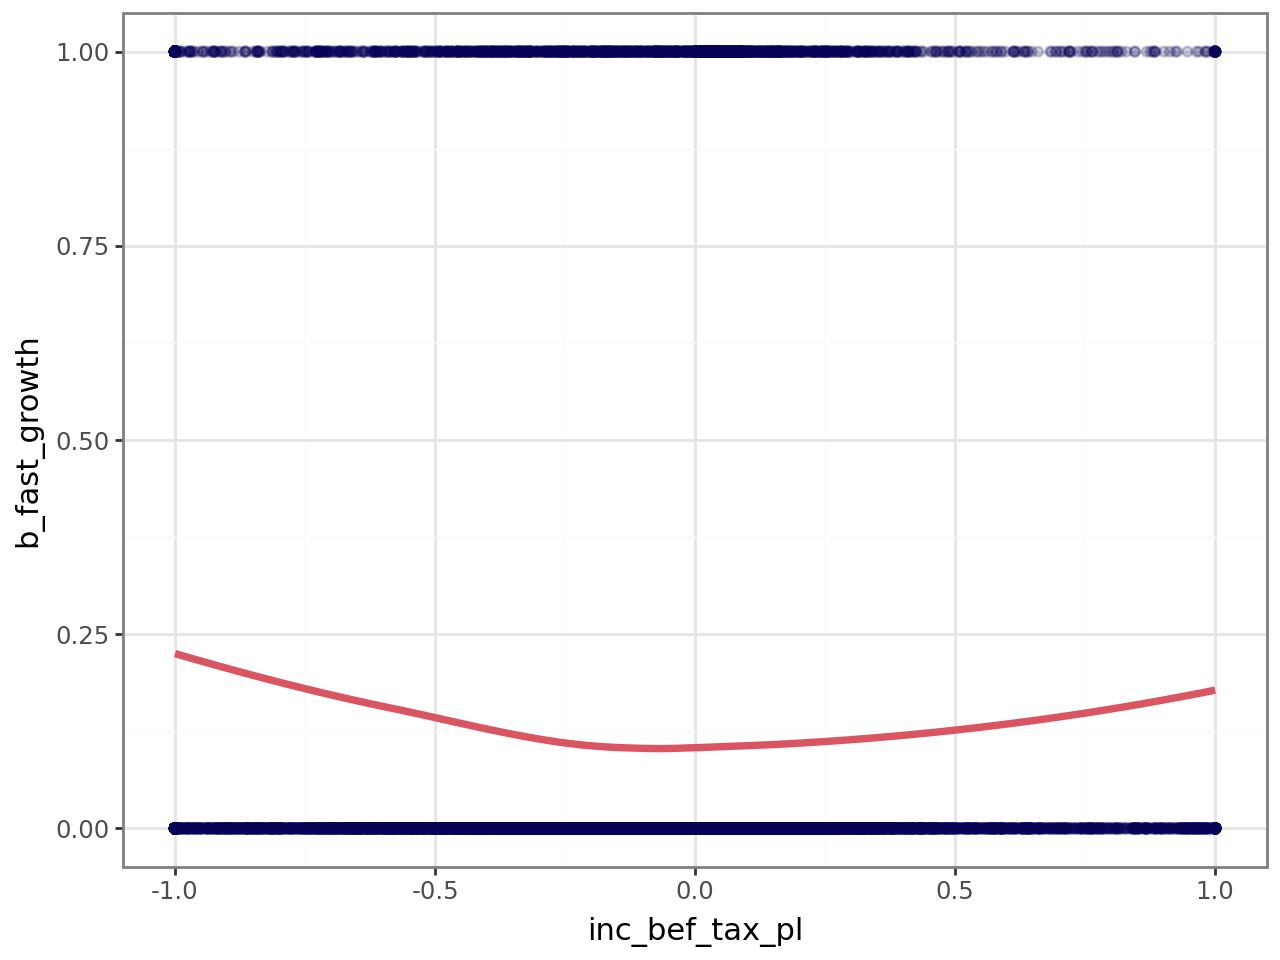

inc_bef_tax_wins


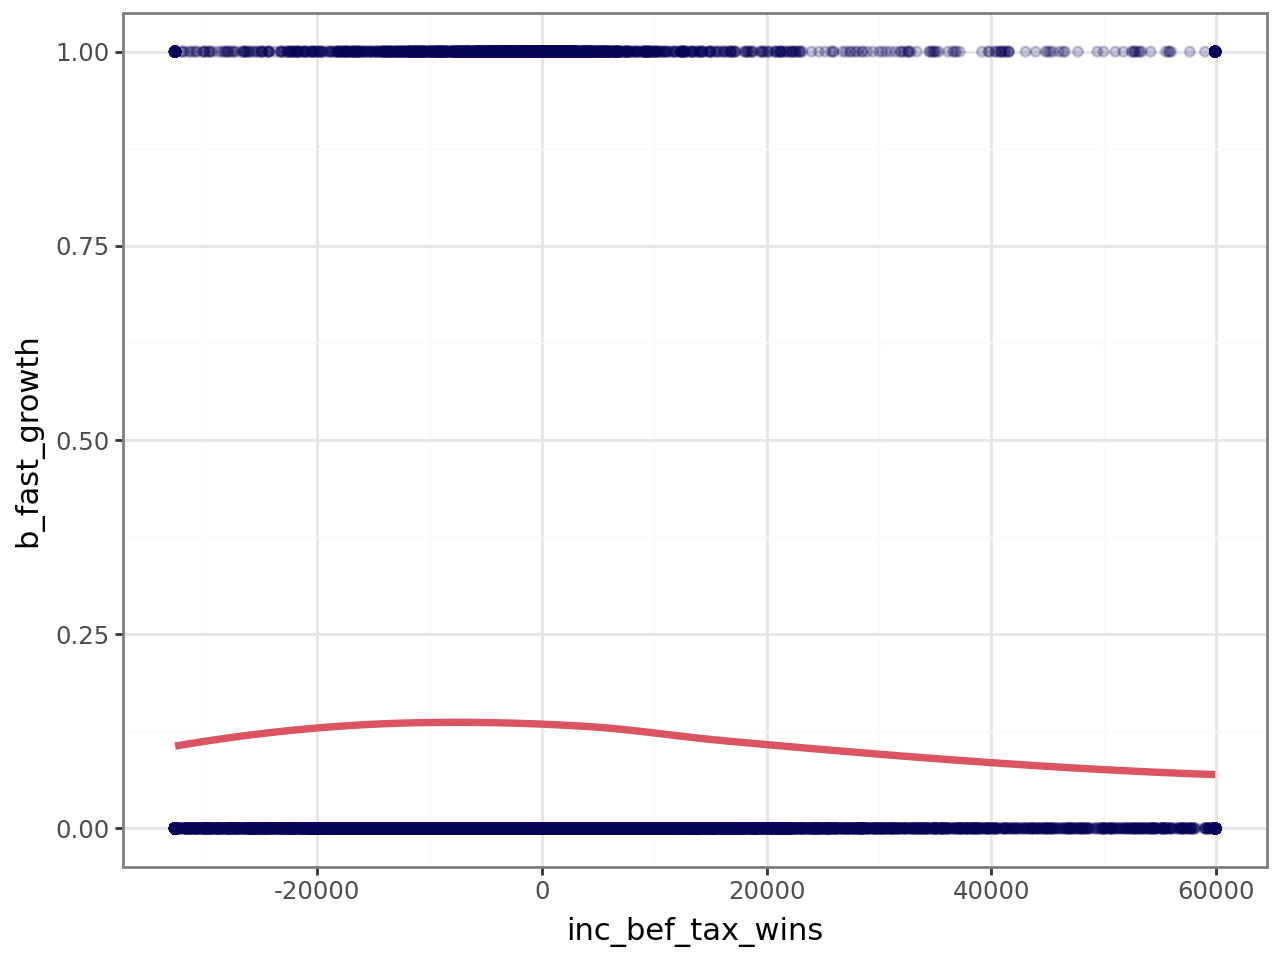

inoffice_days_wins


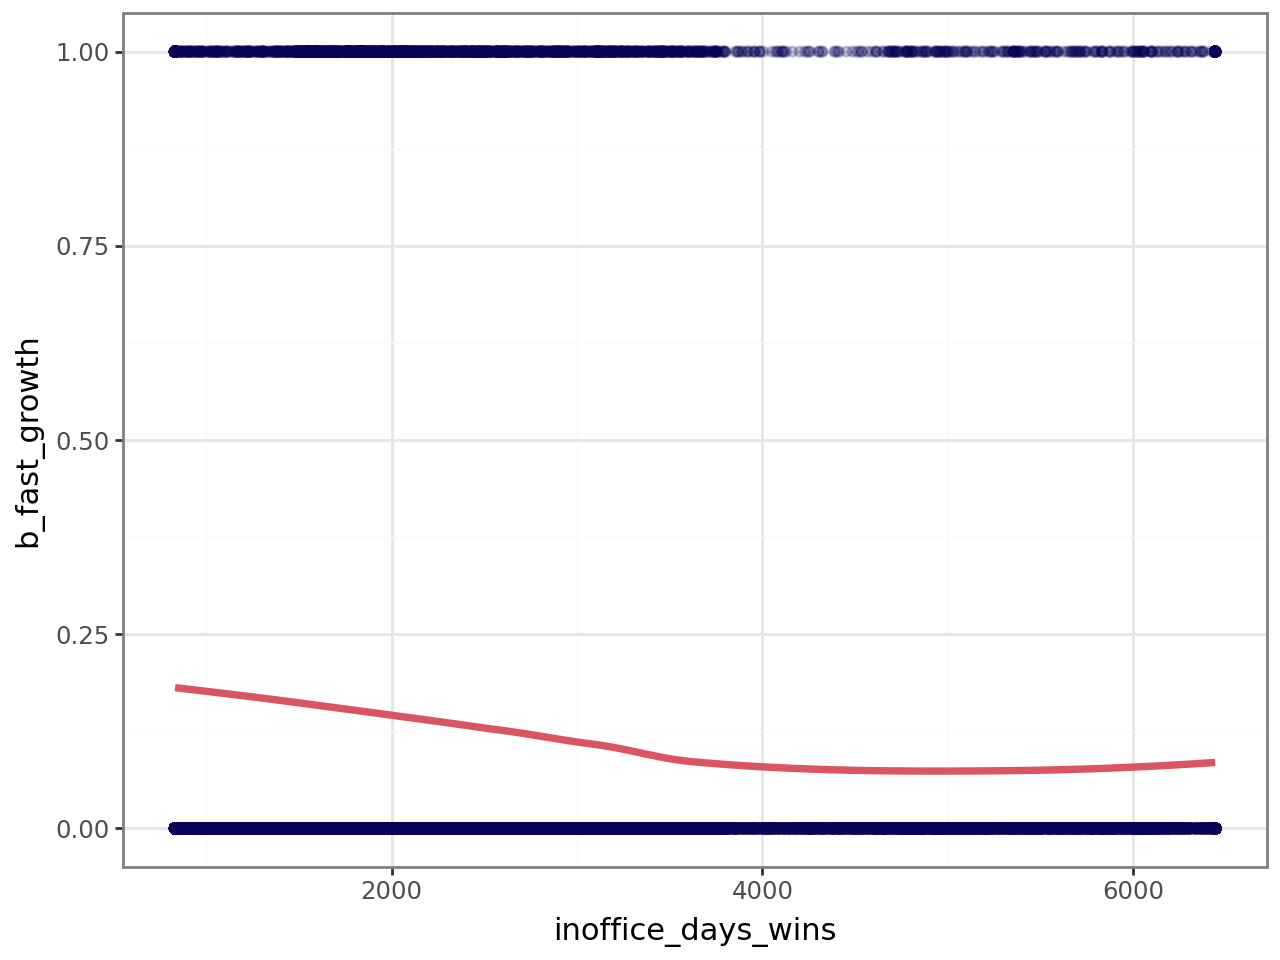

intang_assets_bs


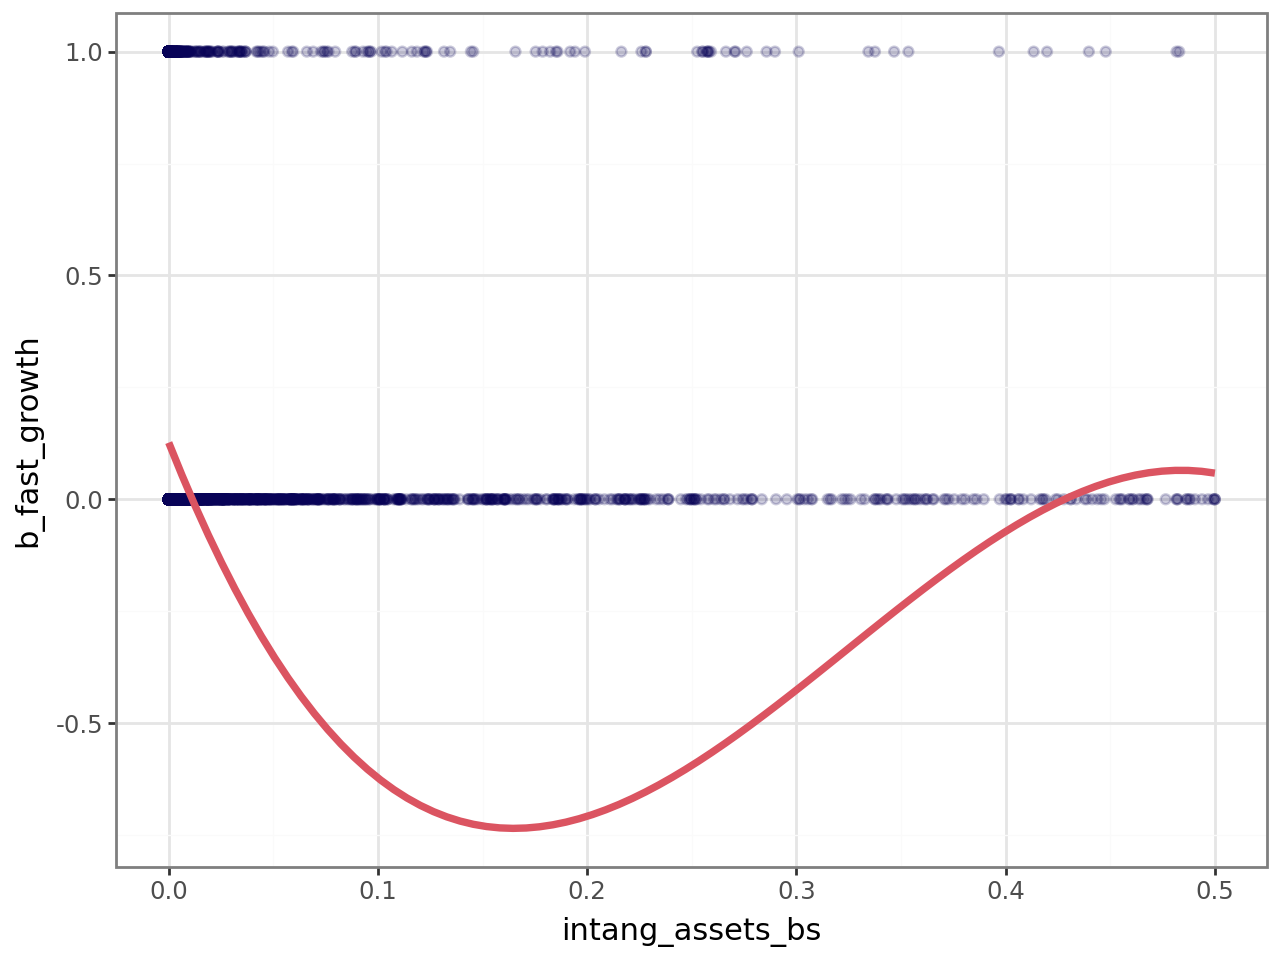

intang_assets_wins


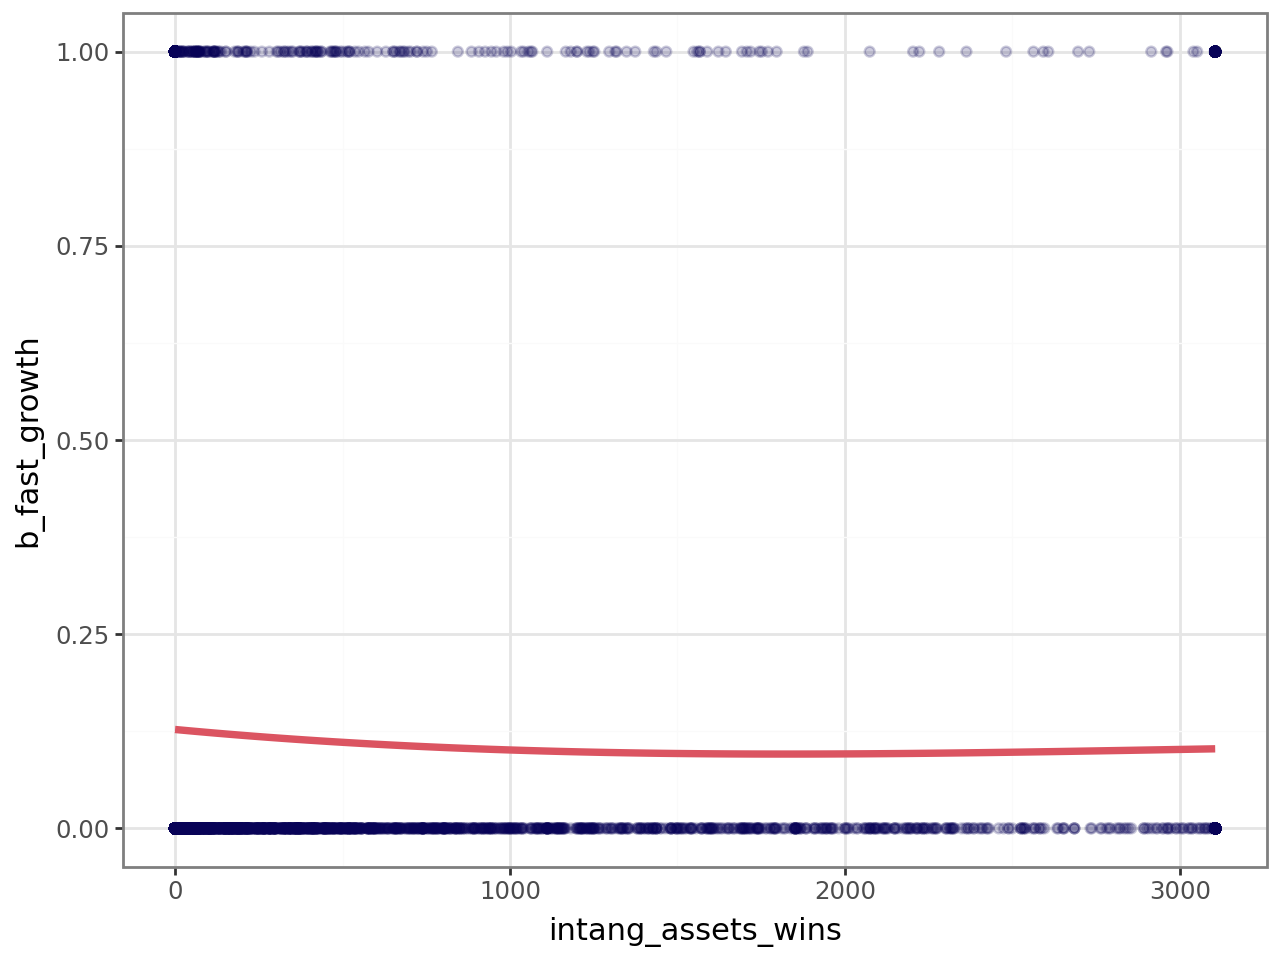

inventories_pl


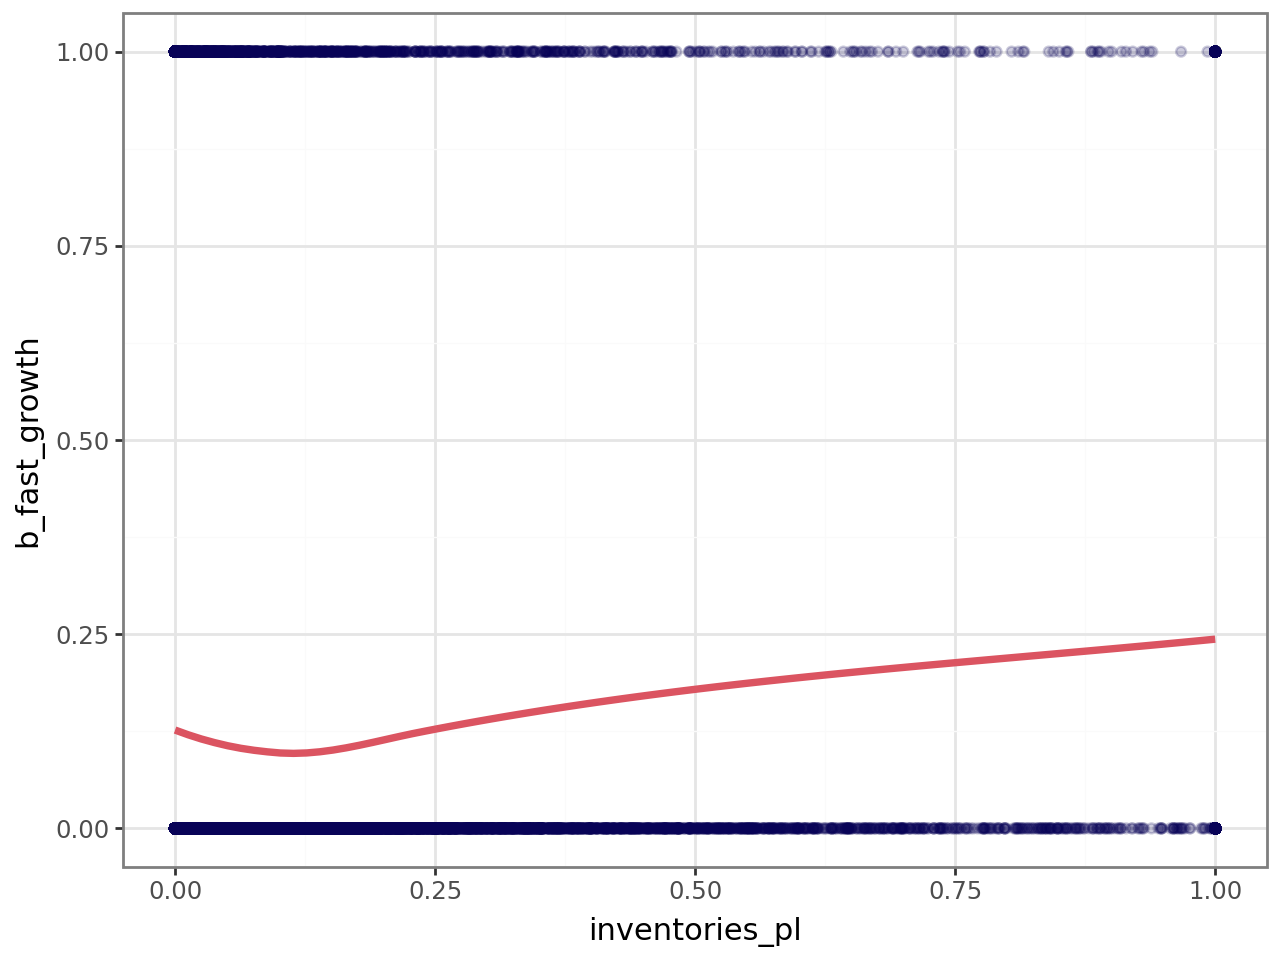

inventories_wins


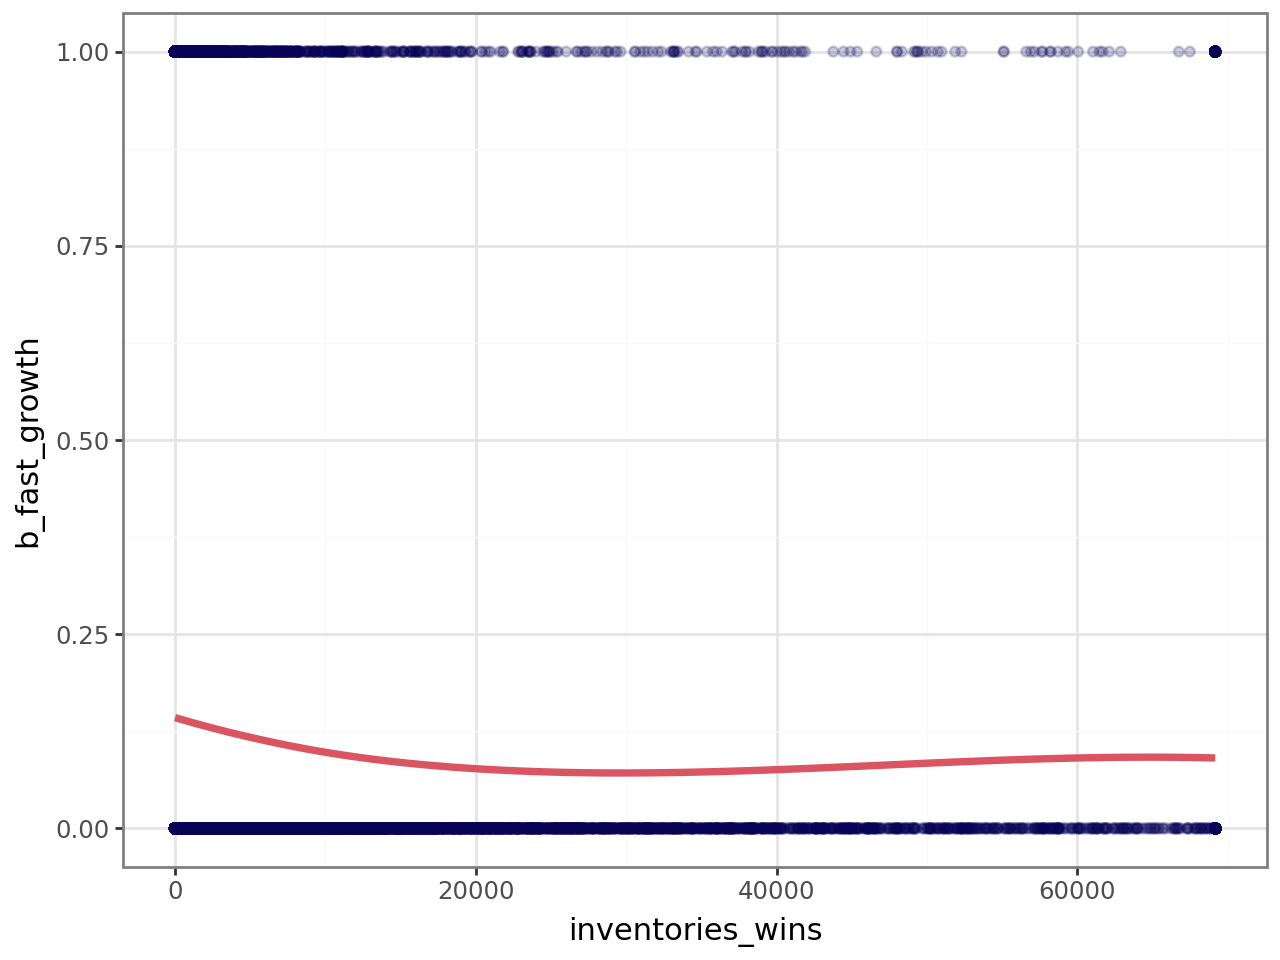

labor_avg_mod_wins


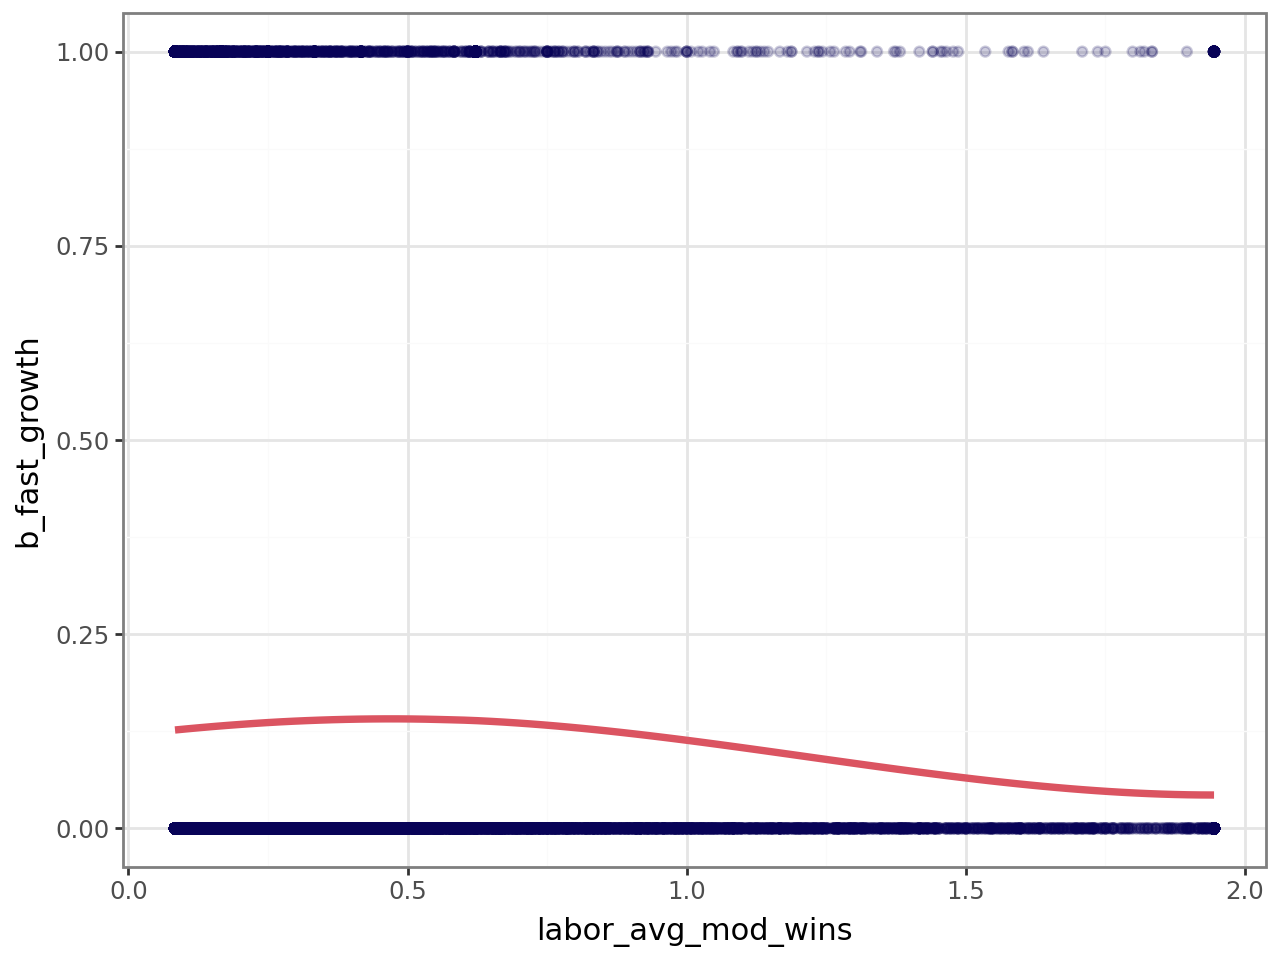

liq_assets_bs


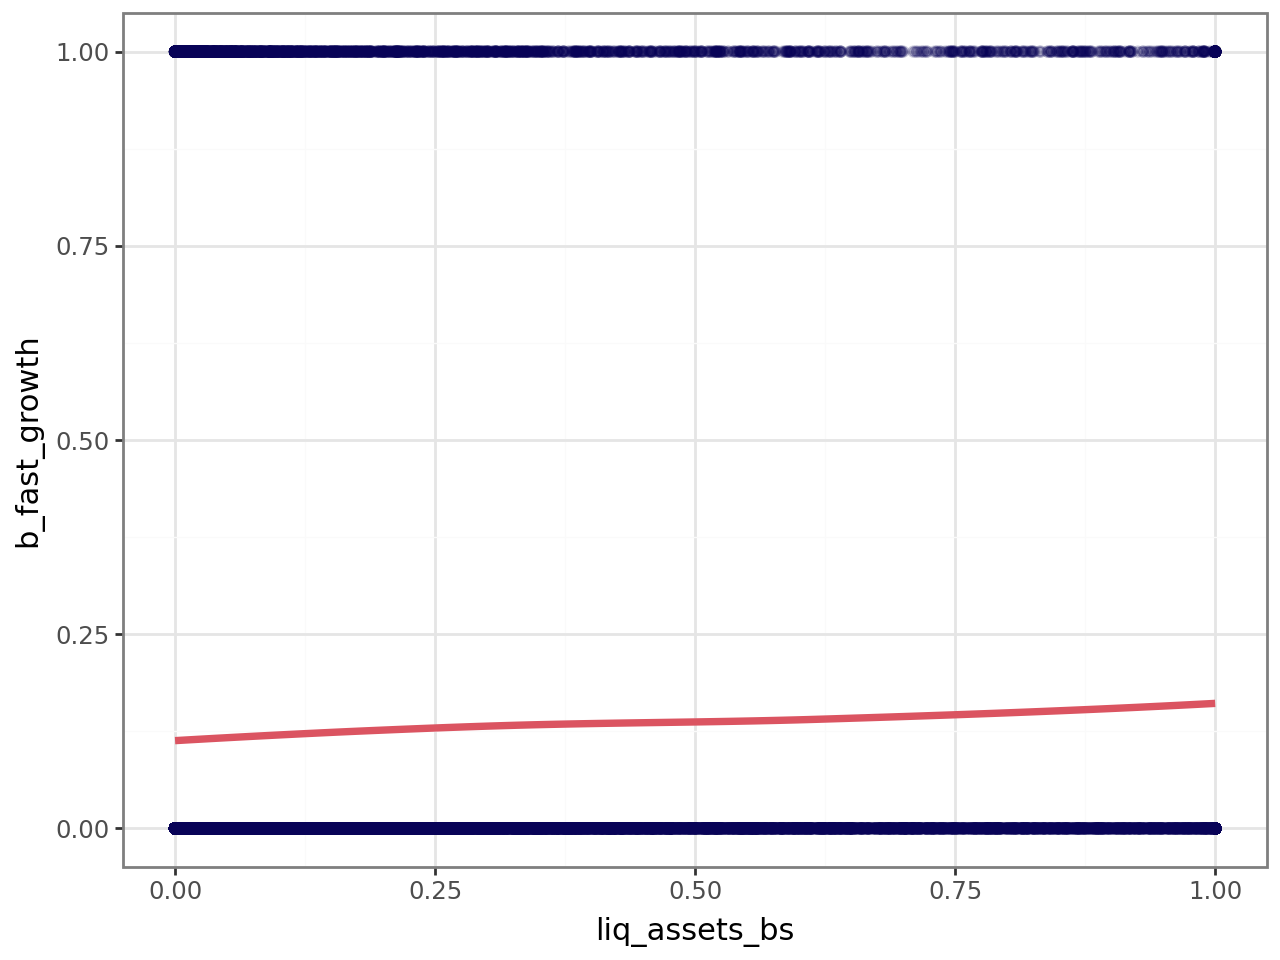

liq_assets_wins


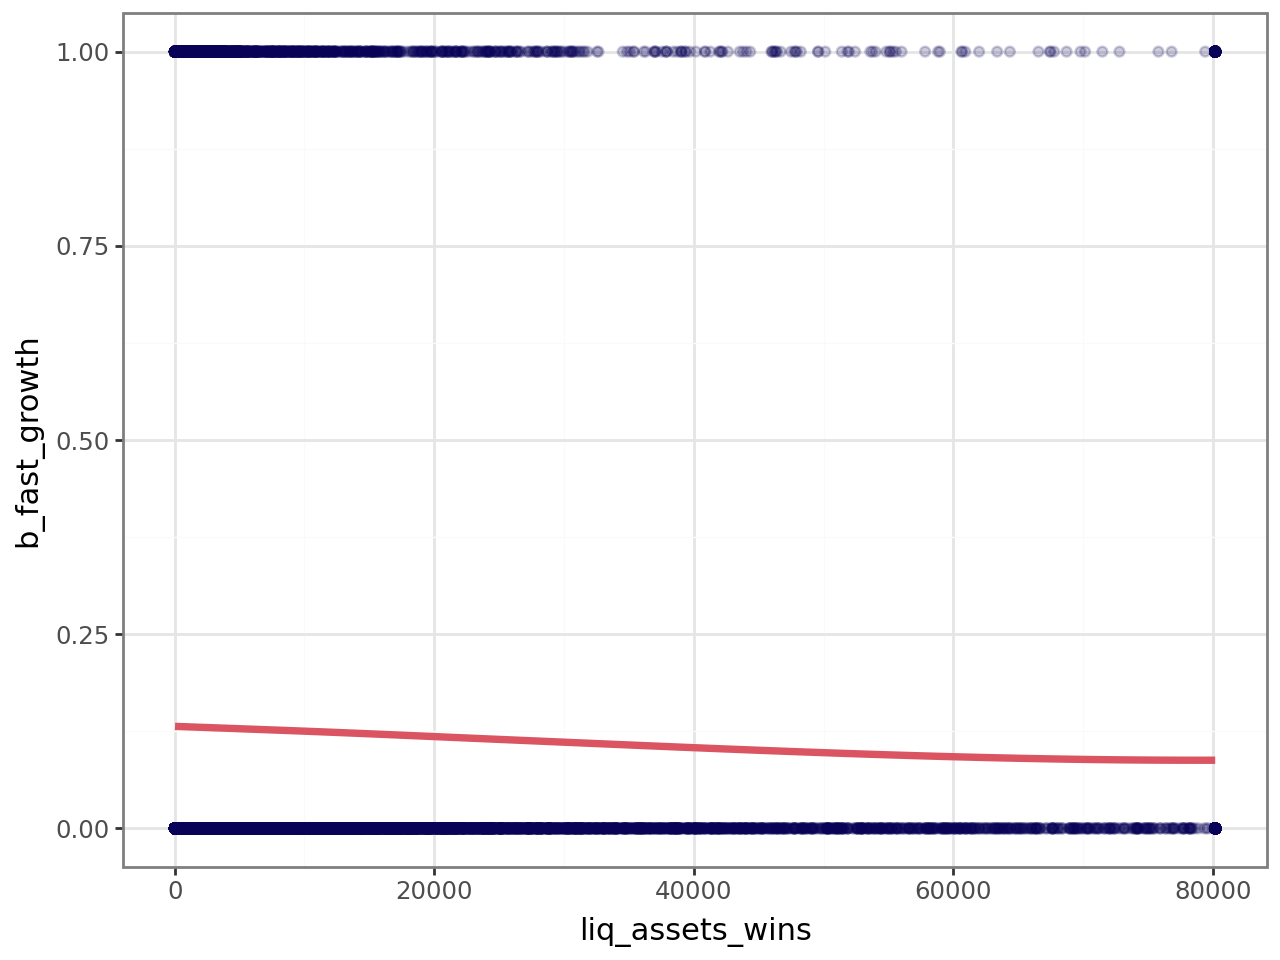

ln_curr_assets_wins


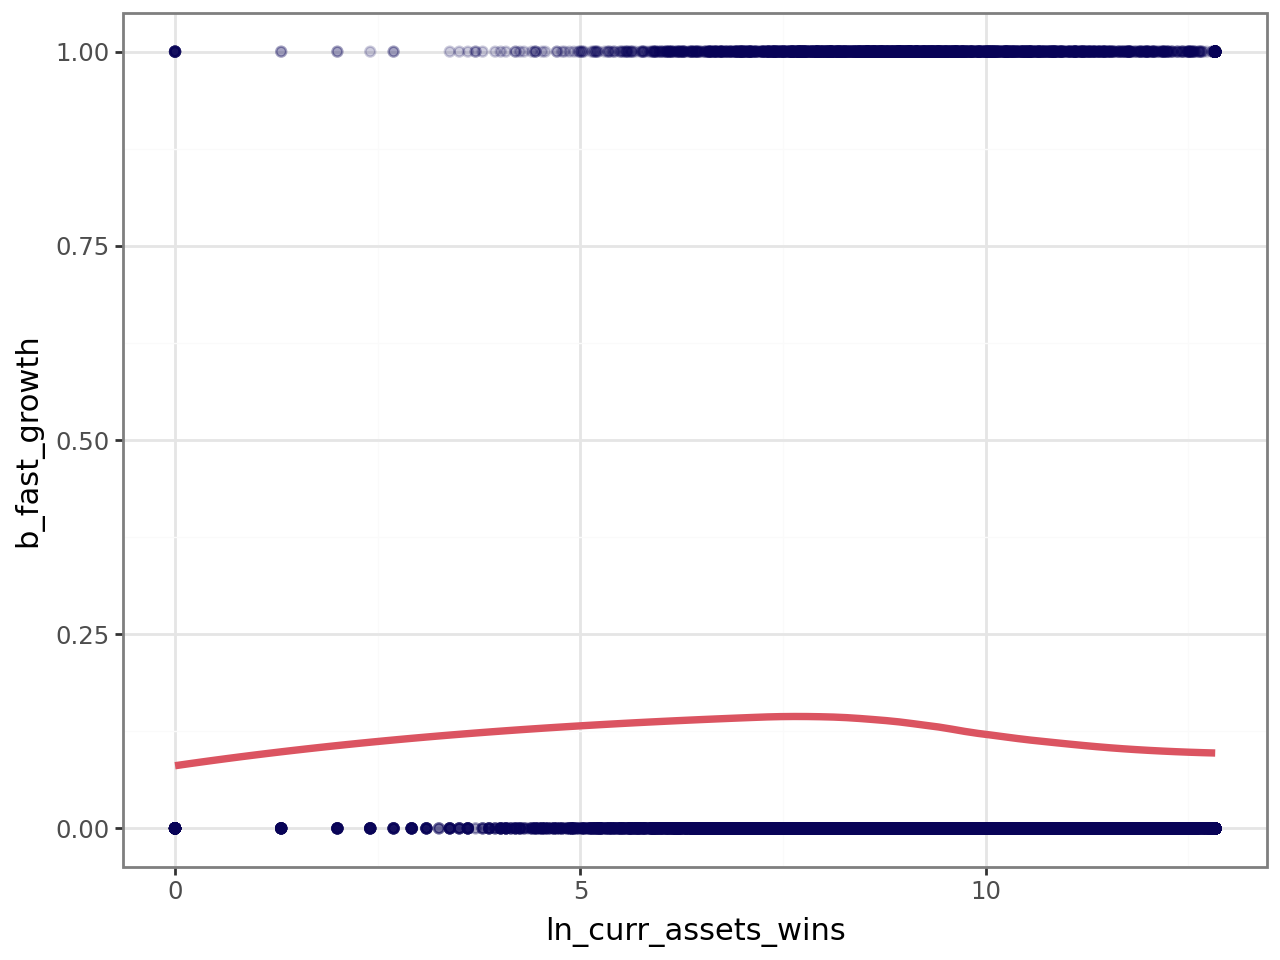

ln_fixed_assets_wins


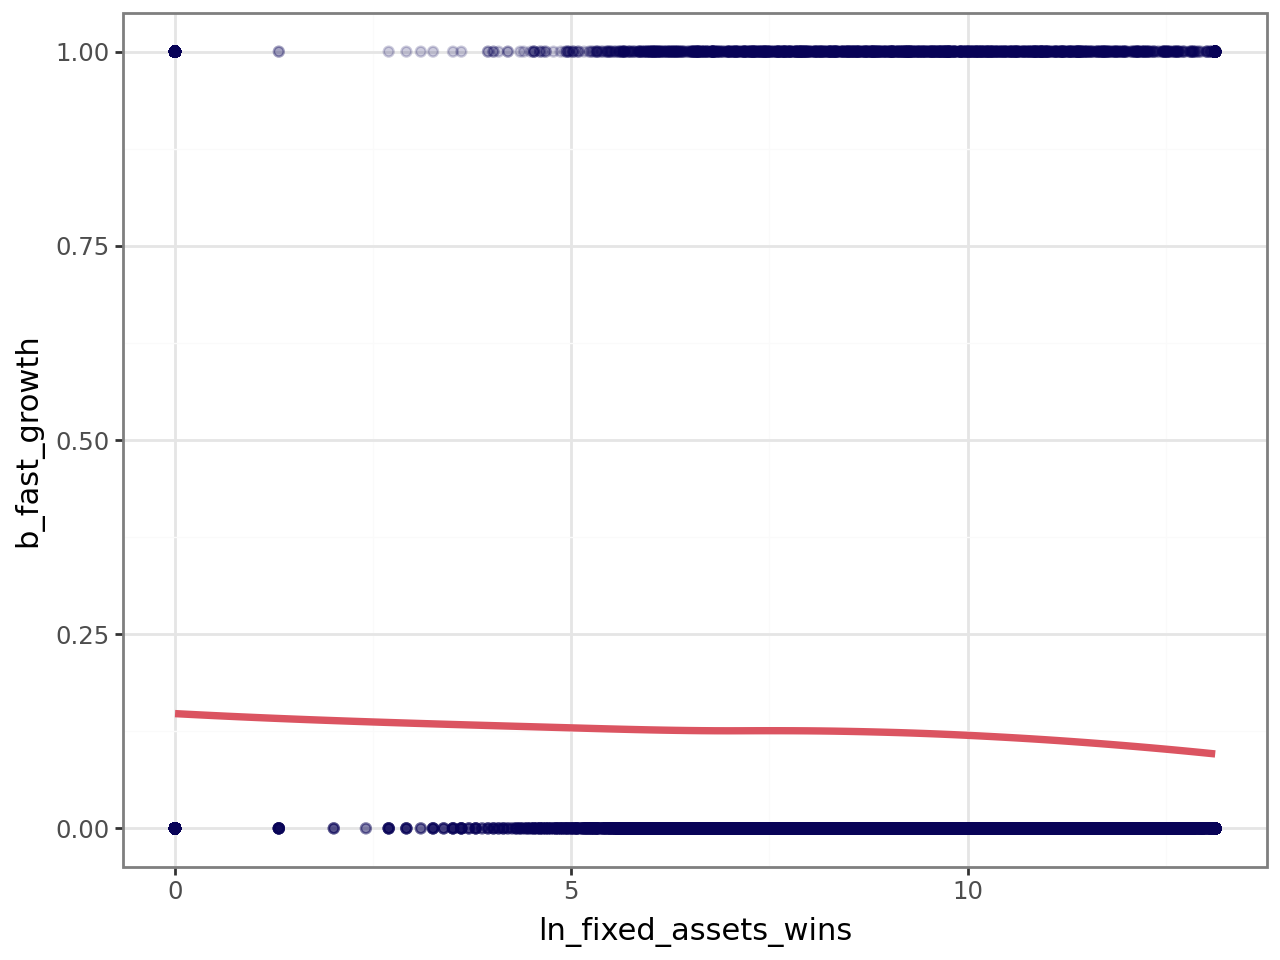

ln_intang_assets_wins


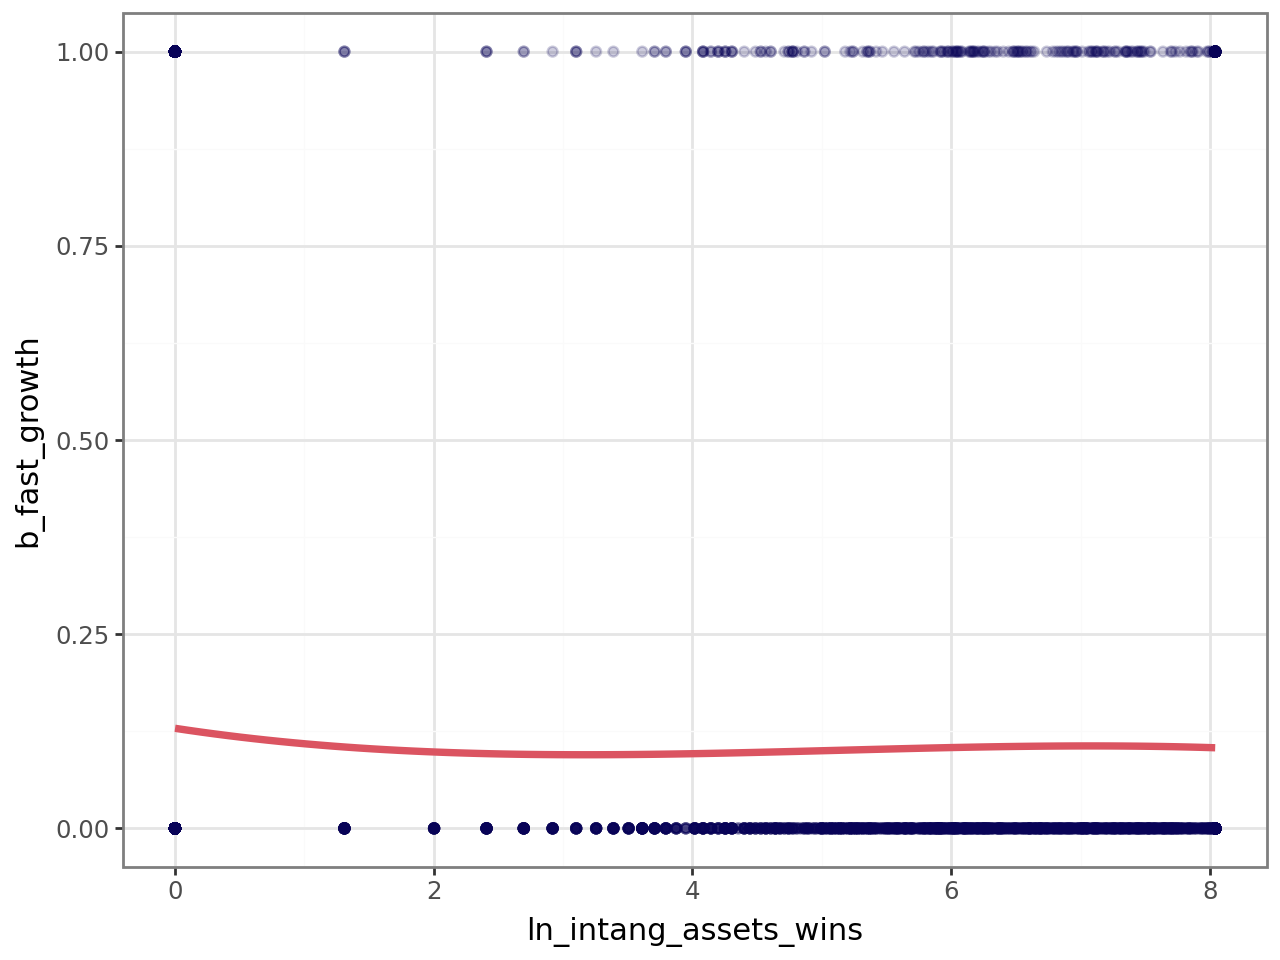

ln_sales_mil_wins


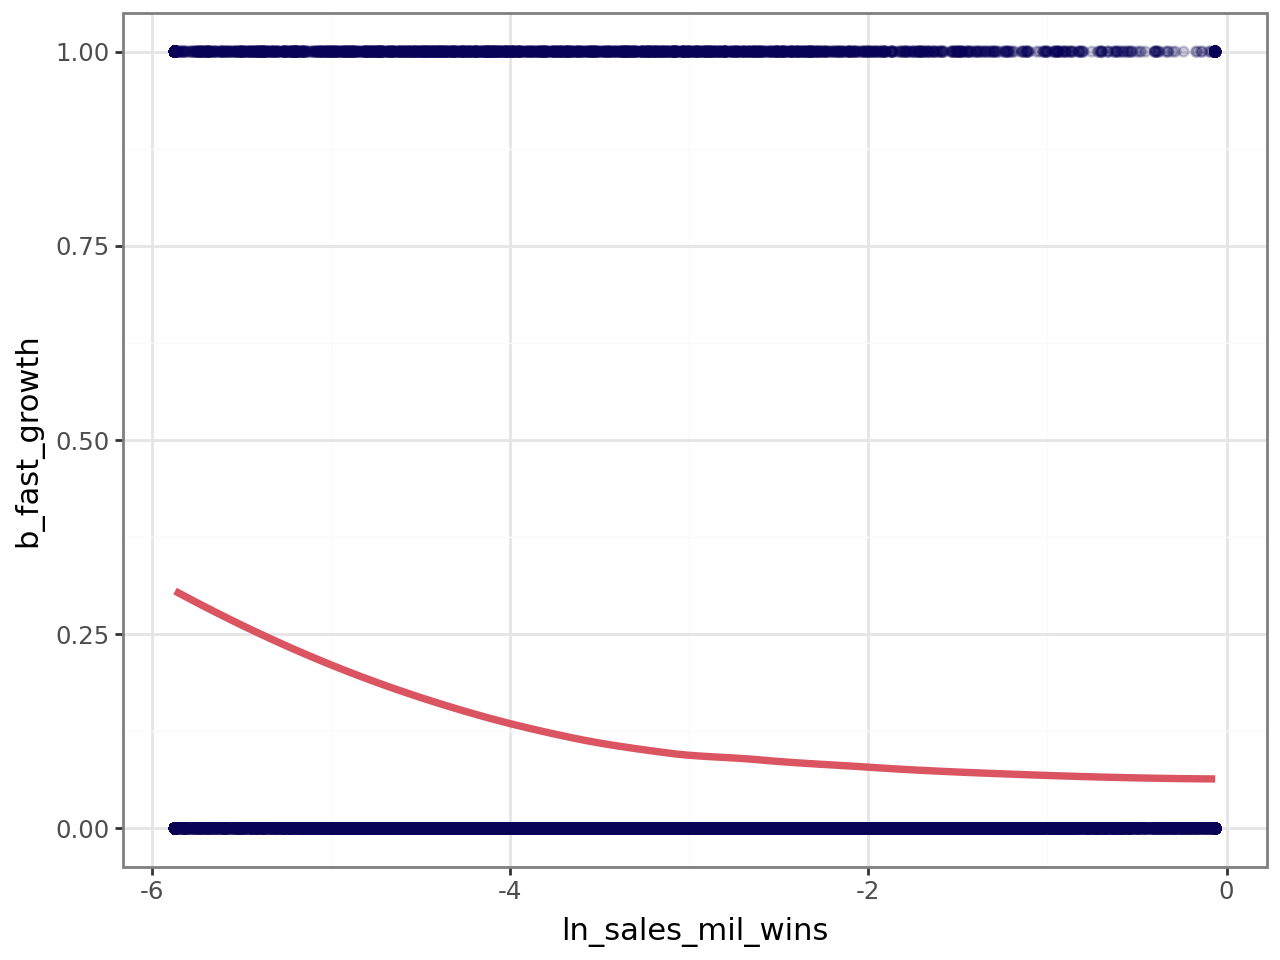

ln_sales_wins


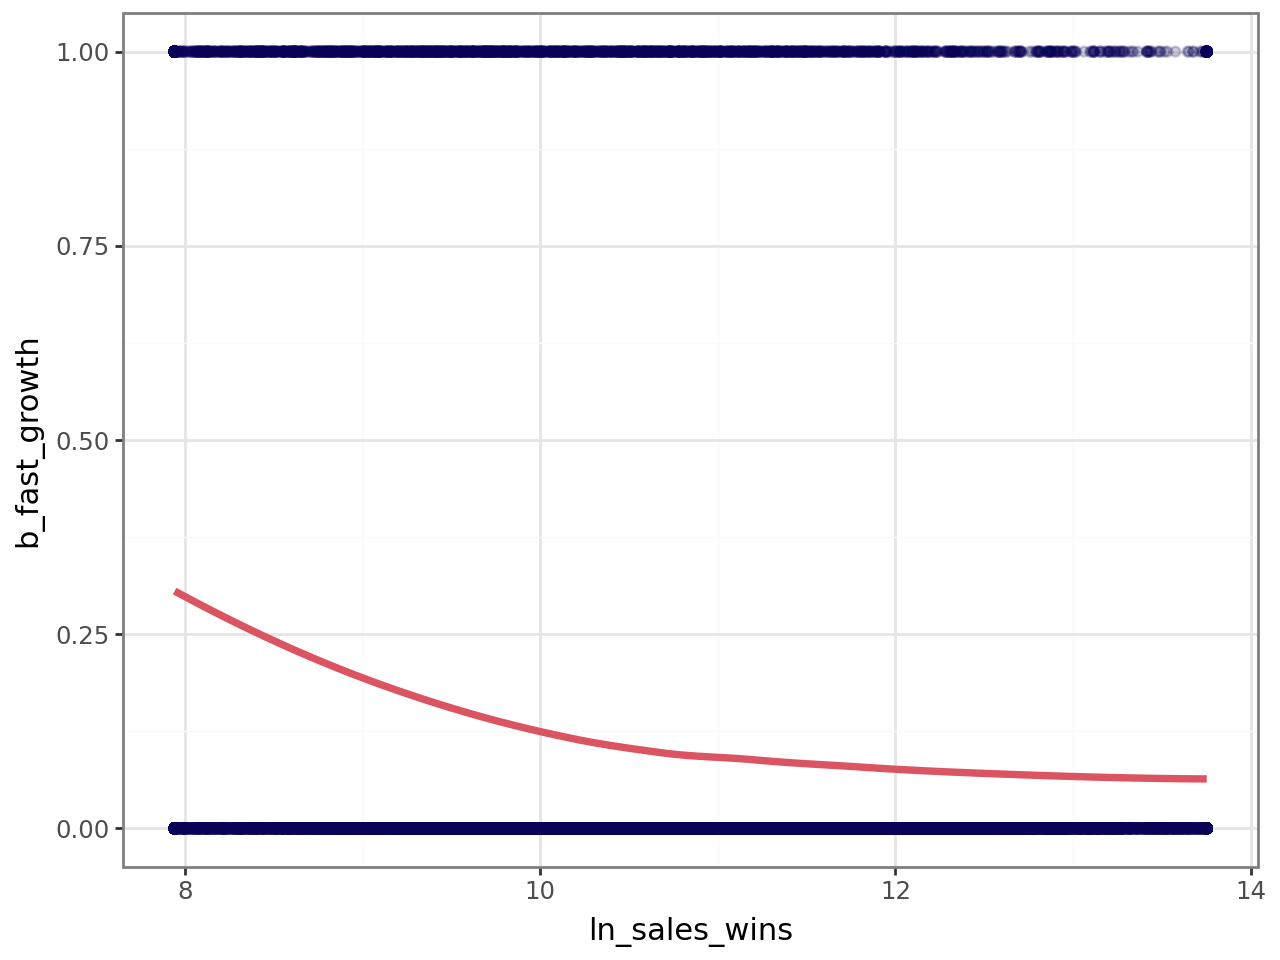

ln_total_assets_wins


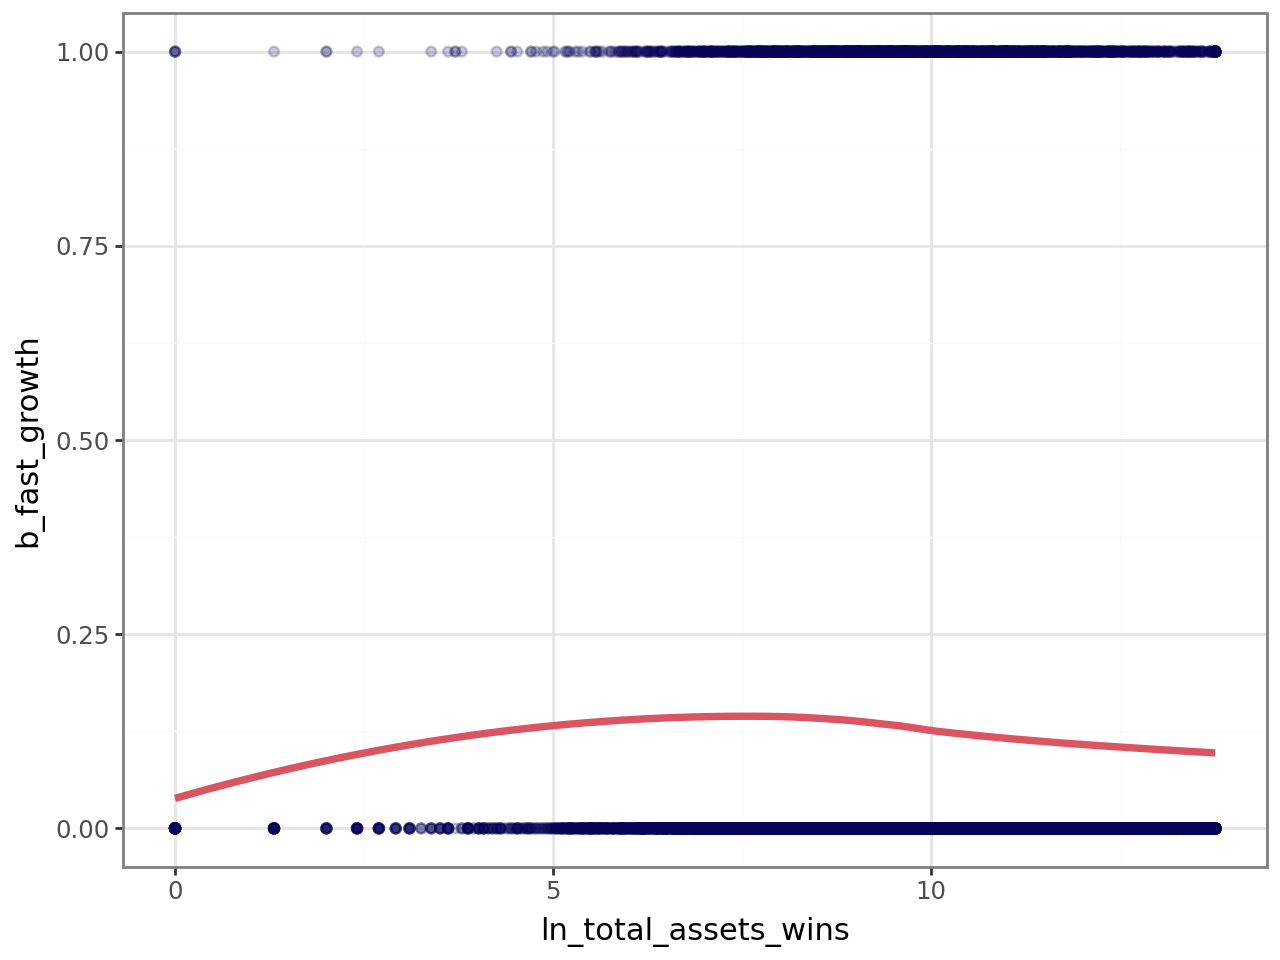

material_exp_pl


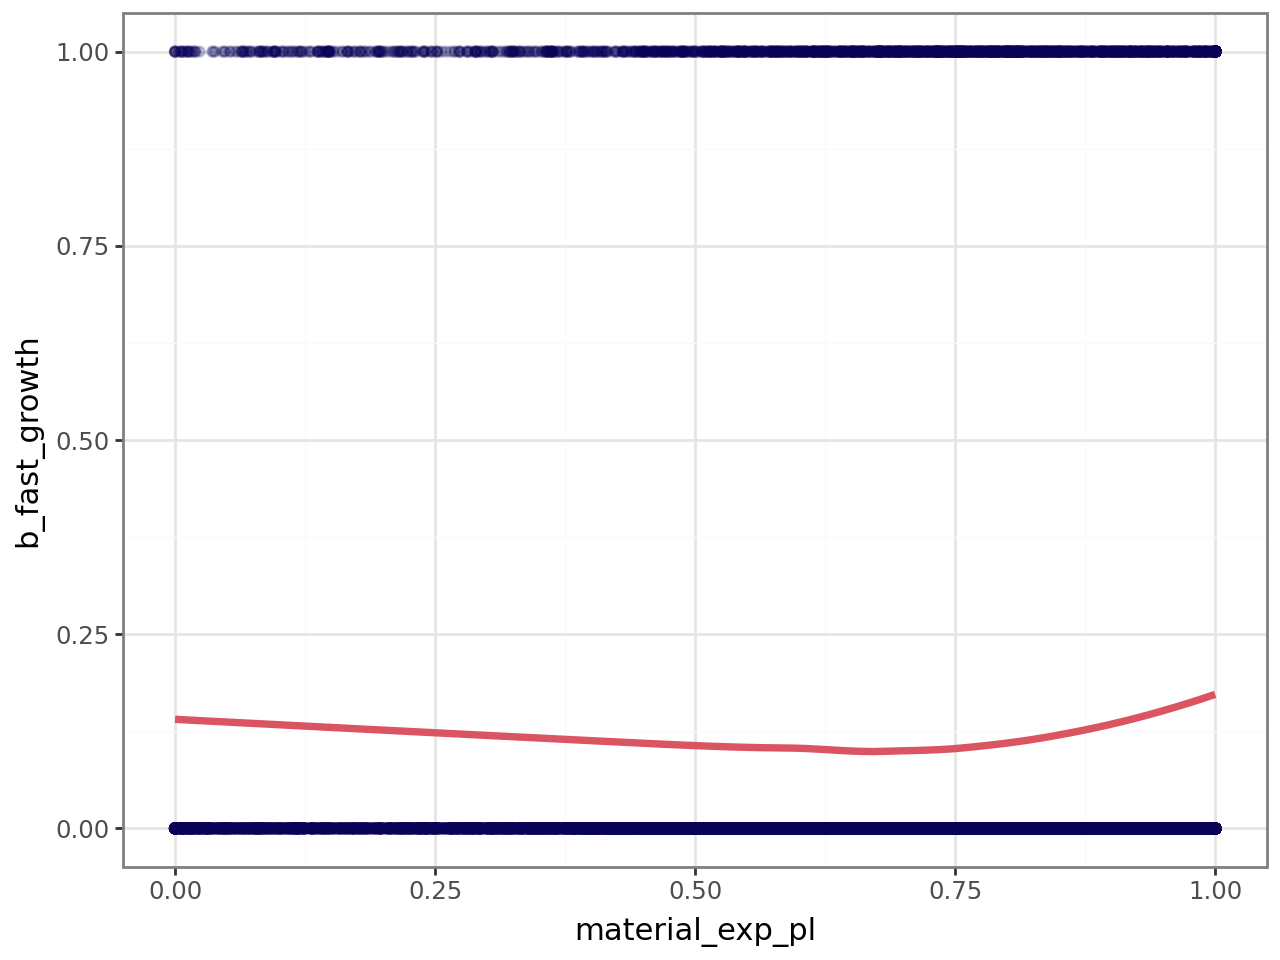

material_exp_wins


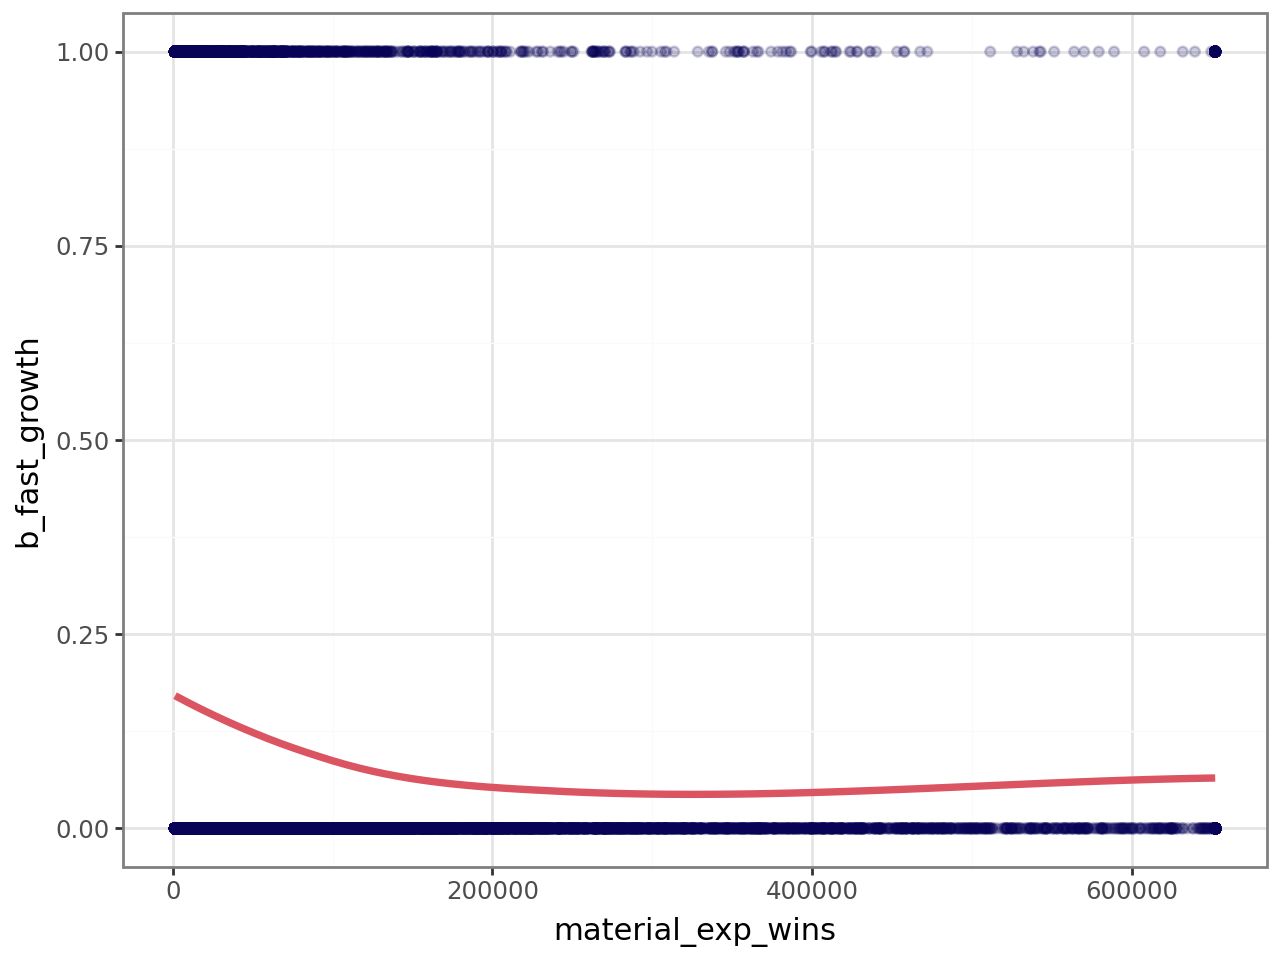

personnel_exp_pl


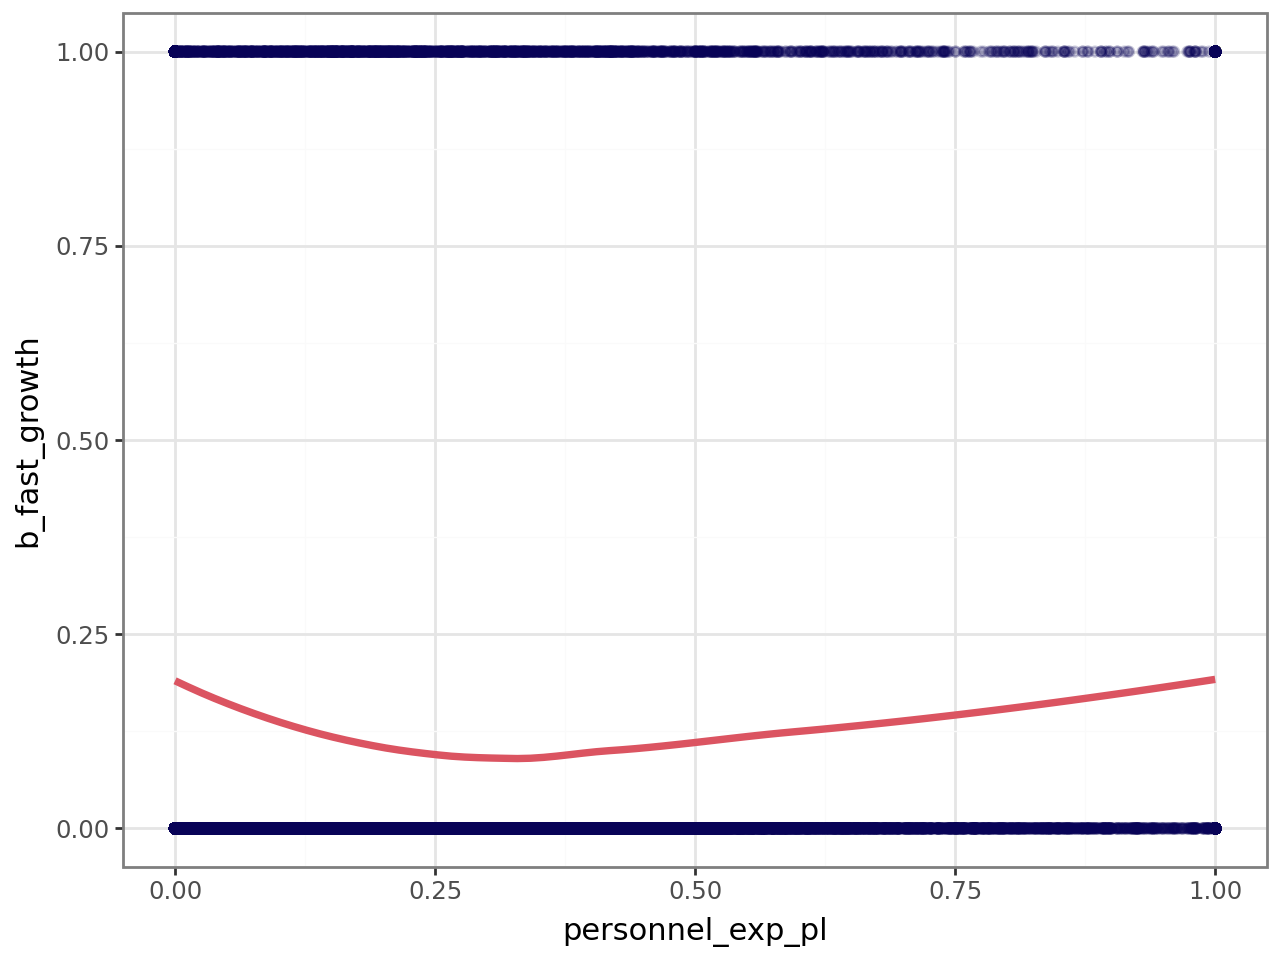

personnel_exp_wins


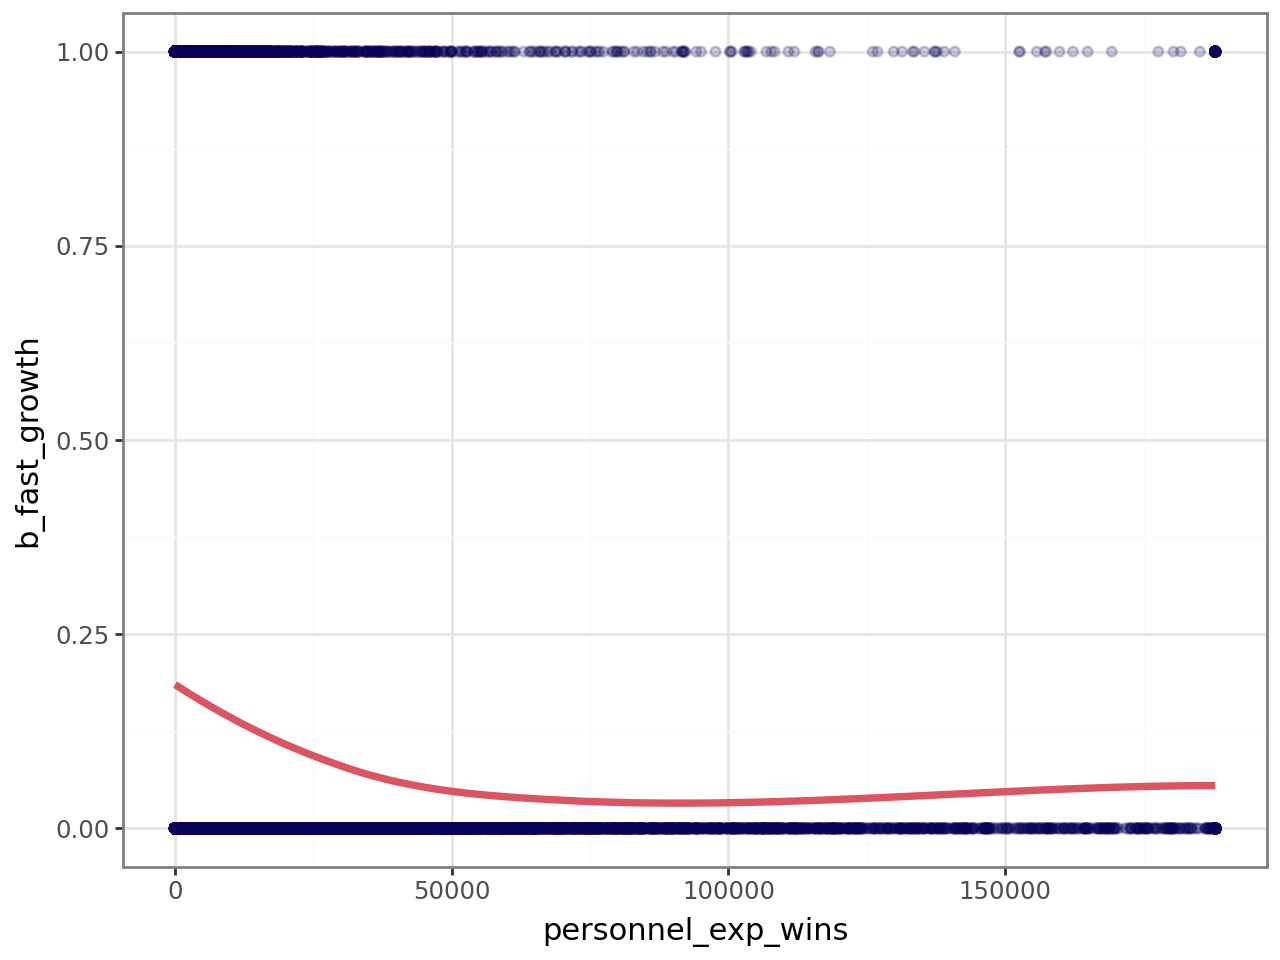

profit_loss_year_pl


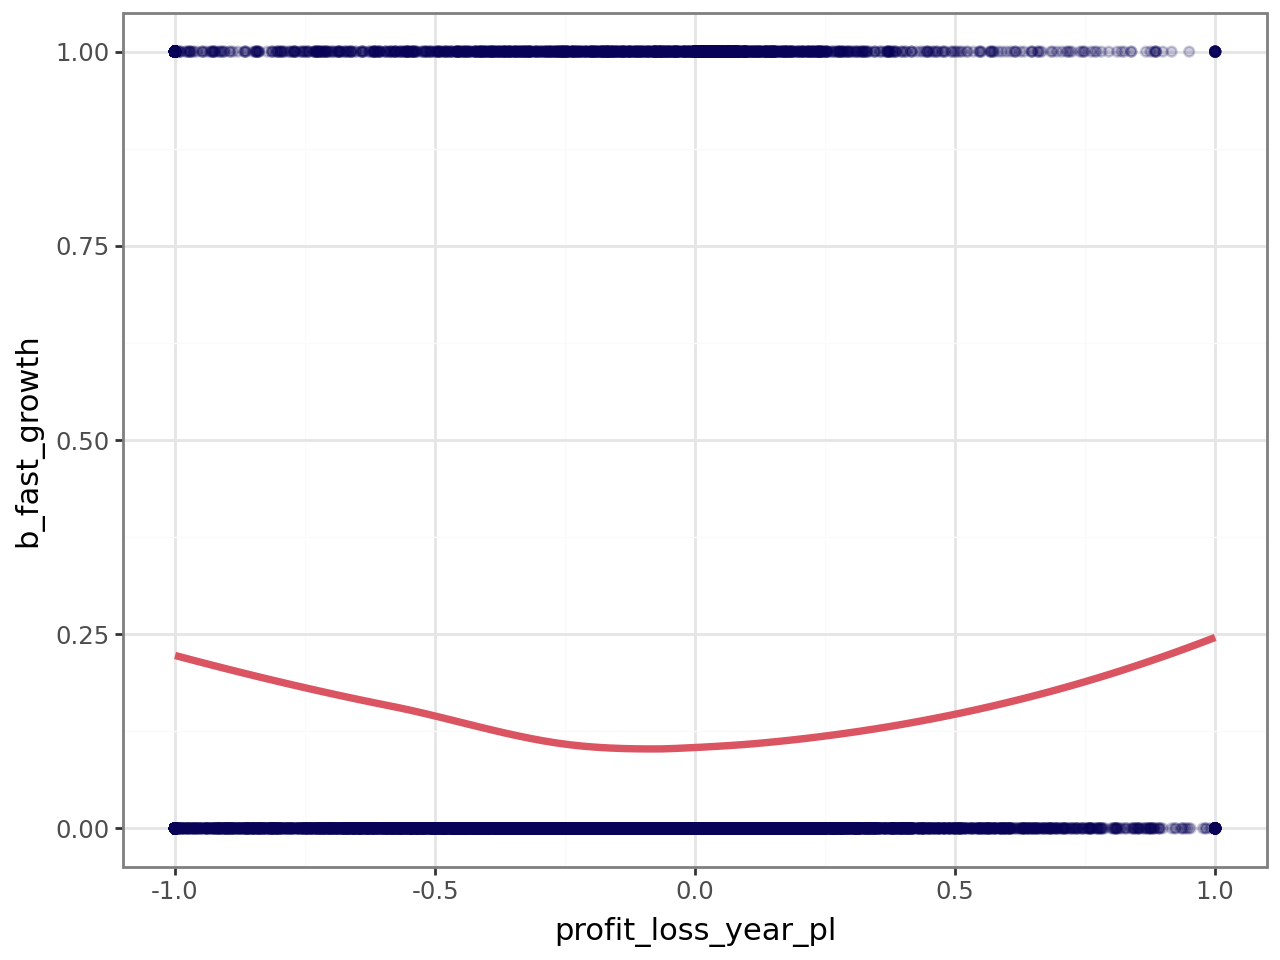

profit_loss_year_wins


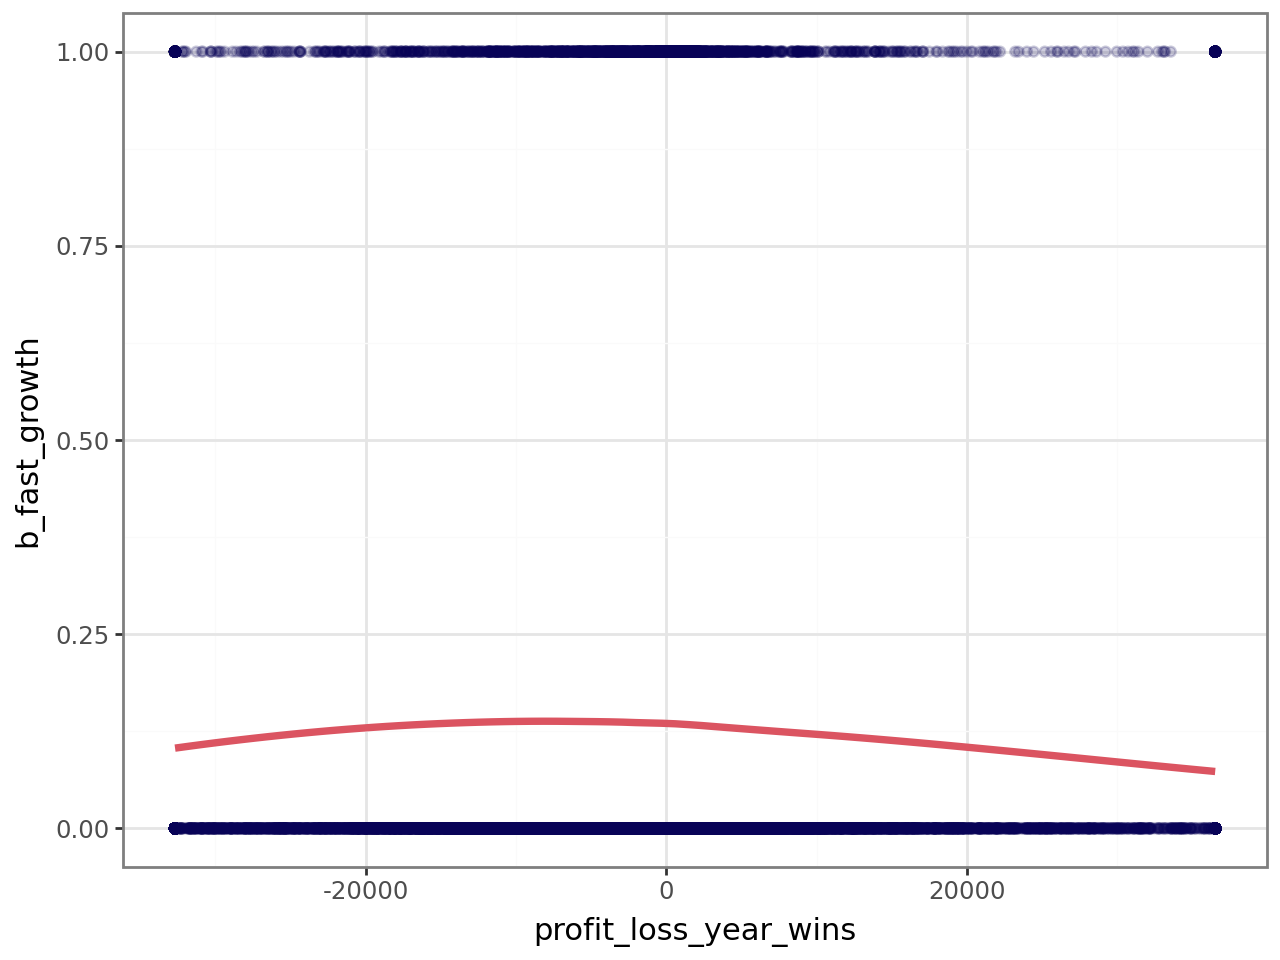

sales_mil_wins


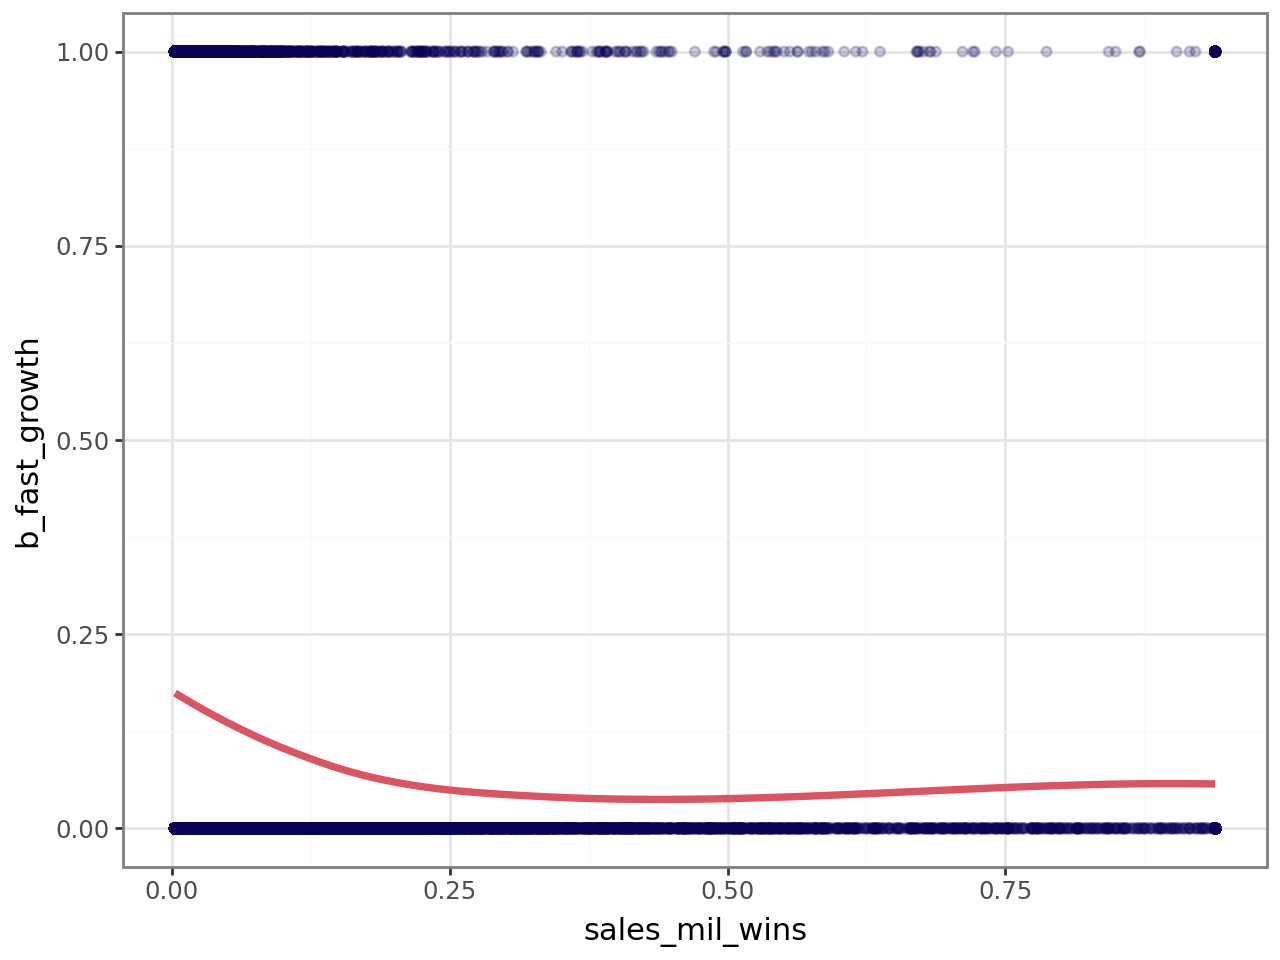

sales_wins


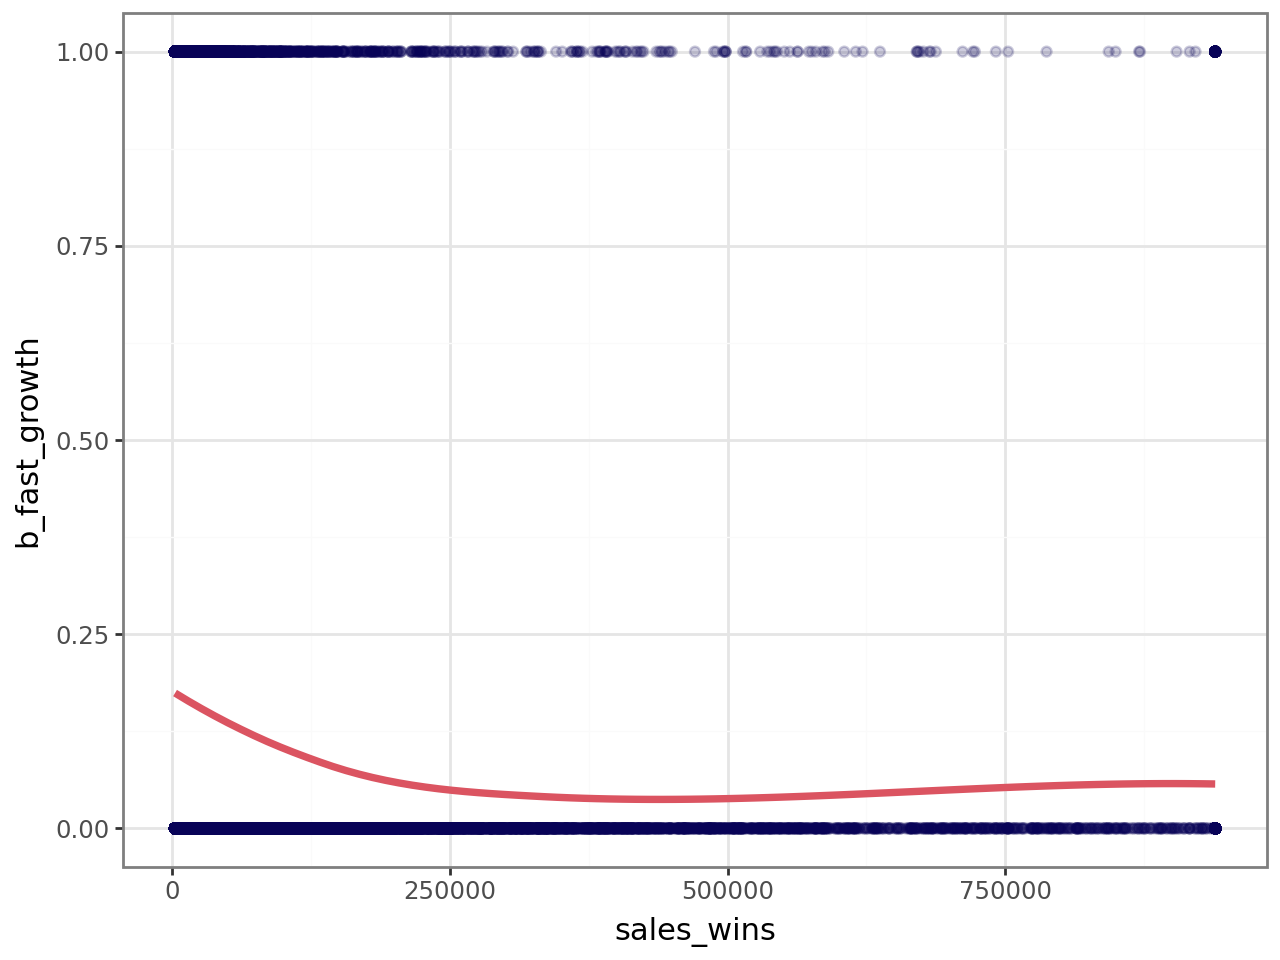

share_eq_bs


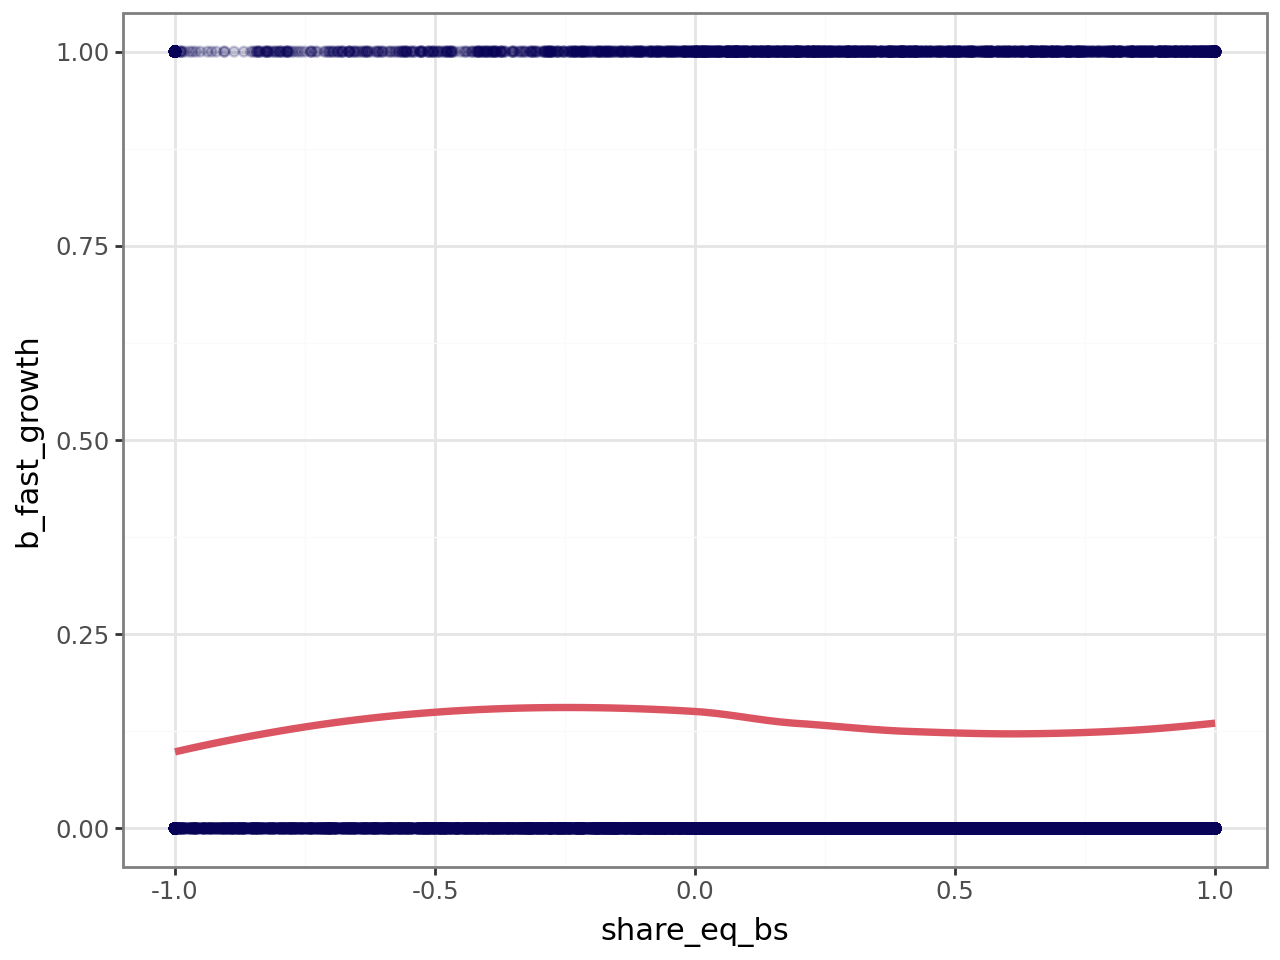

share_eq_wins


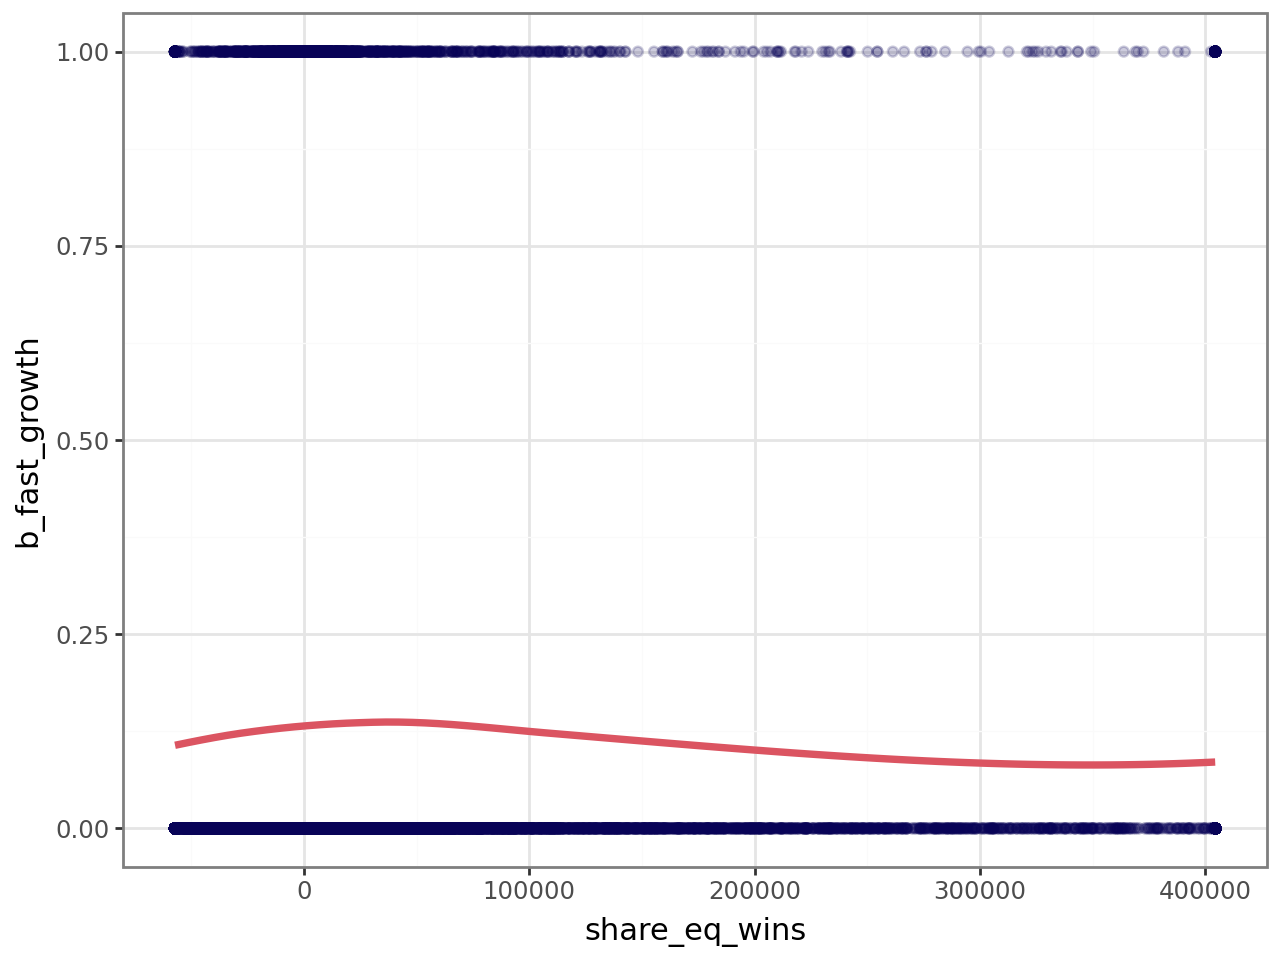

subscribed_cap_bs


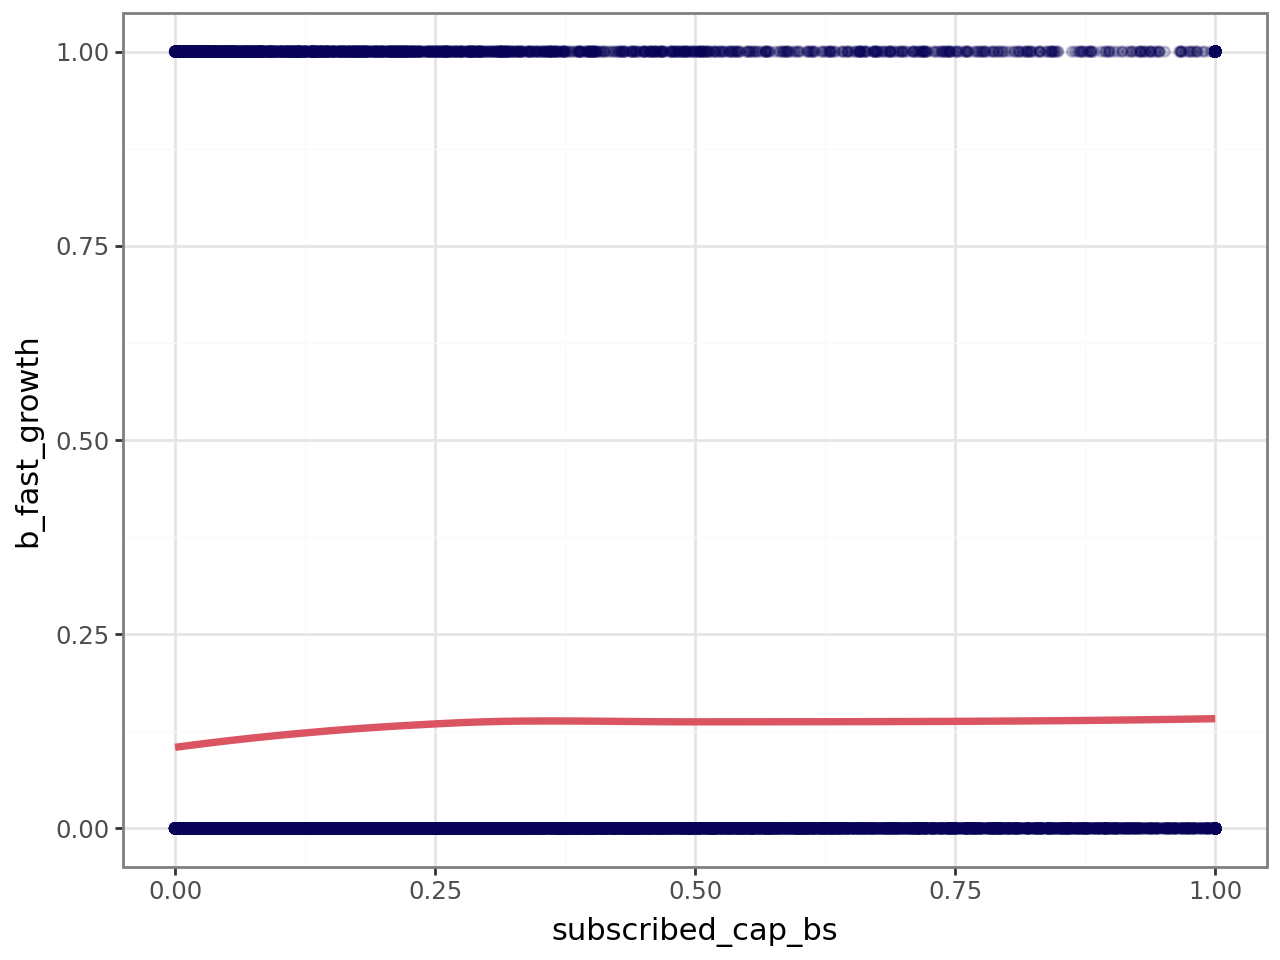

subscribed_cap_wins


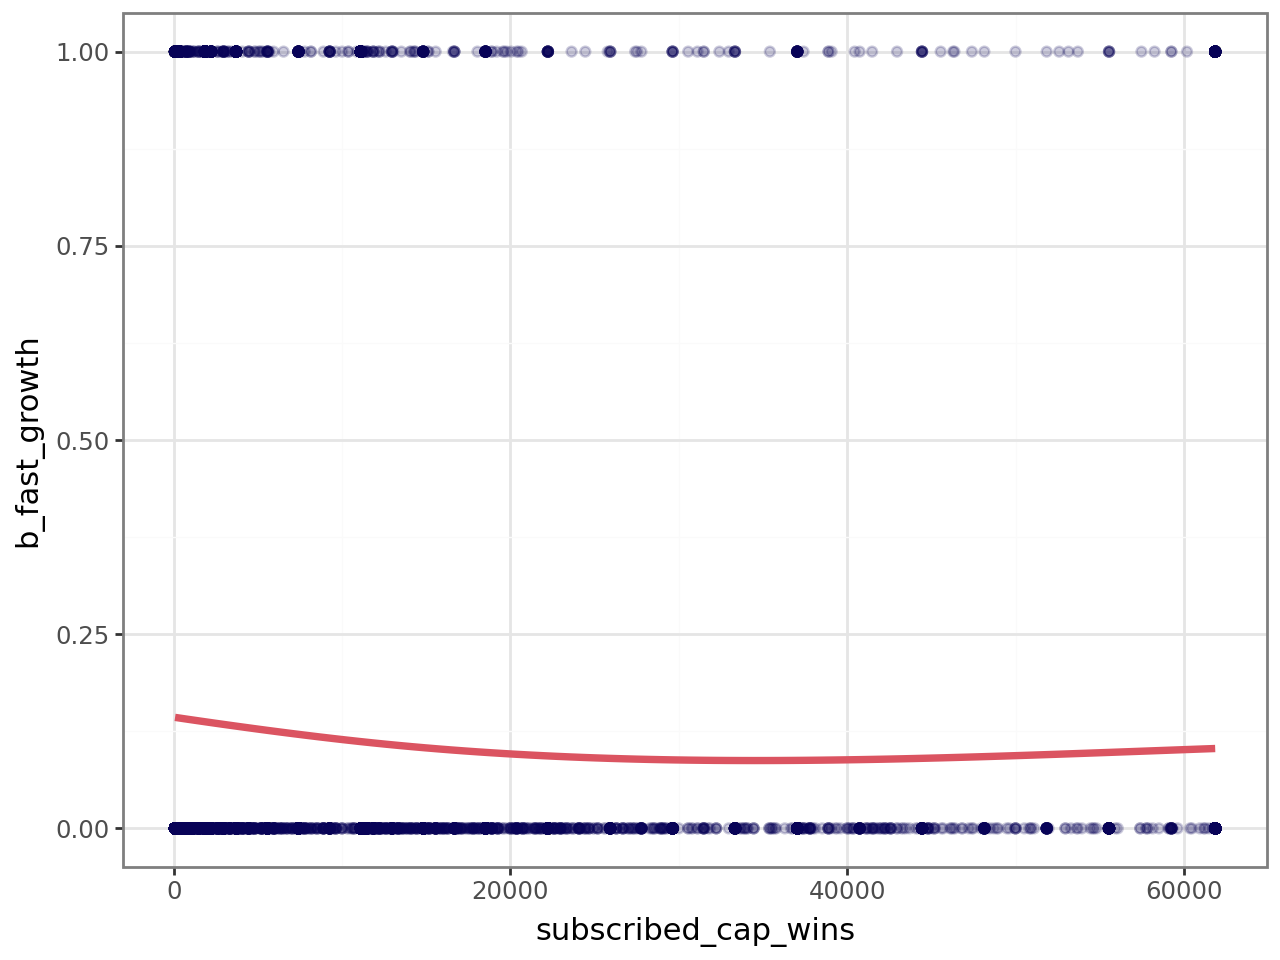

tang_assets_bs_wins


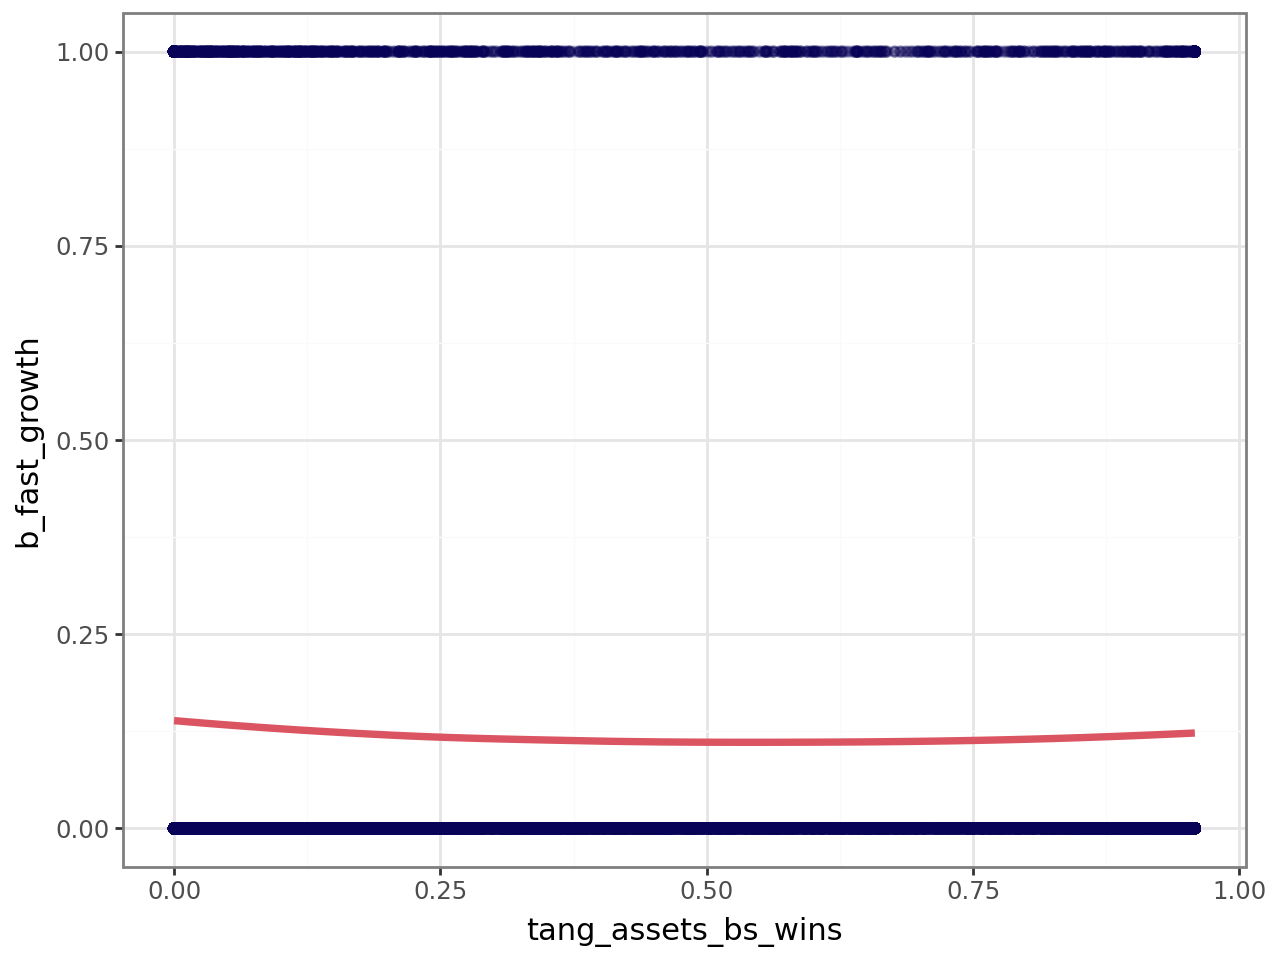

tang_assets_wins


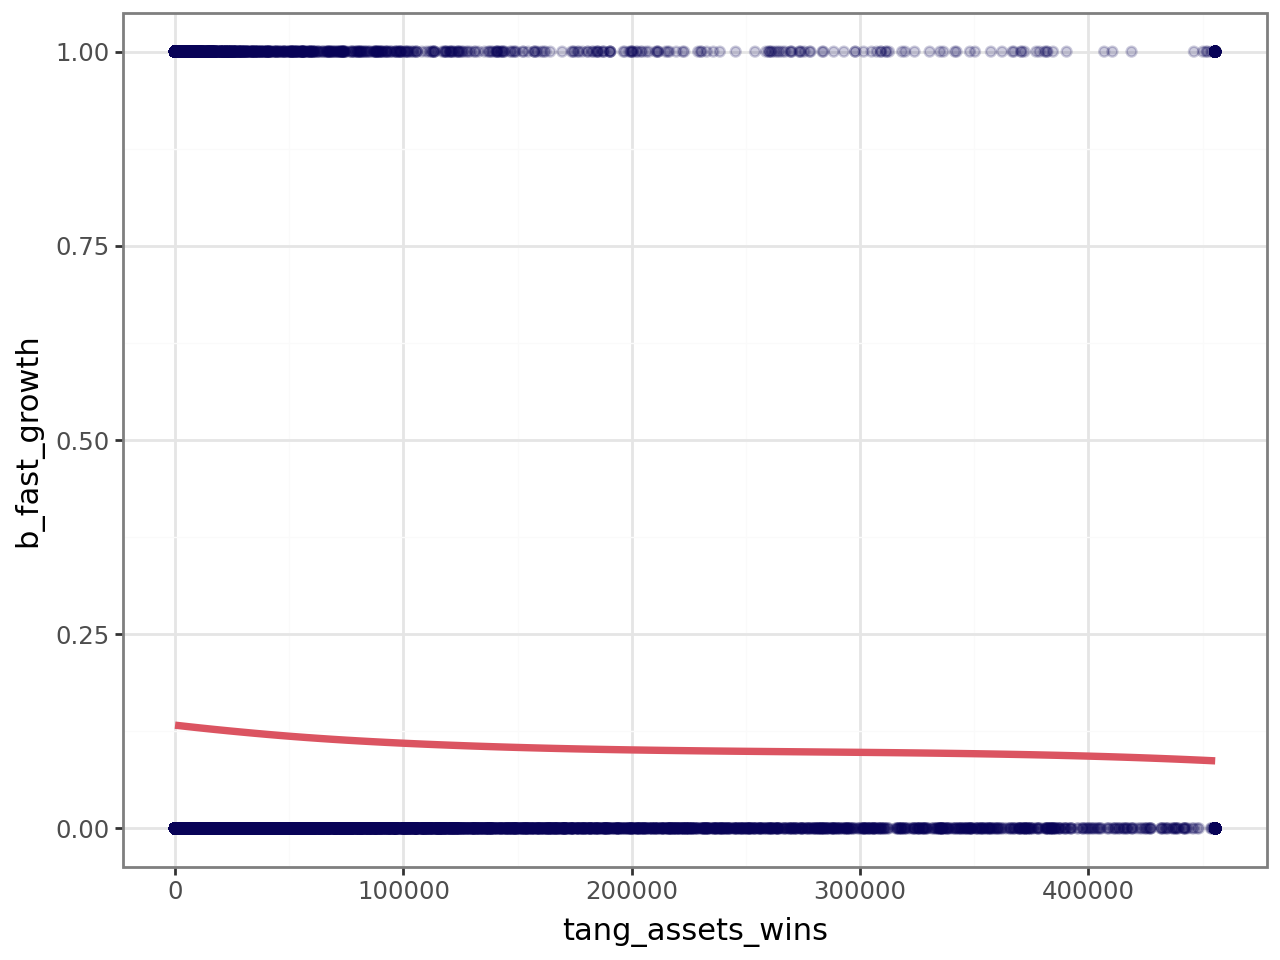

total_assets_bs_wins


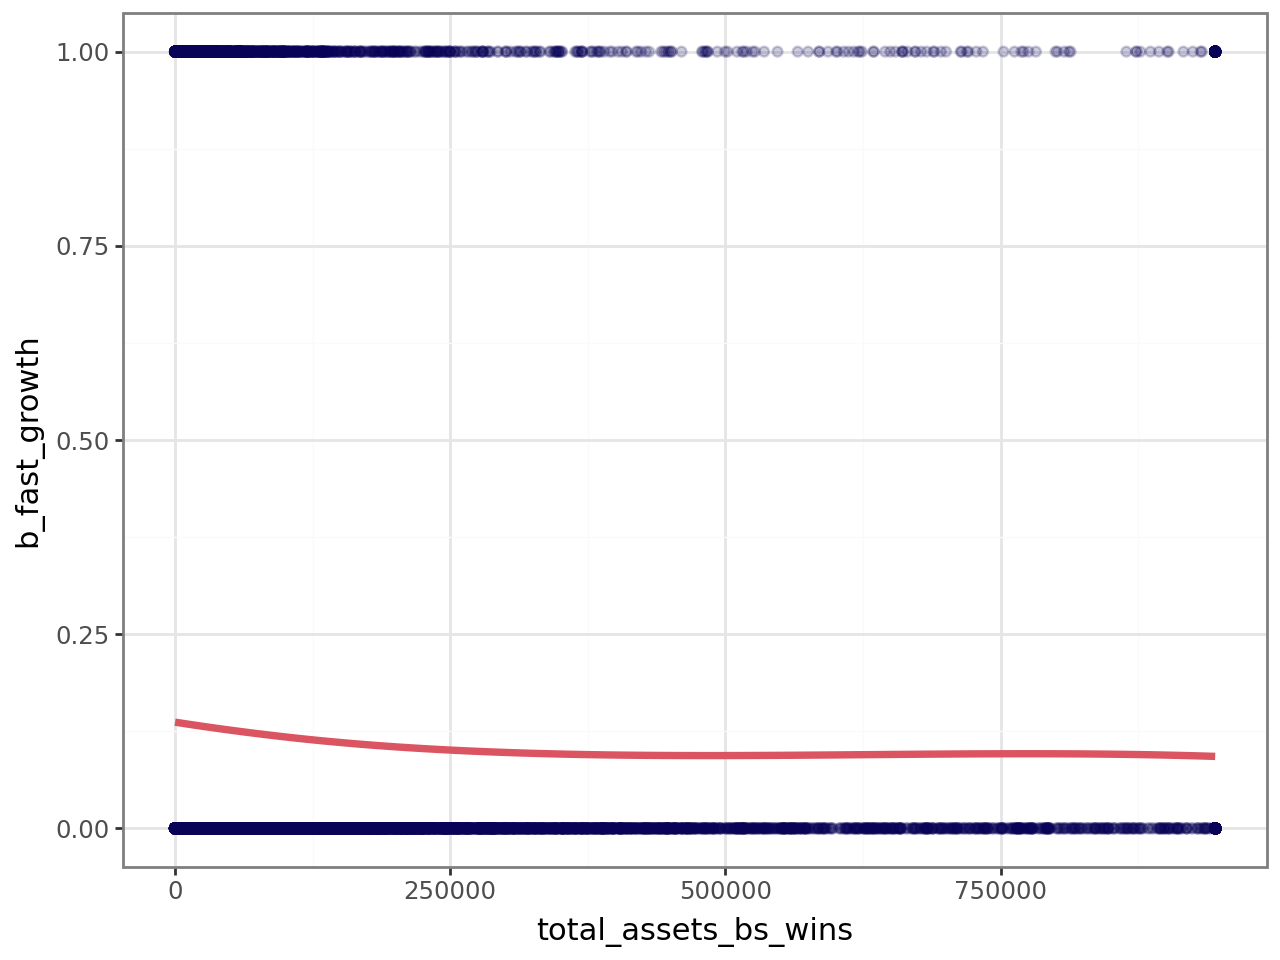

In [59]:
for c in toplot:
    print(c)
    p = (
        ggplot(data, aes(x = c, y = "b_fast_growth"))
        + geom_point(color=color[1], alpha = 0.2)
        + geom_smooth(method = 'loess', color=color[0], se=False, size=1.5, span = 0.95)
        + theme_bw()
    )
    display(p)

As most of the variables have some non-linear patterns according to LOWESS estimates, I add squares and cubes.

In [60]:
for v in toplot:
    data[f'{v}_sq'] = np.power(data[v], 2)
    data[f'{v}_cu'] = np.power(data[v], 3)

Lastly, I save my cleaned workfile. For this, I reorder my columns according to a pre-defined order, to ensure that my variable order is the same after each execution. This is important as tree based models are may produce different results with different variable orders.

The source of the possibly different ordering after each execution is actually because of the `set()`s I use in my code, as these order the passed lists in an undeterministic way. For more detail, see e.g. [this article](https://praful932.dev/blog-1-ordered-sets/).

In [77]:
with open('feature_order.dill', "rb") as f:
    feature_order = dill.load(f)
data = data.filter(feature_order)

In [78]:
with open('HA2_workfile.dill', "wb") as f:
    dill.dump(data, f)